# General Notes

Implementation is based off work by: 

Chen, G., Shin, Y. W., Taylor, P. A., Glen, D. R., Reynolds, R. C., Israel, R. B., & Cox, R. W. (2016). Untangling the            
         relatedness among correlations, part I: Nonparametric approaches to inter-subject correlation analysis at the group level.     NeuroImage, 142, 248-259.

Finn, E. S., Glerean, E., Khojandi, A. Y., Nielson, D., Molfese, P. J., Handwerker, D. A., & Bandettini, P. A. (2020). 
    Idiosynchrony: From shared responses to individual differences during naturalistic neuroimaging. NeuroImage, 215, 116828. 

Finn, E. S., Shen, X., Scheinost, D., Rosenberg, M. D., Huang, J., Chun, M. M., Papademetris, X., & Constable, R. T. (2015). 
   Functional connectome fingerprinting: Identifying individuals based on patterns of brain connectivity. Nature Neuroscience, 18(11), 1664–1671. 

Hasson, U., Nir, Y., Levy, I., Fuhrmann, G., & Malach, R. (2004). 
   Intersubject synchronization of cortical activity during natural vision. science, 303(5664), 1634-1640.

Kauppi, J. P., Pajula, J., & Tohka, J. (2014). A versatile software package for inter-subject correlation based analyses of fMRI. 
   Frontiers in neuroinformatics, 8, 2.

Nastase, S. A., Gazzola, V., Hasson, U., & Keysers, C. (2019). Measuring shared responses across subjects using intersubject  
   correlation. Social cognitive and affective neuroscience, 14(6), 667-685.

Simony, E., Honey, C. J., Chen, J., Lositsky, O., Yeshurun, Y., Wiesel, A., & Hasson, U. (2016).
   Dynamic reconfiguration of the default mode network during narrative comprehension. Nature communications, 7(1), 12141.

[Neuroimaging Analysis Methods For Naturalistic Data](https://naturalistic-data.org/content/intro.html "Website")





Abbreviation Notes 
- psi or p_ = psilocybin 
- esc or e_ = escitalopram
- a = after treatment
- b = before treatment 
- ab = after treatment - before treatment
- n = network parcellation scheme
- isc = intersubject correlation 
- rsa = inter-subject representational similarity analysis 
- ave = average ISC method
- subs = subjects 
- ts = timeseries
- nn = nearest neighbor behavioral model
- annak = anna karenina behavioral model 
- smat = similarity matrix 
- bmat = behavioral similarity matrix
- c = change
- s = surviving
- ba = Brodmann areas 
- stg = superior temporal gyrus 
- dlpfc = dorsolateral prefrontal cortex
- vmpfc = ventromedial prefrontal cortex 
- fc = functional connectivity 
- p = variable that holds p-values 

General Notes 
- If rsa is not indicated then ISC is used
- -1 means that results were not significant and these results were not saved and further analyzed
- Before and after conditions are mixed up for some calculations, though all loops for comparisons of surviving nodes have corrected for this 
- Average RSA pickle is formatted diff. cause I looped those calcs. 

Next Steps 
- Delete temp file before mask is created 
- Get other atlases working 
- Figure out how to use arousal and valence timeseries 
- Find other ways to quantify functional connectivity from ISFC 

Issues 
- PSI before and after are mixed 
- Nodes in comparisons may be off by 1 

# Setting up environment

In [1]:
# Load packages

# File manipulation
import os
import glob
from pathlib import Path
import pickle5 as pickle

# Stats packages 

import numpy as np 
from scipy.stats import rankdata, ttest_rel, ttest_1samp, pearsonr, spearmanr

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import seaborn as sns

import nibabel as nib 
from nilearn.input_data import NiftiLabelsMasker, NiftiSpheresMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf
from nilearn import plotting, datasets # Needed for converting Shen atlas to anatomical labels


from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold, isc, isfc 

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

# Brainiak package
    # Defined as isc_standalone because Brainiak was not possible
    # The Brainiak replacement script is downloaded on my computer and it a replica of Brainiak packages from 
    #   https://github.com/snastase/isc-tutorial/blob/master/isc_tutorial/isc_standalone.py
    # !!!!! Data needs to be reshaped when using this function

    # Dependencies for Brainiak 
import itertools as it
from scipy.spatial.distance import squareform

    # Actual script integration
from isc_standalone import (
    isc as b_isc,
    isfc as b_isfc,
    bootstrap_isc as b_bootstrap_isc,
    permutation_isc as b_permutation_isc,
    compute_summary_statistic as b_compute_summary_statistic,
    squareform_isfc as b_squareform_isfc
)

# Functions for NN Calculation 
from sklearn.neighbors import NearestNeighbors 
from sklearn.preprocessing import StandardScaler

%matplotlib inline # Allows image to be displayed inline 


c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\nilearn\__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# Define some helper functions
def sort_square_mtx(mtx, vct):
    """
    Sorts rows/columns of a matrix according to a separate vector.
    """
    
    inds = vct.argsort()
    mtx_sorted = mtx.copy()
    mtx_sorted = mtx_sorted[inds, :]
    mtx_sorted = mtx_sorted[:, inds]
    
    return mtx_sorted

def scale_mtx(mtx):
    """
    Scales a matrix to have values between 0 and 1.
    """
    return (mtx-np.min(mtx))/(np.max(mtx)-np.min(mtx))

def bootstrap_subject_matrix(similarity_matrix, random_state=None):
    '''This function shuffles subjects within a similarity matrix based on recommendation by Chen et al., 2016'''
    
    random_state = check_random_state(random_state)
    n_sub = similarity_matrix.shape[0]
    bootstrap_subject = sorted(random_state.choice(np.arange(n_sub), size=n_sub, replace=True))
    return similarity_matrix[bootstrap_subject, :][:, bootstrap_subject]


def aggregate_timeseries_by_network(mapping_df, data):
    """
    This function is used to convert a variable to a network map using Finn et al. 2015. 
    Converts the Shen 268 Atlas into 8 networks. (1. Medial Frontal, 2. Frontoparietal, 3. Default Mode
    4. Subcortical-cerebellum, 5. Motor, 6. Visual 1, 7. Visual 2, 8. Visual Association)
    The node to network conversion chart is from https://www.nitrc.org/frs/?group_id=51 
    Which is the BioImage Suite NITRC 

    Data is assumed to be in the form of (subject x timeseries x nodes)

    """
    # Get the unique networks
    unique_networks = mapping_df['Network'].unique()
    
    # Get the number of subjects and timepoints from the data
    n_subjects, n_timepoints, _ = data.shape
    
    # Initialize the aggregated data array
    aggregated_data = np.zeros((n_subjects, n_timepoints, len(unique_networks)))
    
    # Loop through each network and aggregate the data
    for i, network in enumerate(unique_networks):
        # Get the nodes belonging to the current network
        nodes_in_network = mapping_df[mapping_df['Network'] == network]['Node'].values
        
        # Aggregate the timeseries data for the nodes in the current network
        aggregated_data[:, :, i] = data[:, :, nodes_in_network].mean(axis=2)
    
    return aggregated_data

def compute_pair_rsa(smat, bmats):
    """
    Compute RSA similarity and p-values for each node using the provided similarity matrix and multiple behavioral surveys.

    Parameters:
    psi_sim_matrix (list): List of similarity matrices for each node.
    behavioral_surveys (dict): Dictionary of behavioral data with survey names as keys.

    Returns:
    rsa_results (dict): Nested dictionary with survey names as keys and dictionaries of correlation and p-values.
    """
    rsa_results = {}

    for survey_name, behavioral_data in bmats.items():
        rsa_similarity, rsa_pvalues = {}, {}

        for node in range(len(smat)):
            if node == 0:
                print(f"Doing node {node + 1} of {len(smat)} for {survey_name}...", end=" ")
            else:
                print(f"{node + 1}..", end=" ")

            stats_annak = smat[node].similarity(behavioral_data, metric='spearman', n_permute=5000, n_jobs=1)
            rsa_similarity[node] = stats_annak['correlation']
            rsa_pvalues[node] = stats_annak['p']

        rsa_results[survey_name] = {
            'correlation': rsa_similarity,
            'p_values': rsa_pvalues
        }
        print(f"Finished {survey_name}")

    return rsa_results


In [3]:
# Setting directory

data_dir = ""



In [4]:
# Open file with behavioral data 
behav_data = pd.read_csv("")
behav_data.head()

Condition  Participant Number Gender  Pre-TX QIDS  POST_TX QIDS  \
0       ESC                   1      M           20             7   
1       ESC                   2      M           20            18   
2       ESC                   3      F           22             8   
3       ESC                  10      M           19             9   
4       ESC                  14      M           22            18   

   QIDS change (post-pre) >=50% reduction?  BDI_pre  BDI_post  \
0                     -13              Yes       24         8   
1                      -2               No       36        30   
2                     -14              Yes       33        13   
3                     -10              Yes       31        17   
4                      -4               No       33        25   

   BDI change (post-pre)  ...  \
0                    -16  ...   
1                     -6  ...   
2                    -20  ...   
3                    -14  ...   
4                     -8  ...   

  Amount of time spent reflecting on past or future during the last scanning period?.1  \
0                                                  3                                     
1                                                  2                                     
2                                                  9                                     
3                                                 12                                     
4                                                 12                                     

   How active was  your imagination during the last scanning period?.1  \
0                                                  4                     
1                                                  8                     
2                                                  4                     
3                                                 13                     
4                                                  6                     

   How emotional did the music make you feel?.2  \
0                                           3.0   
1                                           2.0   
2                                           0.0   
3                                           0.0   
4                                           2.0   

   How pleasurable was your experience of the music?.2  \
0                                                3.0     
1                                                0.0     
2                                                5.0     
3                                                7.0     
4                                               -1.0     

   Amount of time spent asleep in the last scanning period?.2  \
0                                                0.0            
1                                                2.0            
2                                                0.0            
3                                               -1.0            
4                                                0.0            

   How sleepy did you feel in the last scanning period?.2  \
0                                                8.0        
1                                               10.0        
2                                                4.0        
3                                                1.0        
4                                                5.0        

   How anxious did you feel during the last scanning period?.2  \
0                                                0.0             
1                                               -6.0             
2                                               -9.0             
3                                               -2.0             
4                                                0.0             

   Amount of time spent reflecting on past or future during the last scanning period?.2  \
0                                                0.0                                      
1                 

### Unpickling 
- Creation steps after mask creation can be skipped if pickled 

In [5]:
# Unpickling condition timeseries and shapes

# Making file paths

ts_path = os.path.join(data_dir, 'ts.pkl')

# Loading variables back into workspace

with open(ts_path, 'rb') as f:
   ts = pickle.load(f)

# Load important variables 

   # Full data 

esc_a = ts['ESC_a']
esc_b = ts['ESC_b']
psi_a = ts['PSI_a']
psi_b = ts['PSI_b']
esc_ab = ts['ESC_ab']
psi_ab = ts['PSI_ab']

   # Shape of data 

esc_ab_nodes = ts['ESC_ab_nodes']
esc_ab_subs = ts['ESC_ab_subs']
esc_ab_ts = ts['ESC_ab_ts']
psi_ab_nodes = ts['PSI_ab_nodes']
psi_ab_subs = ts['PSI_ab_subs']
psi_ab_ts = ts['PSI_ab_ts']
esc_a_nodes = ts['ESC_a_nodes']
esc_a_subs = ts['ESC_a_subs']
esc_a_ts = ts['ESC_a_ts']
psi_a_nodes = ts['PSI_a_nodes']
psi_a_subs = ts['PSI_a_subs']
psi_a_ts = ts['PSI_a_ts']
esc_b_nodes = ts['ESC_b_nodes']
esc_b_subs = ts['ESC_b_subs']
esc_b_ts = ts['ESC_b_ts']
psi_b_nodes = ts['PSI_b_nodes']
psi_b_subs = ts['PSI_b_subs']
psi_b_ts = ts['PSI_b_ts']

del ts, ts_path, f # Deleting variables for function for cleanliness 

In [9]:
# Unpickling Ave ISC 

# Making file paths

ave_iscs_path = os.path.join(data_dir, 'ave.pkl')

# Loading variables back into workspace
with open(ave_iscs_path, 'rb') as f:
   ave_iscs = pickle.load(f)

# Loading variables 

esc_a_ave = ave_iscs['ESC_a_ave']
esc_b_ave = ave_iscs['ESC_b_ave']
psi_a_ave = ave_iscs['PSI_a_ave']
psi_b_ave = ave_iscs['PSI_b_ave']
esc_ab_ave = ave_iscs['ESC_ab_ave']
psi_ab_ave = ave_iscs['PSI_ab_ave']

del ave_iscs_path, f # Deleting variables for function for cleanliness 



In [77]:
# Unpickling Ave RSA 
ave_rsa_path = os.path.join(data_dir, 'ave_rsa.pkl')

# Loading variables back into workspace
with open(ave_rsa_path, 'rb') as f:
   ave_rsa = pickle.load(f)

# Loading variables 

psi_a_ave_rsa = ave_rsa['PSI']['PSI_a_ave_rsa']
psi_b_ave_rsa = ave_rsa['PSI']['PSI_b_ave_rsa']
psi_ab_ave_rsa = ave_rsa['PSI']['PSI_ab_ave_rsa']
psi_a_ave_nn_rsa = ave_rsa['PSI']['PSI_a_ave_nn_rsa']
psi_b_ave_nn_rsa = ave_rsa['PSI']['PSI_a_ave_nn_rsa']
psi_ab_ave_nn_rsa = ave_rsa['PSI']['PSI_a_ave_nn_rsa']

esc_a_ave_rsa = ave_rsa['ESC']['ESC_a_ave_rsa']
esc_b_ave_rsa = ave_rsa['ESC']['ESC_b_ave_rsa']
esc_ab_ave_rsa = ave_rsa['ESC']['ESC_ab_ave_rsa']
esc_a_ave_nn_rsa = ave_rsa['ESC']['ESC_a_ave_nn_rsa']
esc_b_ave_nn_rsa = ave_rsa['ESC']['ESC_b_ave_nn_rsa']
esc_ab_ave_nn_rsa = ave_rsa['ESC']['ESC_ab_ave_nn_rsa']

del ave_rsa_path, f # Deleting variables for function for cleanliness 

In [21]:
# Unpickling similarity matrices 

# Making file paths

pair_smat_path = os.path.join(data_dir, 'smat.pkl')

# Loading variables back into workspace
with open(pair_smat_path, 'rb') as f:
   smat = pickle.load(f)

# Loading important variables back into workspace 
esc_a_smat = smat['ESC_a_smat']
esc_b_smat = smat['ESC_b_smat']
psi_a_smat = smat['PSI_a_smat']
psi_b_smat = smat['PSI_b_smat']
esc_ab_smat = smat['ESC_ab_smat']
psi_ab_smat = smat['PSI_ab_smat']
esc_ab_ave = smat['ESC_ab_ave_smat']
psi_ab_ave = smat['PSI_ab_ave_smat']

del smat, pair_smat_path, f # Deleting variables for function for cleanliness 


In [223]:
# AnnaK Behavioral Matrices 

# Making file paths

psi_pair_bmat_path = os.path.join(data_dir, 'psi_pair_bmat.pkl')
esc_pair_bmat_path = os.path.join(data_dir, 'esc_pair_bmat.pkl')

# Loading variables back into workspace

with open(psi_pair_bmat_path, 'rb') as f:
    psi_bmats = pickle.load(f)

with open(esc_pair_bmat_path, 'rb') as f:
    esc_bmats = pickle.load(f)

# Loading important variables back into workspace 

psi_val_c_bmat = psi_bmats['Valence']
psi_aro_c_bmat = psi_bmats['Arousal']
psi_AIMS_c_annak = psi_bmats['AIMS']
psi_BDI_c_annak = psi_bmats['BDI']
psi_LEIS_annak = psi_bmats['LEIS']
psi_SHAPS_c_annak = psi_bmats['SHAPS']
psi_GEMS_une_c_annak = psi_bmats['GEMS_une']
psi_GEMS_vit_c_annak = psi_bmats['GEMS_vit']
psi_GEMS_subl_c_annak = psi_bmats['GEMS_subl']
psi_GEMS_tot_a_annak = psi_bmats['GEMS']
psi_QIDS_c_annak = psi_bmats['QIDS']

del psi_pair_bmat_path # Deleting variables for function for cleanliness 

esc_val_c_bmat = esc_bmats['Valence']
esc_aro_c_bmat = esc_bmats['Arousal']
esc_AIMS_c_annak = esc_bmats['AIMS']
esc_BDI_c_annak = esc_bmats['BDI']
esc_LEIS_annak = esc_bmats['LEIS']
esc_SHAPS_c_annak = esc_bmats['SHAPS']
esc_GEMS_une_c_annak = esc_bmats['GEMS_une']
esc_GEMS_vit_c_annak = esc_bmats['GEMS_vit']
esc_GEMS_subl_c_annak = esc_bmats['GEMS_subl']
esc_GEMS_tot_a_annak = esc_bmats['GEMS']
esc_QIDS_c_annak = esc_bmats['QIDS']

del esc_pair_bmat_path, f # Deleting variables for function for cleanliness 

# Making list of variable names 

esc_bmat_variable_names = [var_name for var_name in globals() if var_name.endswith('annak') and var_name.startswith('esc')]
psi_bmat_variable_names = [var_name for var_name in globals() if var_name.endswith('annak') and var_name.startswith('psi')]

In [24]:
# NN Behavioral Matrices 

# Making file paths

psi_pair_bmat_path = os.path.join(data_dir, 'psi_pair_bmat.pkl')
esc_pair_bmat_path = os.path.join(data_dir, 'esc_pair_bmat.pkl')

# Loading variables back into workspace

with open(psi_pair_bmat_path, 'rb') as f:
    psi_bmats = pickle.load(f)

with open(esc_pair_bmat_path, 'rb') as f:
    esc_bmats = pickle.load(f)

# Load important variables 

psi_AIMS_c_nn = psi_bmats['AIMS_nn']
psi_BDI_c_nn = psi_bmats['BDI_nn']
psi_LEIS_nn = psi_bmats['LEIS_nn']
psi_SHAPS_c_nn = psi_bmats['SHAP_nn']
psi_GEMS_une_c_nn = psi_bmats['GEMS_une_nn']
psi_GEMS_vit_c_nn = psi_bmats['GEMS_vit_nn']
psi_GEMS_subl_c_nn = psi_bmats['GEMS_subl_nn']
psi_GEMS_tot_a_nn = psi_bmats['GEMS_nn']
psi_QIDS_c_nn = psi_bmats['QIDS_nn']

del psi_pair_bmat_path # Deleting variables for function for cleanliness 

esc_AIMS_c_nn = esc_bmats['AIMS_nn']
esc_BDI_c_nn = esc_bmats['BDI_nn']
esc_LEIS_nn = esc_bmats['LEIS_nn']
esc_SHAPS_c_nn = esc_bmats['SHAP_nn']
esc_GEMS_une_c_nn = esc_bmats['GEMS_une_nn']
esc_GEMS_vit_c_nn = esc_bmats['GEMS_vit_nn']
esc_GEMS_subl_c_nn = esc_bmats['GEMS_subl_nn']
esc_GEMS_tot_a_nn = esc_bmats['GEMS_nn']
esc_QIDS_c_nn = esc_bmats['QIDS_nn']

del esc_pair_bmat_path, f # Deleting variables for function for cleanliness 

#esc_bmat_variable_names = [var_name for var_name in globals() if var_name.endswith('nn') and var_name.startswith('esc')]
#psi_bmat_variable_names = [var_name for var_name in globals() if var_name.endswith('nn') and var_name.startswith('psi')]

In [11]:
# RSA results only // mainly to check significant nodes 

annak_pair_rsa_path = os.path.join(data_dir, 'annak_pair_rsa.pkl')
nn_pair_rsa_path = os.path.join(data_dir, 'nn_pair_rsa.pkl')


# Loading variables back into workspace


with open(annak_pair_rsa_path, 'rb') as f:
    annak_pair_rsa = pickle.load(f)

with open(nn_pair_rsa_path, 'rb') as f:
    nn_pair_rsa = pickle.load(f)

del annak_pair_rsa_path, f, nn_pair_rsa_path # Deleting variables for function for cleanliness 



In [34]:

# Recursive function format to check all keys in pickled files 
def print_keys(d, level=0):
    indent = "  " * level  # Indentation for better readability
    for key, value in d.items():
        print(f"{indent}{key}")
        if isinstance(value, dict):  # If the value is a dictionary, recurse into it
            print_keys(value, level + 1)

# Call the function on the nested dictionary
print_keys(ave_rsa)

PSI
  PSI_a_ave_rsa
    psi_QIDS_p
    psi_GEMS_tot_
    psi_GEMS_subl_
    psi_GEMS_vit_
    psi_GEMS_une_
    psi_SHAPS_
    psi_LEI
    psi_BDI_
    psi_AIMS_
  PSI_b_ave_rsa
    psi_QIDS_p
    psi_GEMS_tot_
    psi_GEMS_subl_
    psi_GEMS_vit_
    psi_GEMS_une_
    psi_SHAPS_
    psi_LEI
    psi_BDI_
    psi_AIMS_
  PSI_ab_ave_rsa
    psi_QIDS_p
    psi_GEMS_tot_
    psi_GEMS_subl_
    psi_GEMS_vit_
    psi_GEMS_une_
    psi_SHAPS_
    psi_LEI
    psi_BDI_
    psi_AIMS_
  PSI_a_ave_nn_rsa
    psi_QIDS_pp
    psi_GEMS_tot_c
    psi_GEMS_subl_c
    psi_GEMS_vit_c
    psi_GEMS_une_c
    psi_SHAPS_c
    psi_LEIS
    psi_BDI_c
    psi_AIMS_c
  PSI_b_ave_nn_rsa
    psi_QIDS_pp
    psi_GEMS_tot_c
    psi_GEMS_subl_c
    psi_GEMS_vit_c
    psi_GEMS_une_c
    psi_SHAPS_c
    psi_LEIS
    psi_BDI_c
    psi_AIMS_c
  PSI_ab_ave_nn_rsa
    psi_QIDS_pp
    psi_GEMS_tot_c
    psi_GEMS_subl_c
    psi_GEMS_vit_c
    psi_GEMS_une_c
    psi_SHAPS_c
    psi_LEIS
    psi_BDI_c
    psi_AIMS_c
ESC
  ESC_

## Mask Creation

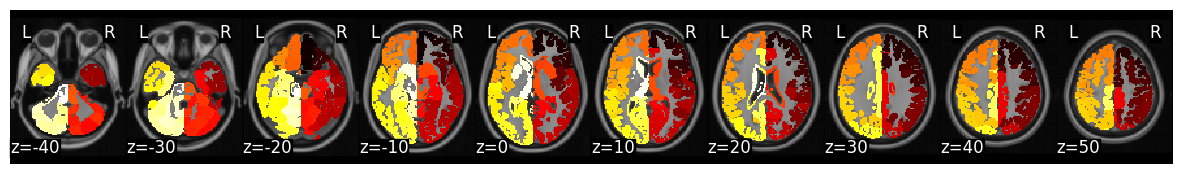

In [8]:
# Loading Shen atlas (https://www.sciencedirect.com/science/article/abs/pii/S1053811913005818)
# 268 nodes including subcortex

## Issue with mask image being saved in a temp file. So when trying to rerun I have to manually delete temp file each time 
### Put line of code in where the temp file gets deleted before this code is run

## This was the code I tried to use to delete the temp file
# Specify the file path
#file_path = "C:/Users/bigbr/AppData/Local/Temp/0.0"
#
## Check if the file exists before attempting to delete it
#if os.path.exists(file_path):
#    # Delete the file
#    os.remove(file_path)
#    print(f"File '{file_path}' deleted successfully.")
#else:
#    print(f"File '{file_path}' does not exist.")

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask.plot()

masker = NiftiLabelsMasker(labels_img=mask.to_nifti(), standardize=True)

(408, 268)


<AxesSubplot:>

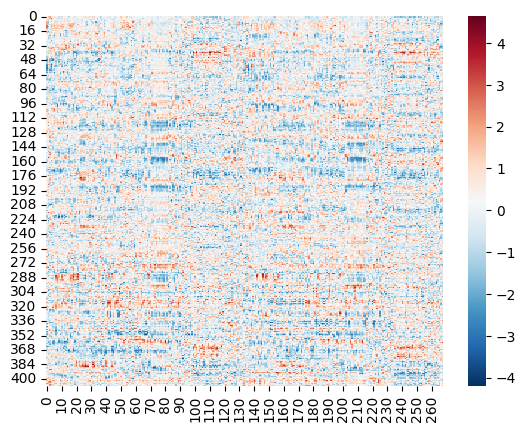

In [60]:
# Seeing what mask looks like in a heatmap per subject 

# Defining which subject 
sub = 'S01'# Subject string
# Creating a file path using os.path.join from whatever the data_dir is and whatever the sub # is 
fmri_file = os.path.join(data_dir, 'preproc_music_leor', 'after', sub, 'after_music_rdsmffms6FWHM_bd_M_V_DV_WMlocal2_modecorr.nii.gz')

# Creating a time series 
time_series = masker.fit_transform(fmri_file)

# Printing the shape of the time series 
# Returned value syntax = (# of volumes, # of nodes) 
print(time_series.shape) 
# Returned value looks good with 408 showing up and we collected 408 volumes 

# Heatmap of time series with the colors defined by cmap 
# 'RdBu_r' means red blue reversed, so positive values are in blue and negative values are in red 
sns.heatmap(time_series, cmap='RdBu_r')

### Anatomical Labelling 
- Downloaded from https://github.com/esfinn/intersubj_rsa/blob/master/xilin_268parc_labels.csv?plain=1


In [104]:
# Load mapping 
ba_path = os.path.join(data_dir, 'shen_BA.csv')
mapping_df = pd.read_csv(ba_path)
ba_def = mapping_df['BA'].tolist()

del ba_path, mapping_df # Deleting variables for function for cleanliness 


In [7]:
# Load the CSV file with MNI coordinates
shen_mni_path = os.path.join(data_dir, 'shen269_MNIBrod.csv')
shen_csv = pd.read_csv(shen_mni_path)

In [77]:
# Extract MNI coordinates and node IDs
node_ids = shen_csv['Node_No'].values
mni_coordinates = shen_csv[['MNI_X', 'MNI_Y', 'MNI_Z']].values

In [60]:
# Not working 
    # the Shen coordinates for each node creates nonsensical Harvard Oxford anatomical labels 

# Convert Shen Atlas MNI to anatomical labels from Harvard Oxford

# Load the CSV file with MNI coordinates
shen_mni_path = os.path.join(data_dir, 'shen269_MNIBrod.csv')
shen_csv = pd.read_csv(shen_mni_path)

# Extract MNI coordinates and node IDs
node_ids = shen_csv['Node_No'].values
mni_coordinates = shen_csv[['MNI_X', 'MNI_Y', 'MNI_Z']].values

# Load the Harvard-Oxford cortical atlas (2mm)
cortical_atlas_2mm = datasets.fetch_atlas_harvard_oxford('cortl-prob-2mm')
cortical_labels_2mm = cortical_atlas_2mm.labels
cortical_maps_img_2mm = cortical_atlas_2mm.maps

# Load the Harvard-Oxford subcortical atlas (2mm)
subcortical_atlas_2mm = datasets.fetch_atlas_harvard_oxford('sub-prob-2mm')
subcortical_labels_2mm = subcortical_atlas_2mm.labels
subcortical_maps_img_2mm = subcortical_atlas_2mm.maps

# Function to get anatomical label based on MNI coordinates
def get_anatomical_label(coord, cortical_atlas_img, subcortical_atlas_img):
    # Round and convert coordinates to voxel indices
    voxel_indices = np.round(coord).astype(int)  # Ensure voxel indices are integers

    # Check for valid non-negative indices and ensure they are within atlas bounds
    if np.all(voxel_indices >= 0) and np.all(voxel_indices < cortical_atlas_img.shape):
        atlas_data = cortical_atlas_img.get_fdata()
        label_idx = atlas_data[tuple(voxel_indices)]
        if label_idx > 0:
            return cortical_labels_2mm[int(label_idx)]  # Convert to int

    if np.all(voxel_indices >= 0) and np.all(voxel_indices < subcortical_atlas_img.shape):
        atlas_data = subcortical_atlas_img.get_fdata()
        label_idx = atlas_data[tuple(voxel_indices)]
        if label_idx > 0:
            return subcortical_labels_2mm[int(label_idx)]  # Convert to int

    return 'Unknown'

# Get anatomical labels for all MNI coordinates using the 2mm atlas
anatomical_labels = []
for coord in mni_coordinates:
    label = get_anatomical_label(coord, cortical_maps_img_2mm, subcortical_maps_img_2mm)
    anatomical_labels.append(label)

# Create a DataFrame with node IDs and anatomical labels
nodes_anatomical_labels = pd.DataFrame({
    'Node': node_ids,
    'MNI Coordinates': [tuple(coord) for coord in mni_coordinates],
    'Anatomical Label': anatomical_labels
})


ValueError: operands could not be broadcast together with shapes (3,) (4,) 

In [102]:
# Not working 
    # the Shen coordinates for each node creates nonsensical Harvard Oxford anatomical labels 
    
# Example MNI coordinate
mni_coordinate = np.array([14, 57, -17])  # Replace x, y, z with your MNI coordinates

# Convert MNI coordinates to voxel indices for cortical atlas
cortical_affine = cortical_maps_img_2mm.affine
cortical_voxel_indices = np.round(np.linalg.inv(cortical_affine).dot(np.append(mni_coordinate, 1))).astype(int)[:3]

# Check if the voxel indices are valid
if np.all(cortical_voxel_indices >= 0) and np.all(cortical_voxel_indices < cortical_maps_img_2mm.shape[:3]):
    cortical_data = cortical_maps_img_2mm.get_fdata()
    cortical_label_idx = cortical_data[tuple(cortical_voxel_indices)]

    if cortical_label_idx > 0:
        cortical_label = cortical_labels_2mm[int(cortical_label_idx) - 1]  # Adjust for 0-based index
        print(f"The MNI coordinate {mni_coordinate} corresponds to the cortical label: {cortical_label}")
    else:
        print(f"The MNI coordinate {mni_coordinate} does not correspond to a valid cortical label.")
else:
    print(f"The voxel indices for cortical atlas are out of bounds: {cortical_voxel_indices}")


The MNI coordinate [ 14  57 -17] corresponds to the cortical label: Background


In [98]:
# Not working 
    # the Shen coordinates for each node creates nonsensical Harvard Oxford anatomical labels 
    
# Load the Harvard-Oxford subcortical atlas (probability)
subcortical_atlas_2mm = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr0-2mm')
subcortical_labels_2mm = subcortical_atlas_2mm.labels
subcortical_maps_img_2mm = subcortical_atlas_2mm.maps

#
# Convert MNI coordinates to voxel indices for subcortical atlas
subcortical_affine = subcortical_maps_img_2mm.affine
# Add a column of ones for the affine transformation
mni_coordinates_homogeneous = np.hstack([mni_coordinates, np.ones((mni_coordinates.shape[0], 1))])
subcortical_voxel_indices = np.round(np.linalg.inv(subcortical_affine).dot(mni_coordinates_homogeneous.T)).T[:, :3].astype(int)

# List to store labels
anatomical_labels = []

# Check each voxel index for validity and print labels
for voxel_index in subcortical_voxel_indices:
    if np.all(voxel_index >= 0) and np.all(voxel_index < subcortical_maps_img_2mm.shape[:3]):
        subcortical_data = subcortical_maps_img_2mm.get_fdata()
        subcortical_label_idx = subcortical_data[tuple(voxel_index)]

        if subcortical_label_idx > 0:
            subcortical_label = subcortical_labels_2mm[int(subcortical_label_idx) - 1]  # Adjust for 0-based index
            anatomical_labels.append(subcortical_label)
        else:
            anatomical_labels.append("Unknown")
    else:
        anatomical_labels.append("Out of Bounds")

# Now anatomical_labels contains the labels for each MNI coordinate
print(anatomical_labels)


['Left Accumbens', 'Right Cerebral White Matter', 'Left Accumbens', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Left Accumbens', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral White Matter', 'Right Cerebral

### Load different atlases 
- Not working, unable to read nifti files 

In [104]:

# Load the NIfTI file
nifti_file_path = os.path.join(data_dir, 'yale_broadmann_2mm_ras.nii.gz')
nifti_img = nib.load(nifti_file_path)

# Get the data from the NIfTI file
data = nifti_img.get_fdata()

# Print the shape of the data
print("Data shape:", data.shape)

# Check unique values in the data (these typically correspond to different anatomical labels)
unique_labels = np.unique(data)
print("Unique anatomical labels:", unique_labels)


Data shape: (91, 109, 91)


Unique anatomical labels: [  0.   1.   4.   5.   6.   7.   8.   9.  10.  11.  13.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  30.  31.  32.  34.  36.  37.  38.  39.
  40.  41.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
 101. 104. 105. 106. 107. 108. 109. 110. 111. 113. 117. 118. 119. 120.
 121. 122. 123. 124. 125. 130. 131. 132. 134. 136. 137. 138. 139. 140.
 141. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155.]


In [14]:
# Loading Neurosynth Mask for DMN 

dmn_mask = Brain_Data("C:/Users/bigbr/OneDrive - University College London/Masters/MRes Project/dmn_association-test_z_FDR_0.01.gz")
mask.plot()

dmn_masker = NiftiLabelsMasker(labels_img=dmn_mask.to_nifti(), standardize=True)

ImageFileError: Cannot work out file type of "C:/Users/bigbr/OneDrive - University College London/Masters/MRes Project/dmn_association-test_z_FDR_0.01.gz"

In [ ]:
# Loading Neurosynth Mask for Reward 

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask.plot()

masker = NiftiLabelsMasker(labels_img=mask.to_nifti(), standardize=True)

In [111]:
# Read the .parc file
parc_file = "C:/Users/bigbr/Downloads/parcellation (1).parc"  # Update with your file path

with open(parc_file, 'r') as f:
    parc_lines = f.readlines()

# Print the first few lines to inspect the content
for i, line in enumerate(parc_lines[:10]):  # Adjust the number of lines as needed
    print(f"Line {i+1}: {line.strip()}")

# Check if any lines contain specific anatomical labels (like Brodmann areas)
anatomical_labels = [line for line in parc_lines if 'Brodmann' in line or 'Area' in line]
print("Potential anatomical labels found in .parc file:")
for label in anatomical_labels:
    print(label.strip())

Line 1: {
Line 2: "bisformat": "Parcellation",
Line 3: "numpoints": 268,
Line 4: "numattr": 5,
Line 5: "description": "Shen et al. NeuroImage 2013",
Line 6: "baseatlas": "humanmni",
Line 7: "rois": [
Line 8: {
Line 9: "x": 13.86,
Line 10: "y": 56.85,
Potential anatomical labels found in .parc file:


(181, 217, 181)
Unique regions in the parcellation image: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185

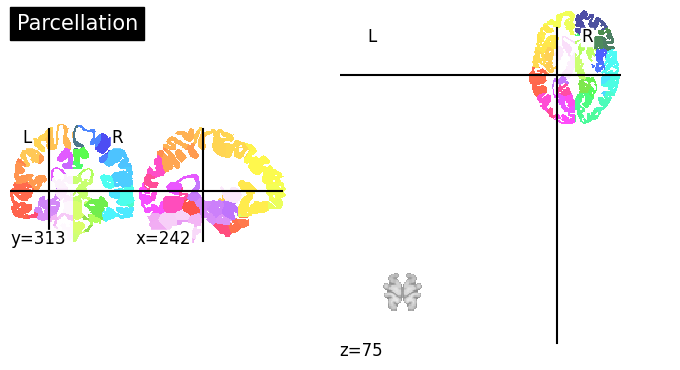

In [110]:
parc_path = "C:/Users/bigbr/Downloads/overlay0.nii.gz"

parc_img = nib.load(parc_path)

# Access the data
parc_data = parc_img.get_fdata()

# Inspect the data
print(parc_data.shape)

plotting.plot_roi(parc_img, title="Parcellation", display_mode='ortho')

# Get unique region indices
unique_regions = np.unique(parc_data)
print("Unique regions in the parcellation image:", unique_regions)


## Timeseries Creation

In [55]:
# Seeing what participants are missing in the behavioral data so I can manually delete correct fMRI files
    # Done to make sure behavioral and neurological data line up    
# Duplicated output file from node timseries creation to keep original data format 

# Create a set of numbers from 1 to 50
reference_set = set(range(1, 51))

# Get the unique values from the 'numbers' column
unique_numbers = set(behav_data['Participant Number'])

# Find the missing number(s)
missing_numbers = sorted(reference_set - unique_numbers)

print("Missing number(s):", missing_numbers)

Missing number(s): [5, 6, 9, 15, 17, 19, 24, 43, 46]


### Nodewise Timeseries Creation

In [ ]:
# Creating node wise timeseries for after file 
# Annotations to name of subject paths occurred after running this block 
#  This was because the o.g. code was run as part of a tutorial and cleaning up annotation was done after 

# Creating a subject list running from S01-S50
subj_list = [f'S{i:02d}' for i in range(1, 51)] # List of subjects from S01-S50 

a_subj_paths = [os.path.join(data_dir, 'preproc_music_leor', 'after', subj) for subj in subj_list] # Creating a list of paths from S01-S50

# For each subject creating a csv file that contains timeseries at each 
for subj_path in a_subj_paths:
    # Creating a path for the csv file 
    time_series_fname = os.path.join(subj_path, 'nodeTimeSeries.csv')
    # Grabs the nifti image using os.path and then performs masker.fit_transform on nifti 
    # masker.fit_transform = Normalizes signal from niftii onto the parcellation defined by masker 
    time_series = masker.fit_transform(os.path.join(subj_path, 'after_music_rdsmffms6FWHM_bd_M_V_DV_WMlocal2_modecorr.nii.gz'))
    # Output of above function is put into a dataframe using pd.DataFrame
    pd.DataFrame(time_series).to_csv(time_series_fname, index=False)

In [59]:
# Creating node wise timeseries for before file 
# Creating a subject list running from S01-S50
b_subj_paths = [os.path.join(data_dir, 'preproc_music_leor', 'before', subj) for subj in subj_list] # Creating a list of paths from S01-S50

# For each subject creating a csv file that contains timeseries at eaach 
for subj_path in b_subj_paths:
    # Creating a path for the csv file 
    time_series_fname = os.path.join(subj_path, 'nodeTimeSeries.csv')
    # Grabs the nifti image using os.path and then performs masker.fit_transform on nifti 
    # masker.fit_transform = Normalizes signal from niftii onto the parcellation defined by masker 
    time_series = masker.fit_transform(os.path.join(subj_path, 'before_music_rdsmffms6FWHM_bd_M_V_DV_WMlocal2_modecorr.nii.gz'))
    # Output of above function is put into a dataframe using pd.DataFrame
    pd.DataFrame(time_series).to_csv(time_series_fname, index=False)

c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\joblib\memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


### Searchlight Timeseries (Not Implemented)

In [ ]:
# Creating searchlight timeseries for after file 
# Annotations to name of subject paths occurred after running this block 
#  This was because the o.g. code was run as part of a tutorial and cleaning up annotation was done after 
# Creating a subject list running from S01-S50
subj_list = [f'S{i:02d}' for i in range(1, 51)] # List of subjects from S01-S50 
a_subj_paths = [os.path.join(data_dir, 'preproc_music_leor', 'after', subj) for subj in subj_list] # Creating a list of paths from S01-S50

# For each subject creating a csv file that contains timeseries at each 
for subj_path in a_subj_paths:
    # Creating a path for the csv file 
    time_series_fname = os.path.join(subj_path, 'nodeTimeSeries.csv')
    # Grabs the nifti image using os.path and then performs masker.fit_transform on nifti 
    # masker.fit_transform = Normalizes signal from niftii onto the parcellation defined by masker 
    time_series = masker.fit_transform(os.path.join(subj_path, 'after_music_rdsmffms6FWHM_bd_M_V_DV_WMlocal2_modecorr.nii.gz'))
    # Output of above function is put into a dataframe using pd.DataFrame
    pd.DataFrame(time_series).to_csv(time_series_fname, index=False)

In [ ]:
# Creating searchlight timeseries for before file 
# Creating a subject list running from S01-S50
b_subj_paths = [os.path.join(data_dir, 'preproc_music_leor', 'before', subj) for subj in subj_list] # Creating a list of paths from S01-S50

# For each subject creating a csv file that contains timeseries at eaach 
for subj_path in b_subj_paths:
    # Creating a path for the csv file 
    time_series_fname = os.path.join(subj_path, 'nodeTimeSeries.csv')
    # Grabs the nifti image using os.path and then performs masker.fit_transform on nifti 
    # masker.fit_transform = Normalizes signal from niftii onto the parcellation defined by masker 
    time_series = masker.fit_transform(os.path.join(subj_path, 'before_music_rdsmffms6FWHM_bd_M_V_DV_WMlocal2_modecorr.nii.gz'))
    # Output of above function is put into a dataframe using pd.DataFrame
    pd.DataFrame(time_series).to_csv(time_series_fname, index=False)

In [ ]:
#searchlight_masker = NiftiSpheresMasker(seeds, radius=smoothing, standardize=False, allow_overlap=True)
#        searchlight_time_series = searchlight_masker.fit_transform(nifti_file_path)
#        searchlight_time_series = searchlight_time_series[5:,:]
#
#        pd.DataFrame(searchlight_time_series).to_csv(searchlight_time_series_fname, index=False)

## Creating conditions 

In [224]:
# Path creation to subject brain data 

# Create lists of participant numbers for ESC and PSI conditions
esc_participants = behav_data[behav_data['Condition'] == 'ESC']['Participant Number'].tolist()
psi_participants = behav_data[behav_data['Condition'] == 'PSI']['Participant Number'].tolist()

# Initialize lists to store file paths for ESC and PSI conditions
esc_path = [] 
psi_path = []

# Iterate over the participant numbers and extract corresponding file paths
for i in esc_participants:
    participant = f'S{i:02d}'
    esc_path.append(os.path.join(data_dir, 'preproc_music_leor', 'before', participant))
    esc_path.append(os.path.join(data_dir, 'preproc_music_leor', 'after', participant))

for i in psi_participants:
    participant = f'S{i:02d}'
    psi_path.append(os.path.join(data_dir, 'preproc_music_leor', 'before', participant))
    psi_path.append(os.path.join(data_dir, 'preproc_music_leor', 'after', participant))



#### Parcellating fMRI data  
- Combining csv files into data frames 

In [225]:
# Basic conditions 

# Creating open data frames 
esc = []
esc_b = []
esc_a = []

# Combining node time series into diff. lists 
for subj in esc_path:
    sub_data = pd.read_csv(os.path.join(subj, 'nodeTimeSeries.csv'))
    esc.append(sub_data.values)
    # Check if data belongs to before and after lists 
    if 'before' in subj:
        esc_b.append(sub_data.values)
    elif 'after' in subj:
        esc_a.append(sub_data.values)

# converting the lists into numpy arrays 
esc = np.array(esc)
esc_b = np.array(esc_b)
esc_a = np.array(esc_a)

# Saving shape of each array 
esc_subs, esc_ts, esc_nodes = esc.shape
esc_b_subs, esc_b_ts, esc_b_nodes = esc_b.shape
esc_a_subs, esc_a_ts, esc_a_nodes = esc_a.shape

# Creating open data frames 
psi = []
psi_b = []
psi_a = []

for subj in psi_path:
    sub_data = pd.read_csv(os.path.join(subj, 'nodeTimeSeries.csv'))
    psi.append(sub_data.values)
    # Check if data belongs to before and after lists 
    if 'before' in subj:
        psi_b.append(sub_data.values)
    elif 'after' in subj:
        psi_a.append(sub_data.values)

# converting the lists into numpy arrays 
psi = np.array(psi)
psi_b = np.array(psi_b)
psi_a = np.array(psi_a)

# Saving shape of each array 
psi_subs, psi_ts, psi_nodes = psi.shape
psi_b_subs, psi_b_ts, psi_b_nodes = psi_b.shape
psi_a_subs, psi_a_ts, psi_a_nodes = psi_a.shape

del i, participant, subj, sub_data, psi_path, esc_path # Deleting variables for function for cleanliness 

##### Contrast Code creation

In [20]:
# Diff. b/w time of treatment 

# Couldn't directly compare conditions because different # of subjects

# PSI - ESC After
# ESC - PSI After 
# PSI - ESC Before 
# ESC - PSI Before 

# Within treatment comparison 

# After - Before ESC 
esc_ab = esc_a - esc_b
esc_ab_subs, esc_ab_ts, esc_ab_nodes = esc_ab.shape
# After - Before PSI 
psi_ab = psi_a - psi_b
psi_ab_subs, psi_ab_ts, psi_ab_nodes = psi_ab.shape
# Before - After PSI 
# Before - After ESC 




### ROI parcellation
- Combining text files into data frames 
- Difference in method here because timeseries were made before and were in a different format than original data 

In [12]:
# Creating dataframes for each condition

# NAC
nacc_esc = pd.DataFrame()
nacc_esc_b = pd.DataFrame()
nacc_esc_a = pd.DataFrame()

nacc_psi = pd.DataFrame()
nacc_psi_b = pd.DataFrame()
nacc_psi_a = pd.DataFrame()

# Loop through each ESC participant and condition
for condition, participants in [("ESC", esc_participants), ("PSI", psi_participants)]:
    for i in participants:
        participant = f'S{i:02d}'
        for cond in ['before', 'after']:
            filename = f"{participant}_nacc_timecourse_{cond}.txt"
            subj_path = os.path.join(data_dir, 'ROI_timecourses', 'nacc', filename)
            
            if os.path.isfile(subj_path):
                with open(subj_path, 'r') as file:
                    # Read the text file
                    sub_data = file.read().splitlines()
                    sub_data = [list(map(float, line.split())) for line in sub_data]

                    # Convert the data to a pandas DataFrame
                    df = pd.DataFrame(sub_data)
                    
                    # Set the participant ID as the column name
                    df.columns = [participant]
                    
                    if condition == 'ESC':
                        nacc_esc = pd.concat([nacc_esc, df], axis=1)  
                        if cond == 'before':
                            nacc_esc_b = pd.concat([nacc_esc_b, df], axis=1)  
                        elif cond == 'after':
                            nacc_esc_a = pd.concat([nacc_esc_a, df], axis=1)  
                    elif condition == 'PSI':
                        nacc_psi = pd.concat([nacc_psi, df], axis=1)
                        if cond == 'before':
                            nacc_psi_b = pd.concat([nacc_psi_b, df], axis=1)  
                        elif cond == 'after':
                            nacc_psi_a = pd.concat([nacc_psi_a, df], axis=1)  
            else:
                print(f"File not found: {subj_path}")
       
# STG 
stg_esc = pd.DataFrame()
stg_esc_b = pd.DataFrame()
stg_esc_a = pd.DataFrame()

stg_psi = pd.DataFrame()
stg_psi_b = pd.DataFrame()
stg_psi_a = pd.DataFrame()

# Loop through each ESC participant and condition
for condition, participants in [("ESC", esc_participants), ("PSI", psi_participants)]:
    for i in participants:
        participant = f'S{i:02d}'
        for cond in ['before', 'after']:
            filename = f"{participant}_stg_timecourse_{cond}.txt"
            subj_path = os.path.join(data_dir, 'ROI_timecourses', 'stg', filename)
            
            if os.path.isfile(subj_path):
                with open(subj_path, 'r') as file:
                    # Read the text file
                    sub_data = file.read().splitlines()
                    sub_data = [list(map(float, line.split())) for line in sub_data]

                    # Convert the data to a pandas DataFrame
                    df = pd.DataFrame(sub_data)
                    
                    # Set the participant ID as the column name
                    df.columns = [participant]
                    
                    if condition == 'ESC':
                        stg_esc = pd.concat([stg_esc, df], axis=1)
                        if cond == 'before':
                            stg_esc_b = pd.concat([stg_esc_b, df], axis=1)  # Concatenate with existing DataFrame
                        elif cond == 'after':
                            stg_esc_a = pd.concat([stg_esc_a, df], axis=1)  # Concatenate with existing DataFrame
                    elif condition == 'PSI':
                        stg_psi = pd.concat([stg_psi, df], axis=1)
                        if cond == 'before':
                            stg_psi_b = pd.concat([stg_psi_b, df], axis=1)  # Concatenate with existing DataFrame
                        elif cond == 'after':
                            stg_psi_a = pd.concat([stg_psi_a, df], axis=1)  # Concatenate with existing DataFrame
            else:
                print(f"File not found: {subj_path}")
# VmPFC 
vmpfc_esc = pd.DataFrame()
vmpfc_esc_b = pd.DataFrame()
vmpfc_esc_a = pd.DataFrame()

vmpfc_psi = pd.DataFrame()
vmpfc_psi_b = pd.DataFrame()
vmpfc_psi_a = pd.DataFrame()

# Loop through each ESC participant and condition
for condition, participants in [("ESC", esc_participants), ("PSI", psi_participants)]:
    for i in participants:
        participant = f'S{i:02d}'
        for cond in ['before', 'after']:
            filename = f"{participant}_vmpfc_timecourse_{cond}.txt"
            subj_path = os.path.join(data_dir, 'ROI_timecourses', 'vmpfc', filename)
            
            if os.path.isfile(subj_path):
                with open(subj_path, 'r') as file:
                    # Read the text file
                    sub_data = file.read().splitlines()
                    sub_data = [list(map(float, line.split())) for line in sub_data]

                    # Convert the data to a pandas DataFrame
                    df = pd.DataFrame(sub_data)
                    
                    # Set the participant ID as the column name
                    df.columns = [participant]
                    
                    if condition == 'ESC':
                        vmpfc_esc = pd.concat([vmpfc_esc, df], axis=1)
                        if cond == 'before':
                            vmpfc_esc_b = pd.concat([vmpfc_esc_b, df], axis=1)  # Concatenate with existing DataFrame
                        elif cond == 'after':
                            vmpfc_esc_a = pd.concat([vmpfc_esc_a, df], axis=1)  # Concatenate with existing DataFrame
                    elif condition == 'PSI':
                        vmpfc_psi = pd.concat([vmpfc_psi, df], axis=1)
                        if cond == 'before':
                            vmpfc_psi_b = pd.concat([vmpfc_psi_b, df], axis=1)  # Concatenate with existing DataFrame
                        elif cond == 'after':
                            vmpfc_psi_a = pd.concat([vmpfc_psi_a, df], axis=1)  # Concatenate with existing DataFrame
            else:
                print(f"File not found: {subj_path}")

##### Contrast Code creation

In [131]:
# Tested z-scoring and absolute values  

#nacc
znacc_esc_a = nacc_esc_a.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
znacc_esc_b = nacc_esc_b.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
znacc_psi_a = nacc_psi_a.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
znacc_psi_b = nacc_psi_b.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
#stg
zstg_esc_a = stg_esc_a.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
zstg_esc_b = stg_esc_b.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
zstg_psi_a = stg_psi_a.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
zstg_psi_b = stg_psi_b.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
#vmpfc
zvmpfc_esc_a = vmpfc_esc_a.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
zvmpfc_esc_b = vmpfc_esc_b.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
zvmpfc_psi_a = vmpfc_psi_a.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
zvmpfc_psi_b = vmpfc_psi_b.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# After - Before ESC 
nacc_esc_ab = nacc_esc_a - nacc_esc_b  
stg_esc_ab = stg_esc_a - stg_esc_b
vmpfc_esc_ab = vmpfc_esc_a - vmpfc_esc_b

# Z score after subtraction
aznacc_esc_ab = nacc_esc_ab.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
azstg_esc_ab = stg_esc_ab.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
azvmpfc_esc_ab = vmpfc_esc_ab.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# After - Before PSI 
nacc_psi_ab = nacc_psi_a - nacc_psi_b
stg_psi_ab = stg_psi_a - stg_psi_b
vmpfc_psi_ab = vmpfc_psi_a - vmpfc_psi_b

# Z Score after subtraction 
aznacc_psi_ab = nacc_psi_ab.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
azstg_psi_ab = stg_psi_ab.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
azvmpfc_psi_ab = vmpfc_psi_ab.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Z scored After - Before ESC 
znacc_esc_ab = znacc_esc_a - znacc_esc_b  
zstg_esc_ab = zstg_esc_a - zstg_esc_b
zvmpfc_esc_ab = zvmpfc_esc_a - zvmpfc_esc_b

# Z scored After - Before PSI 
znacc_psi_ab = znacc_psi_a - znacc_psi_b
zstg_psi_ab = zstg_psi_a - zstg_psi_b
zvmpfc_psi_ab = zvmpfc_psi_a - zvmpfc_psi_b

# Before - After PSI 
# Before - After ESC 

# Absolute Value After - Before PSI
abs_nacc_psi_ab = abs(nacc_psi_a - nacc_psi_b)
abs_stg_psi_ab = abs(stg_psi_a - stg_psi_b)
abs_vmpfc_psi_ab = abs(vmpfc_psi_a - vmpfc_psi_b)

# Absolute Value After - Before ESC 
abs_nacc_esc_ab = abs(nacc_esc_a - nacc_esc_b)  
abs_stg_esc_ab = abs(stg_esc_a - stg_esc_b)
abs_vmpfc_esc_ab = abs(vmpfc_esc_a - vmpfc_esc_b)


## Networks parcellation

In [99]:
# Creating file path/variable for node to network mapping 
# Node to network map downloaded from https://github.com/esfinn/intersubj_rsa/blob/master/xilin_268parc_labels.csv?plain=1

# Load network mapping file 
mapping_df = pd.read_csv("")
# Normal index -> 0-indexing 
mapping_df['Node'] = mapping_df['Node'] - 1

In [100]:
# Parcellating into networks 

esc_a_n = aggregate_timeseries_by_network(mapping_df, esc_a)
esc_b_n = aggregate_timeseries_by_network(mapping_df, esc_b)
esc_ab_n = aggregate_timeseries_by_network(mapping_df, esc_ab)

esc_n_subs, esc_n_ts, esc_n_networks = esc_a_n.shape

psi_a_n = aggregate_timeseries_by_network(mapping_df, psi_a)
psi_b_n = aggregate_timeseries_by_network(mapping_df, psi_b)
psi_ab_n = aggregate_timeseries_by_network(mapping_df, psi_ab)

psi_n_n_subs, psi_n_n_ts, psi_n_networks = psi_a_n.shape


# Behavioral Matrix Creation
- Everything is ranked because I am looking at how participants relate to each other 
- Arousal, valence and BDI are created here but not used in more analysis as they were not variables of interest 

In [ ]:
# Pulling variables of interest from behavioral data 

psi_QIDS_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', "QIDS change (post-pre)"]
esc_QIDS_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', "QIDS change (post-pre)"]
psi_GEMS_tot_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', behav_data.columns[75]]
esc_GEMS_tot_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', behav_data.columns[75]]
psi_GEMS_subl_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', behav_data.columns[36]]
esc_GEMS_subl_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', behav_data.columns[36]]
psi_GEMS_vit_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', behav_data.columns[37]]
esc_GEMS_vit_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC',  behav_data.columns[37]]
psi_GEMS_une_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', behav_data.columns[38]]
esc_GEMS_une_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', behav_data.columns[38]]
psi_SHAPS_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', "SHAPS change"]
esc_SHAPS_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', "SHAPS change"]
psi_LEIS_behav = behav_data.loc[behav_data['Condition'] == 'PSI', "LEIS TOTAL"]
esc_LEIS_behav = behav_data.loc[behav_data['Condition'] == 'ESC', "LEIS TOTAL"]
psi_BDI_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', "BDI change (post-pre)"]
esc_BDI_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', "BDI change (post-pre)"]
psi_AIMS_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', "∆ post - pre"]
esc_AIMS_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', "∆ post - pre"]

# Organize into ESC and PSI conditions 
esc_behav_variable_names = [var_name for var_name in local_variables if var_name.endswith('behav') and var_name.startswith('esc')]
psi_behav_variable_names = [var_name for var_name in local_variables if var_name.endswith('behav') and var_name.startswith('psi')]

## AnnaK

### QIDS // Full Annotation

Text(0.5, 1.0, 'Behavioral similarity matrix after sorting')

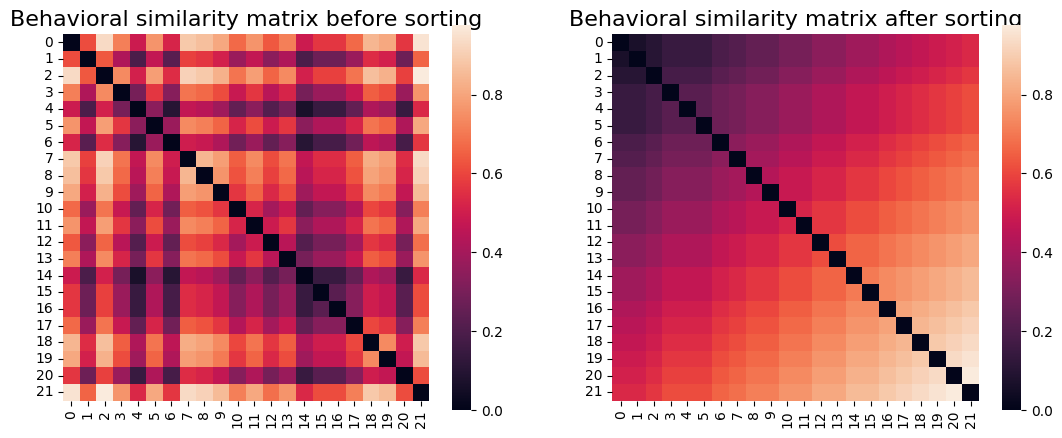

In [14]:
# PSI QIDS Post-Pre // Setup Instructions 

# Getting scores for a test
psi_QIDS_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', "QIDS change (post-pre)"]
# Ranking raw scores 
#  rankdata deals with identical scores 
psi_QIDS_c_behav = rankdata(psi_QIDS_c_behav) 
# Creating behavioral similarity matrix 

# Create empty subject-by-subject matrix 
# Using psi_ab_subs because it has the proper shape. Doesn't matter which psi_* basic subs since they all have the same # of subjects 
psi_QIDS_c_annak = np.zeros((psi_ab_subs, psi_ab_subs))

# Calculating behavioral similarity matrix 
# i and j since there is two sides to the matrix 
for i in range(psi_ab_subs):
    for j in range(psi_ab_subs):
        # Ensures matrix is only calc. once  
        if i < j:
            # Calc. mean of the 2 subjects rank and normalize by divide per subject 
            sim_ij = np.mean([psi_QIDS_c_behav[i], psi_QIDS_c_behav[j]])/psi_ab_subs
            # Adding above value to both sides of matrix since symmetry
            psi_QIDS_c_annak[i,j] = sim_ij
            psi_QIDS_c_annak[j,i] = sim_ij
        # i == j means same subject comparision therefore perfectly similar i.e. 1 
        elif i==j:
            psi_QIDS_c_annak[i,j] = 1

# Vectorizes the matrix we just appended from calc. 
psi_QIDS_c_annak = Adjacency(psi_QIDS_c_annak, matrix_type='similarity')

# Viewing behavioral similarity matrix
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
psi_QIDS_c_annak.plot(axes=ax1)
ax1.set_title("Behavioral similarity matrix before sorting", fontsize=16)

sns.heatmap(sort_square_mtx(psi_QIDS_c_annak.squareform(), psi_QIDS_c_behav), ax = ax2, square=True)
ax2.set_title("Behavioral similarity matrix after sorting", fontsize=16)

In [15]:
# ESC QIDS Post-Pre 

# Getting scores for a test
esc_QIDS_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', "QIDS change (post-pre)"]
esc_QIDS_c_behav = rankdata(esc_QIDS_c_behav) 

# Create empty subject-by-subject matrix 
esc_QIDS_c_annak = np.zeros((esc_ab_subs, esc_ab_subs))

# Calculating behavioral similarity matrix  
for i in range(esc_ab_subs):
    for j in range(esc_ab_subs):
        if i < j:
            sim_ij = np.mean([esc_QIDS_c_behav[i], esc_QIDS_c_behav[j]])/esc_ab_subs
            esc_QIDS_c_annak[i,j] = sim_ij
            esc_QIDS_c_annak[j,i] = sim_ij
        elif i==j:
            esc_QIDS_c_annak[i,j] = 1

# Vectorizes the matrix we just appended from calc. 
esc_QIDS_c_annak = Adjacency(esc_QIDS_c_annak, matrix_type='similarity')

### GEMS

In [29]:
# PSI GEMS total change
# Full annotation on QIDS
 
psi_GEMS_tot_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', behav_data.columns[75]]
psi_GEMS_tot_c_behav = rankdata(psi_GEMS_tot_c_behav) 

psi_GEMS_tot_c_annak = np.zeros((psi_ab_subs, psi_ab_subs))
for i in range(psi_ab_subs):
    for j in range(psi_ab_subs):
        if i < j:
            sim_ij = np.mean([psi_GEMS_tot_c_behav[i], psi_GEMS_tot_c_behav[j]])/psi_ab_subs
            psi_GEMS_tot_c_annak[i,j] = sim_ij
            psi_GEMS_tot_c_annak[j,i] = sim_ij
        elif i==j:
            psi_GEMS_tot_c_annak[i,j] = 1

psi_GEMS_tot_c_annak = Adjacency(psi_GEMS_tot_c_annak, matrix_type='similarity')

In [20]:
# ESC GEMS total change
# What each line does is at beginning of Behavioral Matrix Creation     
 
esc_GEMS_tot_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', behav_data.columns[75]]
esc_GEMS_tot_c_behav = rankdata(esc_GEMS_tot_c_behav) 

esc_GEMS_tot_c_annak = np.zeros((esc_ab_subs, esc_ab_subs))
for i in range(esc_ab_subs):
    for j in range(esc_ab_subs):
        if i < j:
            sim_ij = np.mean([esc_GEMS_tot_c_behav[i], esc_GEMS_tot_c_behav[j]])/esc_ab_subs
            esc_GEMS_tot_c_annak[i,j] = sim_ij
            esc_GEMS_tot_c_annak[j,i] = sim_ij
        elif i==j:
            esc_GEMS_tot_c_annak[i,j] = 1

esc_GEMS_tot_c_annak = Adjacency(esc_GEMS_tot_c_annak, matrix_type='similarity')

#### GEMS Facets

In [ ]:
# PSI GEMS sublimity change
# Full annotation on QIDS

psi_GEMS_subl_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', behav_data.columns[36]]
psi_GEMS_subl_c_behav = rankdata(psi_GEMS_subl_c_behav) 

psi_GEMS_subl_c_annak = np.zeros((psi_ab_subs, psi_ab_subs))
for i in range(psi_ab_subs):
    for j in range(psi_ab_subs):
        if i < j:
            sim_ij = np.mean([psi_GEMS_subl_c_behav[i], psi_GEMS_subl_c_behav[j]])/psi_ab_subs
            psi_GEMS_subl_c_annak[i,j] = sim_ij
            psi_GEMS_subl_c_annak[j,i] = sim_ij
        elif i==j:
            psi_GEMS_subl_c_annak[i,j] = 1

psi_GEMS_subl_c_annak = Adjacency(psi_GEMS_subl_c_annak, matrix_type='similarity')

In [24]:
# ESC GEMS sublimity change
# Full annotation on QIDS
 
esc_GEMS_subl_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', behav_data.columns[36]]
esc_GEMS_subl_c_behav = rankdata(esc_GEMS_subl_c_behav) 

esc_GEMS_subl_c_annak = np.zeros((esc_ab_subs, esc_ab_subs))
for i in range(esc_ab_subs):
    for j in range(esc_ab_subs):
        if i < j:
            sim_ij = np.mean([esc_GEMS_subl_c_behav[i], esc_GEMS_subl_c_behav[j]])/esc_ab_subs
            esc_GEMS_subl_c_annak[i,j] = sim_ij
            esc_GEMS_subl_c_annak[j,i] = sim_ij
        elif i==j:
            esc_GEMS_subl_c_annak[i,j] = 1

esc_GEMS_subl_c_annak = Adjacency(esc_GEMS_subl_c_annak, matrix_type='similarity')

In [ ]:
# PSI GEMS vitality change
# Full annotation on QIDS
 
psi_GEMS_vit_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', behav_data.columns[37]]
psi_GEMS_vit_c_behav = rankdata(psi_GEMS_vit_c_behav) 

psi_GEMS_vit_c_annak = np.zeros((psi_ab_subs, psi_ab_subs))
for i in range(psi_ab_subs):
    for j in range(psi_ab_subs):
        if i < j:
            sim_ij = np.mean([psi_GEMS_vit_c_behav[i], psi_GEMS_vit_c_behav[j]])/psi_ab_subs
            psi_GEMS_vit_c_annak[i,j] = sim_ij
            psi_GEMS_vit_c_annak[j,i] = sim_ij
        elif i==j:
            psi_GEMS_vit_c_annak[i,j] = 1

psi_GEMS_vit_c_annak = Adjacency(psi_GEMS_vit_c_annak, matrix_type='similarity')


In [26]:
# ESC GEMS vitality change
# Full annotation on QIDS
 
esc_GEMS_vit_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC',  behav_data.columns[37]]
esc_GEMS_vit_c_behav = rankdata(esc_GEMS_vit_c_behav) 

esc_GEMS_vit_c_annak = np.zeros((esc_ab_subs, esc_ab_subs))
for i in range(esc_ab_subs):
    for j in range(esc_ab_subs):
        if i < j:
            sim_ij = np.mean([esc_GEMS_vit_c_behav[i], esc_GEMS_vit_c_behav[j]])/esc_ab_subs
            esc_GEMS_vit_c_annak[i,j] = sim_ij
            esc_GEMS_vit_c_annak[j,i] = sim_ij
        elif i==j:
            esc_GEMS_vit_c_annak[i,j] = 1

esc_GEMS_vit_c_annak = Adjacency(esc_GEMS_vit_c_annak, matrix_type='similarity')

In [ ]:
# PSI GEMS unease change
# Full annotation on QIDS
 
psi_GEMS_une_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', behav_data.columns[38]]
psi_GEMS_une_c_behav = rankdata(psi_GEMS_une_c_behav) 

psi_GEMS_une_c_annak = np.zeros((psi_ab_subs, psi_ab_subs))
for i in range(psi_ab_subs):
    for j in range(psi_ab_subs):
        if i < j:
            sim_ij = np.mean([psi_GEMS_une_c_behav[i], psi_GEMS_une_c_behav[j]])/psi_ab_subs
            psi_GEMS_une_c_annak[i,j] = sim_ij
            psi_GEMS_une_c_annak[j,i] = sim_ij
        elif i==j:
            psi_GEMS_une_c_annak[i,j] = 1

psi_GEMS_une_c_annak = Adjacency(psi_GEMS_une_c_annak, matrix_type='similarity')

In [ ]:
# ESC GEMS unease change
# Full annotation on QIDS
 
esc_GEMS_une_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', behav_data.columns[38]]
esc_GEMS_une_c_behav = rankdata(esc_GEMS_une_c_behav) 

esc_GEMS_une_c_annak = np.zeros((esc_ab_subs, esc_ab_subs))
for i in range(esc_ab_subs):
    for j in range(esc_ab_subs):
        if i < j:
            sim_ij = np.mean([esc_GEMS_une_c_behav[i], esc_GEMS_une_c_behav[j]])/esc_ab_subs
            esc_GEMS_une_c_annak[i,j] = sim_ij
            esc_GEMS_une_c_annak[j,i] = sim_ij
        elif i==j:
            esc_GEMS_une_c_annak[i,j] = 1

esc_GEMS_une_c_annak = Adjacency(esc_GEMS_une_c_annak, matrix_type='similarity')

### SHAPS

In [ ]:
# PSI SHAPS change
# Full annotation on QIDS
 
psi_SHAPS_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', "SHAPS change"]
psi_SHAPS_c_behav = rankdata(psi_SHAPS_c_behav) 

psi_SHAPS_c_annak = np.zeros((psi_ab_subs, psi_ab_subs))
for i in range(psi_ab_subs):
    for j in range(psi_ab_subs):
        if i < j:
            sim_ij = np.mean([psi_SHAPS_c_behav[i], psi_SHAPS_c_behav[j]])/psi_ab_subs
            psi_SHAPS_c_annak[i,j] = sim_ij
            psi_SHAPS_c_annak[j,i] = sim_ij
        elif i==j:
            psi_SHAPS_c_annak[i,j] = 1

psi_SHAPS_c_annak = Adjacency(psi_SHAPS_c_annak, matrix_type='similarity')

In [ ]:
# ESC SHAPS change
# Full annotation on QIDS
 
esc_SHAPS_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', "SHAPS change"]
esc_SHAPS_c_behav = rankdata(esc_SHAPS_c_behav) 

esc_SHAPS_c_annak = np.zeros((esc_ab_subs, esc_ab_subs))
for i in range(esc_ab_subs):
    for j in range(esc_ab_subs):
        if i < j:
            sim_ij = np.mean([esc_SHAPS_c_behav[i], esc_SHAPS_c_behav[j]])/esc_ab_subs
            esc_SHAPS_c_annak[i,j] = sim_ij
            esc_SHAPS_c_annak[j,i] = sim_ij
        elif i==j:
            esc_SHAPS_c_annak[i,j] = 1

esc_SHAPS_c_annak = Adjacency(esc_SHAPS_c_annak, matrix_type='similarity')

### LEIS

In [ ]:
# PSI LEIS 
# Full annotation on QIDS
 
psi_LEIS_behav = behav_data.loc[behav_data['Condition'] == 'PSI', "LEIS TOTAL"]
psi_LEIS_behav = rankdata(psi_LEIS_behav) 

psi_LEIS_annak = np.zeros((psi_ab_subs, psi_ab_subs))
for i in range(psi_ab_subs):
    for j in range(psi_ab_subs):
        if i < j:
            sim_ij = np.mean([psi_LEIS_behav[i], psi_LEIS_behav[j]])/psi_ab_subs
            psi_LEIS_annak[i,j] = sim_ij
            psi_LEIS_annak[j,i] = sim_ij
        elif i==j:
            psi_LEIS_annak[i,j] = 1

psi_LEIS_annak = Adjacency(psi_LEIS_annak, matrix_type='similarity')

In [ ]:
# ESC LEIS 
# Full annotation on QIDS
 
esc_LEIS_behav = behav_data.loc[behav_data['Condition'] == 'ESC', "LEIS TOTAL"]
esc_LEIS_behav = rankdata(esc_LEIS_behav) 

esc_LEIS_annak = np.zeros((esc_ab_subs, esc_ab_subs))
for i in range(esc_ab_subs):
    for j in range(esc_ab_subs):
        if i < j:
            sim_ij = np.mean([esc_LEIS_behav[i], esc_LEIS_behav[j]])/esc_ab_subs
            esc_LEIS_annak[i,j] = sim_ij
            esc_LEIS_annak[j,i] = sim_ij
        elif i==j:
            esc_LEIS_annak[i,j] = 1

esc_LEIS_annak = Adjacency(esc_LEIS_annak, matrix_type='similarity')

### BDI

In [ ]:
# PSI BDI change
# Full annotation on QIDS
 
psi_BDI_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', "BDI change (post-pre)"]
psi_BDI_c_behav = rankdata(psi_BDI_c_behav) 

psi_BDI_c_annak = np.zeros((psi_ab_subs, psi_ab_subs))
for i in range(psi_ab_subs):
    for j in range(psi_ab_subs):
        if i < j:
            sim_ij = np.mean([psi_BDI_c_behav[i], psi_BDI_c_behav[j]])/psi_ab_subs
            psi_BDI_c_annak[i,j] = sim_ij
            psi_BDI_c_annak[j,i] = sim_ij
        elif i==j:
            psi_BDI_c_annak[i,j] = 1

psi_BDI_c_annak = Adjacency(psi_BDI_c_annak, matrix_type='similarity')

In [ ]:
# ESC BDI change
# Full annotation on QIDS
 
esc_BDI_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', "BDI change (post-pre)"]
esc_BDI_c_behav = rankdata(esc_BDI_c_behav) 

esc_BDI_c_annak = np.zeros((esc_ab_subs, esc_ab_subs))
for i in range(esc_ab_subs):
    for j in range(esc_ab_subs):
        if i < j:
            sim_ij = np.mean([esc_BDI_c_behav[i], esc_BDI_c_behav[j]])/esc_ab_subs
            esc_BDI_c_annak[i,j] = sim_ij
            esc_BDI_c_annak[j,i] = sim_ij
        elif i==j:
            esc_BDI_c_annak[i,j] = 1

esc_BDI_c_annak = Adjacency(esc_BDI_c_annak, matrix_type='similarity')

### AIMS

In [ ]:
# PSI AIMS change
# Full annotation on QIDS
 
psi_AIMS_c_behav = behav_data.loc[behav_data['Condition'] == 'PSI', "∆ post - pre"]
psi_AIMS_c_behav = rankdata(psi_AIMS_c_behav) 

psi_AIMS_c_annak = np.zeros((psi_ab_subs, psi_ab_subs))
for i in range(psi_ab_subs):
    for j in range(psi_ab_subs):
        if i < j:
            sim_ij = np.mean([psi_AIMS_c_behav[i], psi_AIMS_c_behav[j]])/psi_ab_subs
            psi_AIMS_c_annak[i,j] = sim_ij
            psi_AIMS_c_annak[j,i] = sim_ij
        elif i==j:
            psi_AIMS_c_annak[i,j] = 1

psi_AIMS_c_annak = Adjacency(psi_AIMS_c_annak, matrix_type='similarity')

In [ ]:
# ESC AIMS change
# Full annotation on QIDS
 
esc_AIMS_c_behav = behav_data.loc[behav_data['Condition'] == 'ESC', "∆ post - pre"]
esc_AIMS_c_behav = rankdata(esc_AIMS_c_behav) 

esc_AIMS_c_annak = np.zeros((esc_ab_subs, esc_ab_subs))
for i in range(esc_ab_subs):
    for j in range(esc_ab_subs):
        if i < j:
            sim_ij = np.mean([esc_AIMS_c_behav[i], esc_AIMS_c_behav[j]])/esc_ab_subs
            esc_AIMS_c_annak[i,j] = sim_ij
            esc_AIMS_c_annak[j,i] = sim_ij
        elif i==j:
            esc_AIMS_c_annak[i,j] = 1

esc_AIMS_c_annak = Adjacency(esc_AIMS_c_annak, matrix_type='similarity')

### Arousal

In [ ]:
# Importing CSV files for Arousal/Valence and creating dataframes
# Dataframes for conditions  

aro_esc_pre = pd.DataFrame()
val_esc_pre = pd.DataFrame()

aro_psi_pre = pd.DataFrame()
val_psi_pre = pd.DataFrame()

aro_esc_post = pd.DataFrame()
val_esc_post = pd.DataFrame()

aro_psi_post = pd.DataFrame()
val_psi_post = pd.DataFrame()

# Define the conditions and treatment phases
conditions = ["Escitalopram", "Psilocybin"]
treatment_phases = ["V1", "V2"]

# Loop through each condition and treatment phase
for condition in conditions:
    for phase in treatment_phases:
        # Define the path to the Excel file
        excel_path = os.path.join(data_dir, 'emujoy', condition, 'Analysed', phase, '*.xlsx')
        
        # Get a list of all Excel files in the directory
        excel_files = glob.glob(excel_path)
        excel_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[0][1:]))

        
        # Loop through each Excel file
        for file in excel_files:
            
            # Extract participant ID from the filename (assuming filename format is 'P{participant_id}_V{phase}.xlsx')
            filename = os.path.basename(file)  # Get the filename from the full path
            participant_id = os.path.splitext(filename)[0].split('_')[0][1:]  # Extract participant ID
            # Add leading zeros to participant ID
            participant_id = f'P{int(participant_id):02}'


            # Read the Excel file
            df = pd.read_excel(file)
            
            # Separating data
            aro_data = df['Arousal']
            val_data = df['Valence']

            # Set the participant ID as the column name
            aro_data.name = f'{participant_id}'
            val_data.name = f'{participant_id}'

            # Concatenate the data to the corresponding DataFrame based on condition and treatment phase
            if condition == 'Escitalopram' and phase == 'V1':
                aro_esc_pre = pd.concat([aro_esc_pre, aro_data], axis=1)
                val_esc_pre = pd.concat([val_esc_pre, val_data], axis=1)
            elif condition == 'Escitalopram' and phase == 'V2':
                aro_esc_post = pd.concat([aro_esc_post, aro_data], axis=1)
                val_esc_post = pd.concat([val_esc_post, val_data], axis=1)
            elif condition == 'Psilocybin' and phase == 'V1':
                aro_psi_pre = pd.concat([aro_psi_pre, aro_data], axis=1)
                val_psi_pre = pd.concat([val_psi_pre, val_data], axis=1)
            elif condition == 'Psilocybin' and phase == 'V2':
                aro_psi_post = pd.concat([aro_psi_post, aro_data], axis=1)
                val_psi_post = pd.concat([val_psi_post, val_data], axis=1)




In [ ]:
val_esc_pre.head()

P01       P02  P03       P10       P14       P16       P18       P20  \
0  0.002493  0.000494  0.0  0.000916  0.000712 -0.228125  0.000353 -0.000734   
1  0.002991  0.000593  0.0  0.001040  0.000813 -0.248958  0.000403 -0.000823   
2  0.003489  0.000693  0.0  0.060417  0.000915 -0.262680  0.000452 -0.000911   
3  0.003987  0.000792  0.0  0.144167  0.001016 -0.275521  0.000502 -0.000999   
4  0.004485  0.000892  0.0  0.180521  0.056378 -0.276494  0.000551 -0.004167   

        P23       P25  P27       P29       P30       P35  P36  P38       P39  \
0  0.000741  0.000595  0.0 -0.001887  0.000450  0.124432  0.0  0.0  0.000000   
1  0.000820  0.000700  0.0 -0.001734  0.000509  0.153399  0.0  0.0  0.000000   
2  0.000900  0.000805  0.0 -0.001581  0.000568  0.163205  0.0  0.0  0.000000   
3  0.000979  0.000911  0.0 -0.001427  0.000627  0.195833  0.0  0.0  0.035911   
4  0.031042  0.001016  0.0 -0.001274  0.000686  0.213542  0.0  0.0  0.064156   

        P48       P50  
0 -0.001953  0.006786  
1 -0.022604  0.007402  
2  0.072083  0.008018  
3  0.125000  0.008634  
4  0.161328  0.009250

In [ ]:
# Create contrast codes 
aro_esc_ab = aro_esc_post - aro_esc_pre
val_esc_ab = val_esc_post - val_esc_pre

aro_psi_ab = aro_psi_post - aro_psi_pre
val_psi_ab = val_psi_post - val_psi_pre

In [ ]:
# Range of arousal

psi_aro_ran_behav = behav_data.loc[behav_data['Condition'] == 'PSI', behav_data.columns[50]]
psi_aro_ran_behav = rankdata(psi_aro_ran_behav) 

psi_aro_ran_annak = np.zeros((psi_ab_subs, psi_ab_subs))
for i in range(psi_ab_subs):
    for j in range(psi_ab_subs):
        if i < j:
            sim_ij = np.mean([psi_aro_ran_behav[i], psi_aro_ran_behav[j]])/psi_ab_subs
            psi_aro_ran_annak[i,j] = sim_ij
            psi_aro_ran_annak[j,i] = sim_ij
        elif i==j:
            psi_aro_ran_annak[i,j] = 1

psi_aro_ran_annak = Adjacency(psi_aro_ran_annak, matrix_type='similarity')


esc_aro_ran_behav = behav_data.loc[behav_data['Condition'] == 'ESC', behav_data.columns[50]]
esc_aro_ran_behav = rankdata(esc_aro_ran_behav) 

esc_aro_ran_annak = np.zeros((esc_ab_subs, esc_ab_subs))
for i in range(esc_ab_subs):
    for j in range(esc_ab_subs):
        if i < j:
            sim_ij = np.mean([esc_aro_ran_behav[i], esc_aro_ran_behav[j]])/esc_ab_subs
            esc_aro_ran_annak[i,j] = sim_ij
            esc_aro_ran_annak[j,i] = sim_ij
        elif i==j:
            esc_aro_ran_annak[i,j] = 1

esc_aro_ran_annak = Adjacency(esc_aro_ran_annak, matrix_type='similarity')

In [ ]:
# Create behavioral matrix for 3 different versions of arousal, before/after and diff. b/w 
    # Don't need to use AnnaK and NN since emujoy is 2D so using ISC pairwise to make it instead 

psi_aro_post_bmat = 1 - pairwise_distances(pd.DataFrame(aro_psi_post).T, metric='correlation') 
psi_aro_post_bmat = Adjacency(psi_aro_post_bmat)

psi_aro_pre_bmat = 1 - pairwise_distances(pd.DataFrame(aro_psi_pre).T, metric='correlation') 
psi_aro_pre_bmat = Adjacency(psi_aro_pre_bmat)

psi_aro_c_bmat = 1 - pairwise_distances(pd.DataFrame(aro_psi_ab).T, metric='correlation') 
psi_aro_c_bmat = Adjacency(psi_aro_c_bmat)

esc_aro_post_bmat = 1 - pairwise_distances(pd.DataFrame(aro_esc_post).T, metric='correlation') 
esc_aro_post_bmat = Adjacency(esc_aro_post_bmat)

esc_aro_pre_bmat = 1 - pairwise_distances(pd.DataFrame(aro_esc_pre).T, metric='correlation') 
esc_aro_pre_bmat = Adjacency(esc_aro_pre_bmat)

esc_aro_c_bmat = 1 - pairwise_distances(pd.DataFrame(aro_esc_ab).T, metric='correlation') 
esc_aro_c_bmat = Adjacency(esc_aro_c_bmat)
 

Text(0.5, 1.0, 'Behavioral similarity matrix before sorting')

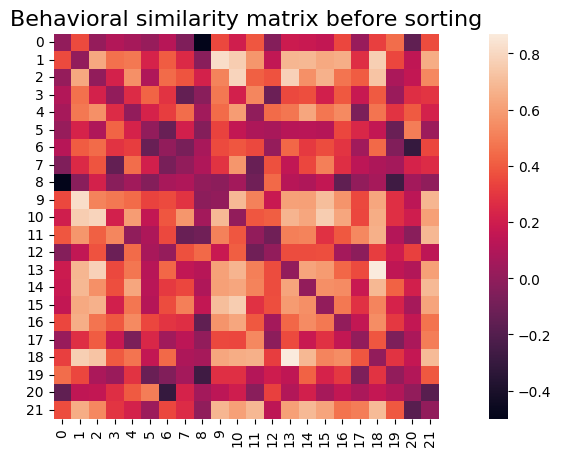

In [ ]:
# Visualizing to see if it worked
fig, ax1 = plt.subplots(figsize=(13,5))
psi_aro_post_bmat.plot(axes=ax1)
ax1.set_title("Behavioral similarity matrix before sorting", fontsize=16)


### Valence

In [ ]:
# Behavioral Matrix Creation
psi_val_post_bmat = 1 - pairwise_distances(pd.DataFrame(val_psi_post).T, metric='correlation') 
psi_val_post_bmat = Adjacency(psi_val_post_bmat)

psi_val_pre_bmat = 1 - pairwise_distances(pd.DataFrame(val_psi_pre).T, metric='correlation') 
psi_val_pre_bmat = Adjacency(psi_val_pre_bmat)

psi_val_c_bmat = 1 - pairwise_distances(pd.DataFrame(val_psi_ab).T, metric='correlation') 
psi_val_c_bmat = Adjacency(psi_val_c_bmat)

esc_val_post_bmat = 1 - pairwise_distances(pd.DataFrame(val_esc_post).T, metric='correlation') 
esc_val_post_bmat = Adjacency(esc_val_post_bmat)

esc_val_pre_bmat = 1 - pairwise_distances(pd.DataFrame(val_esc_pre).T, metric='correlation') 
esc_val_pre_bmat = Adjacency(esc_val_pre_bmat)

esc_val_c_bmat = 1 - pairwise_distances(pd.DataFrame(val_esc_ab).T, metric='correlation') 
esc_val_c_bmat = Adjacency(esc_val_c_bmat)

In [ ]:
# Range of valence 

psi_val_ran_behav = behav_data.loc[behav_data['Condition'] == 'PSI', behav_data.columns[53]]
psi_val_ran_behav = rankdata(psi_val_ran_behav) 

psi_val_ran_annak = np.zeros((psi_ab_subs, psi_ab_subs))
for i in range(psi_ab_subs):
    for j in range(psi_ab_subs):
        if i < j:
            sim_ij = np.mean([psi_val_ran_behav[i], psi_val_ran_behav[j]])/psi_ab_subs
            psi_val_ran_annak[i,j] = sim_ij
            psi_val_ran_annak[j,i] = sim_ij
        elif i==j:
            psi_val_ran_annak[i,j] = 1

psi_val_ran_annak = Adjacency(psi_val_ran_annak, matrix_type='similarity')


esc_val_ran_behav = behav_data.loc[behav_data['Condition'] == 'ESC', behav_data.columns[53]]
esc_val_ran_behav = rankdata(esc_val_ran_behav) 

esc_val_ran_annak = np.zeros((esc_ab_subs, esc_ab_subs))
for i in range(esc_ab_subs):
    for j in range(esc_ab_subs):
        if i < j:
            sim_ij = np.mean([esc_val_ran_behav[i], esc_val_ran_behav[j]])/esc_ab_subs
            esc_val_ran_annak[i,j] = sim_ij
            esc_val_ran_annak[j,i] = sim_ij
        elif i==j:
            esc_val_ran_annak[i,j] = 1

esc_val_ran_annak = Adjacency(esc_val_ran_annak, matrix_type='similarity')

## NN
- Made a loop instead of a separate code block for each 

In [ ]:
# Calculating NN bmat for all variables ending with _behav 
 
# Get all local variables in the current namespace
local_variables = locals()

# Filter variables that end with '_p' and store their names in a list
behav_variable_names = [var_name for var_name in local_variables if var_name.endswith('_behav')]

# Calculate NN bmat
for var_name in behav_variable_names:
    base_name = var_name[:-6] # -6 to get rid of _behav ending of variable name 
    behav = local_variables[var_name] # Getting variable data from variable name 
    behav_nn = Adjacency(pairwise_distances(np.reshape(behav, (-1, 1)), metric='euclidean'), matrix_type='distance')
    behav_nn = behav_nn.distance_to_similarity() 
    local_variables[f'{base_name}_nn'] = behav_nn


Text(0.5, 1.0, 'Behavioral similarity matrix after sorting')

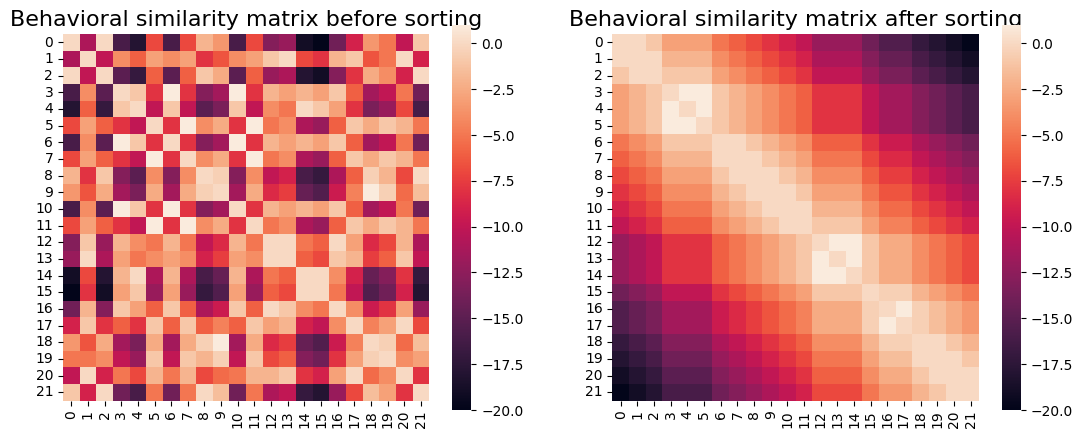

In [ ]:
# Viewing behavioral similarity matrix to make sure above worked
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
psi_BDI_c_nn.plot(axes=ax1)
ax1.set_title("Behavioral similarity matrix before sorting", fontsize=16)

sns.heatmap(sort_square_mtx(psi_BDI_c_nn.squareform(), psi_BDI_c_behav), ax = ax2, square=True)
ax2.set_title("Behavioral similarity matrix after sorting", fontsize=16)

In [40]:
# Calculating NN for average ISC method
# Different cause not a similarity matrix creation 

# Get all local variables in the current namespace
local_variables = locals()

# Filter variables that end with '_p' and store their names in a list
behav_variable_names = [var_name for var_name in local_variables if var_name.endswith('_behav')]

for var_name in behav_variable_names:
    
    base_name = var_name[:-6]  
    behav = local_variables[var_name]
    behav = np.array(behav)
    
    # Ranking behavioral data 
    scaler = StandardScaler()
    behav_scale = scaler.fit_transform(behav.reshape(-1, 1)).flatten()
    behav_rank = rankdata(behav_scale) 
    
    # Find k-nearest neighbors
    k = 5
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(behav_rank.reshape(-1, 1))
    distances, indices = nbrs.kneighbors(behav_rank.reshape(-1, 1))
    
    # Compute aggregated behavioral scores using nearest neighbors
    aggregated_scores = np.zeros_like(behav)
    for i in range(len(behav)):
        neighbors = behav[indices[i]]
        aggregated_scores[i] = np.mean(neighbors)
    
    std_dev = aggregated_scores.std()
    aggregated_similarities = np.exp(-aggregated_scores / std_dev)
    
    local_variables[f'{base_name}_nn_ave'] = aggregated_similarities

# ESC ISC


## After

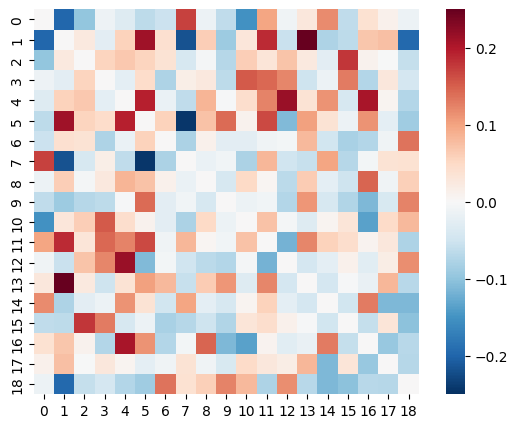

In [51]:
esc_a_smat = []
for node in range(esc_a_nodes):
    esc_a_smat.append(Adjacency(1 - pairwise_distances(esc_a[:, :, node], metric='correlation'), matrix_type='similarity'))
esc_a_smat = Adjacency(esc_a_smat)

# Visualize matrix 
esc_a_smat[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')

### Average

0.0033993201359728054
Node index 15:Right-FrontEyeFields (8), ISC Value: 0.0986138687835897
Node index 18:Right-ParsOrbitalis (47), ISC Value: 0.08070106859703616
Node index 19:Right-dlPFC(lat) (46), ISC Value: 0.07114278010825589
Node index 20:Right-Broca-Triang (45), ISC Value: 0.05096078779001698
Node index 21:Right-Broca-Operc (44), ISC Value: 0.07963571923965111
Node index 27:Right-PreMot+SuppMot (6), ISC Value: 0.05497790562017946
Node index 33:Right-PrimSensory (1), ISC Value: 0.07591103235911428
Node index 36:Right-Insula (13), ISC Value: 0.06565314589475729
Node index 39:Right-PrimSensory (1), ISC Value: 0.03448004568988335
Node index 45:Right-SupramargGyr (40), ISC Value: 0.20827525211973308
Node index 48:Right-AngGyrus (39), ISC Value: 0.057798653616531304
Node index 53:Right-Temporalpole (38), ISC Value: 0.0968704059277322
Node index 60:Right-InfTempGyrus (20), ISC Value: 0.30375497527358064
Node index 61:Right-PrimAuditory (41), ISC Value: 0.13289777548463316
Node index 62

c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



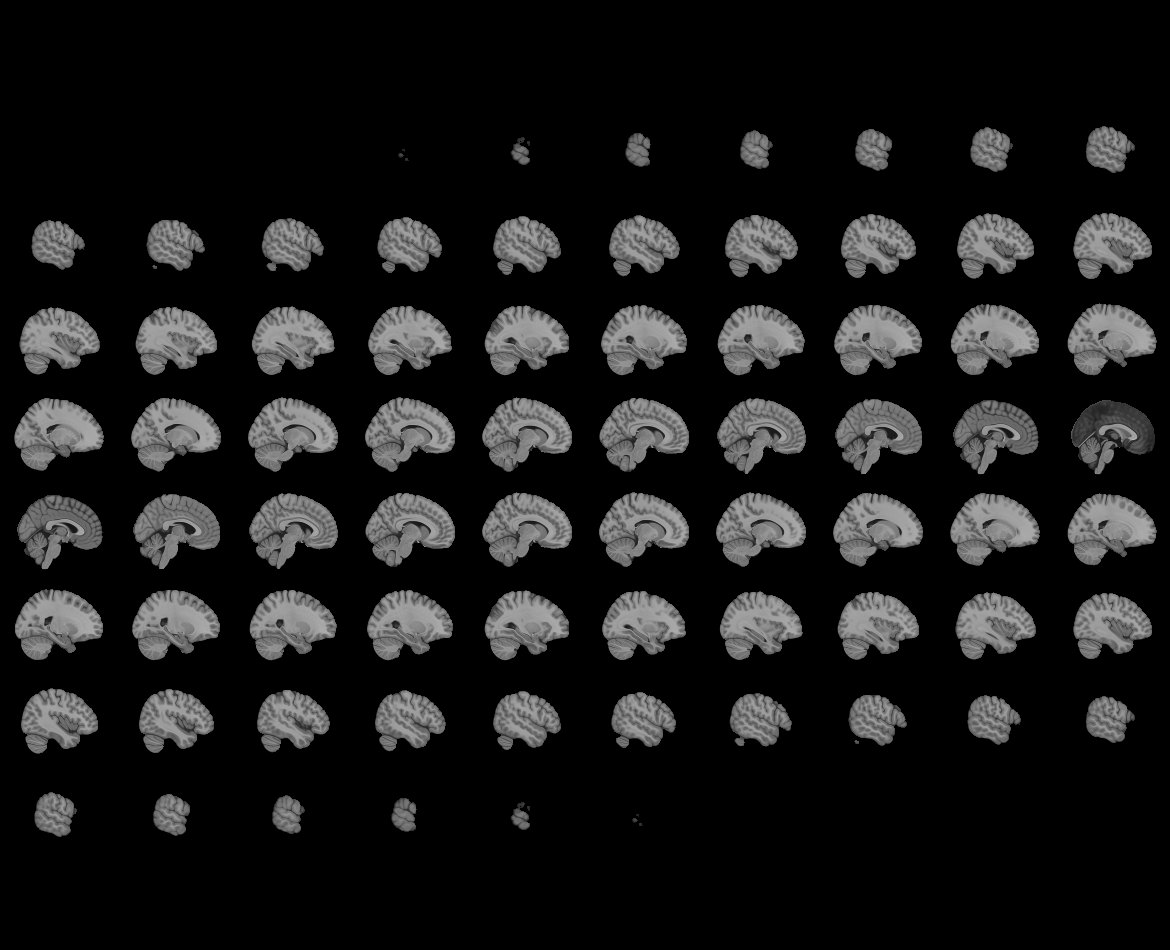
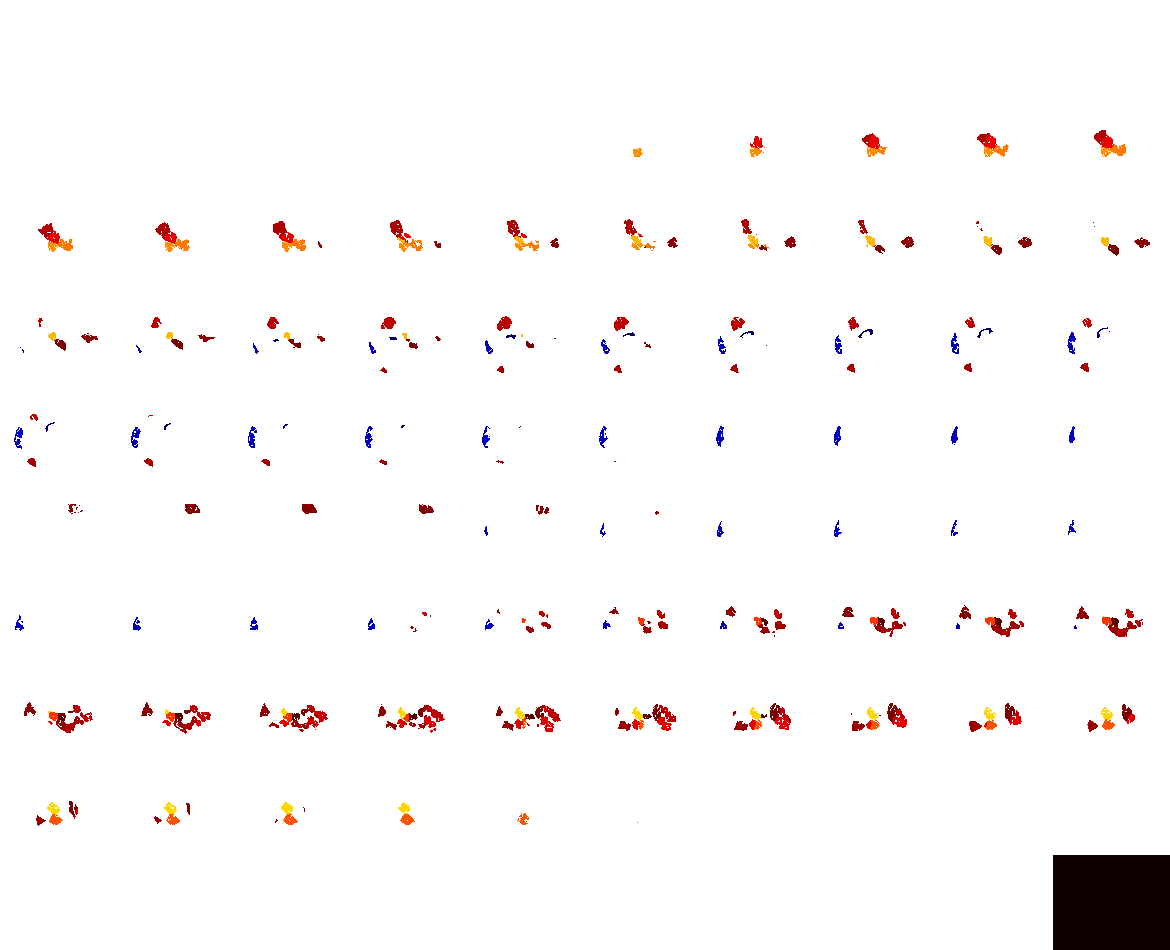

In [48]:
# Using Brainiak ISC

# Convert data to Brainiak format (ts x node x subject)
reshape_esc_a = np.transpose(esc_a, (1, 2, 0))

# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
esc_a_ave = b_isc(reshape_esc_a, pairwise=False)

esc_a_ave_isc, ci, esc_a_ave_p, distribution = b_bootstrap_isc(esc_a_ave, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median', 
                                              n_bootstraps= 5000)

fdr_thr = fdr(esc_a_ave_p)
print(fdr_thr)

# Assuming p is your numpy array of p-values
# Assuming fdr_thr is your FDR threshold value

# Create a boolean mask indicating which p-values are below the FDR threshold
surviving_nodes_mask = esc_a_ave_p <= fdr_thr

# Extract the indices of the nodes that survive the FDR threshold
surviving_nodes_indices = np.where(surviving_nodes_mask)[0]

# Optionally, extract the p-values of the surviving nodes
surviving_p_values = esc_a_ave_p[surviving_nodes_mask]

# Because of 0-index need to change the indices 
adjusted_indices = surviving_nodes_indices - 1

# Extract anatomical labels for the surviving nodes using list comprehension
surviving_labels = [ba_def[idx] for idx in adjusted_indices]

esc_a_s_nodes = {}

# Print the results along with ISC values
for idx in surviving_nodes_indices:
    # Use idx directly to access the anatomical label
    label = surviving_labels[np.where(surviving_nodes_indices == idx)[0][0]]  # Get the corresponding anatomical label
    isc_value = esc_a_ave_isc[idx]  # Get the ISC value for the node
    print(f"Node index {idx}:{label}, ISC Value: {isc_value}")
    esc_a_nodes[idx] = {'label': label, 'isc_value': isc_value}


esc_a_ave_isc, esc_a_ave_p = roi_to_brain(pd.Series(esc_a_ave_isc), expand_mask(mask)), roi_to_brain(pd.Series(esc_a_ave_p), expand_mask(mask))
view_img(threshold(esc_a_ave_isc, esc_a_ave_p, thr=fdr_thr).to_nifti(), draw_cross = False)



## Before 

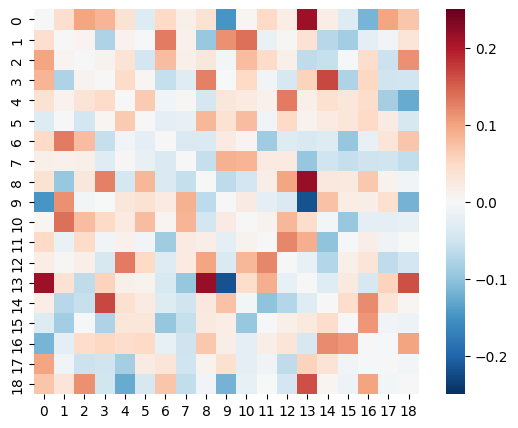

In [54]:
esc_b_smat = []
for node in range(esc_b_nodes):
    esc_b_smat.append(Adjacency(1 - pairwise_distances(esc_b[:, :, node], metric='correlation'), matrix_type='similarity'))
esc_b_smat = Adjacency(esc_b_smat)

# Visualize matrix 
esc_b_smat[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')

### Average

0.003999200159968006
Node index 21:Right-Broca-Operc (44), ISC Value: 0.08514662052263923
Node index 45:Right-SupramargGyr (40), ISC Value: 0.172388404346706
Node index 60:Right-InfTempGyrus (20), ISC Value: 0.3478119556636082
Node index 61:Right-PrimAuditory (41), ISC Value: 0.09485423677670048
Node index 62:Right-PrimAuditory (41), ISC Value: 0.140071245404008
Node index 64:Right-SupTempGyrus (22), ISC Value: 0.15021428770780093
Node index 91:Right-DorsalPCC (31), ISC Value: 0.054876709139171184
Node index 110:Cerebellum, ISC Value: -0.055377290628742935
Node index 117:Cerebellum, ISC Value: -0.03615943791406003
Node index 121:Right-Caudate, ISC Value: 0.03630379588001745
Node index 127:Right-Thalamus, ISC Value: 0.040309965044437374
Node index 159:Left-PreMot+SuppMot (6), ISC Value: 0.06461785332167919
Node index 162:Left-PreMot+SuppMot (6), ISC Value: 0.23613227698784137
Node index 169:Left-Insula (13), ISC Value: 0.05072968554315303
Node index 179:Left-SupramargGyr (40), ISC Value

c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



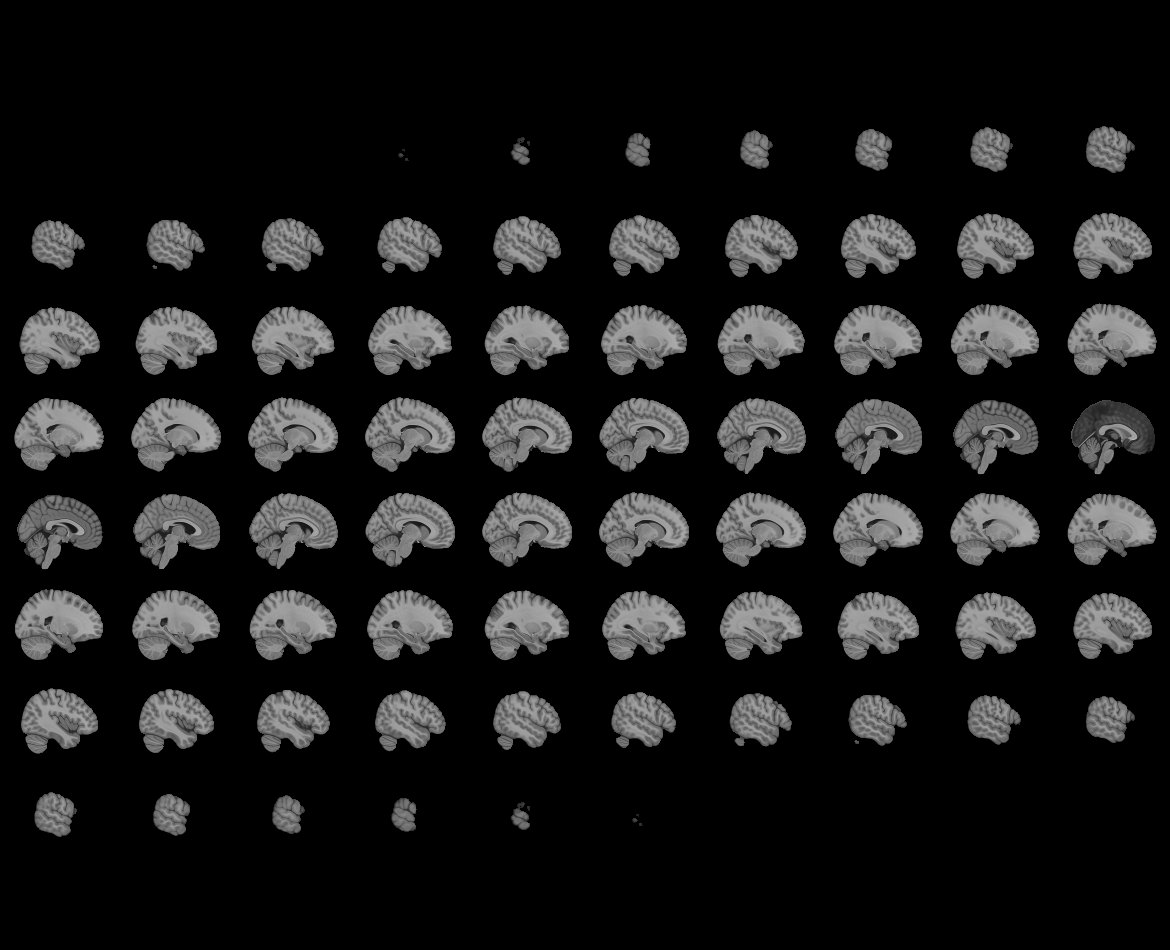
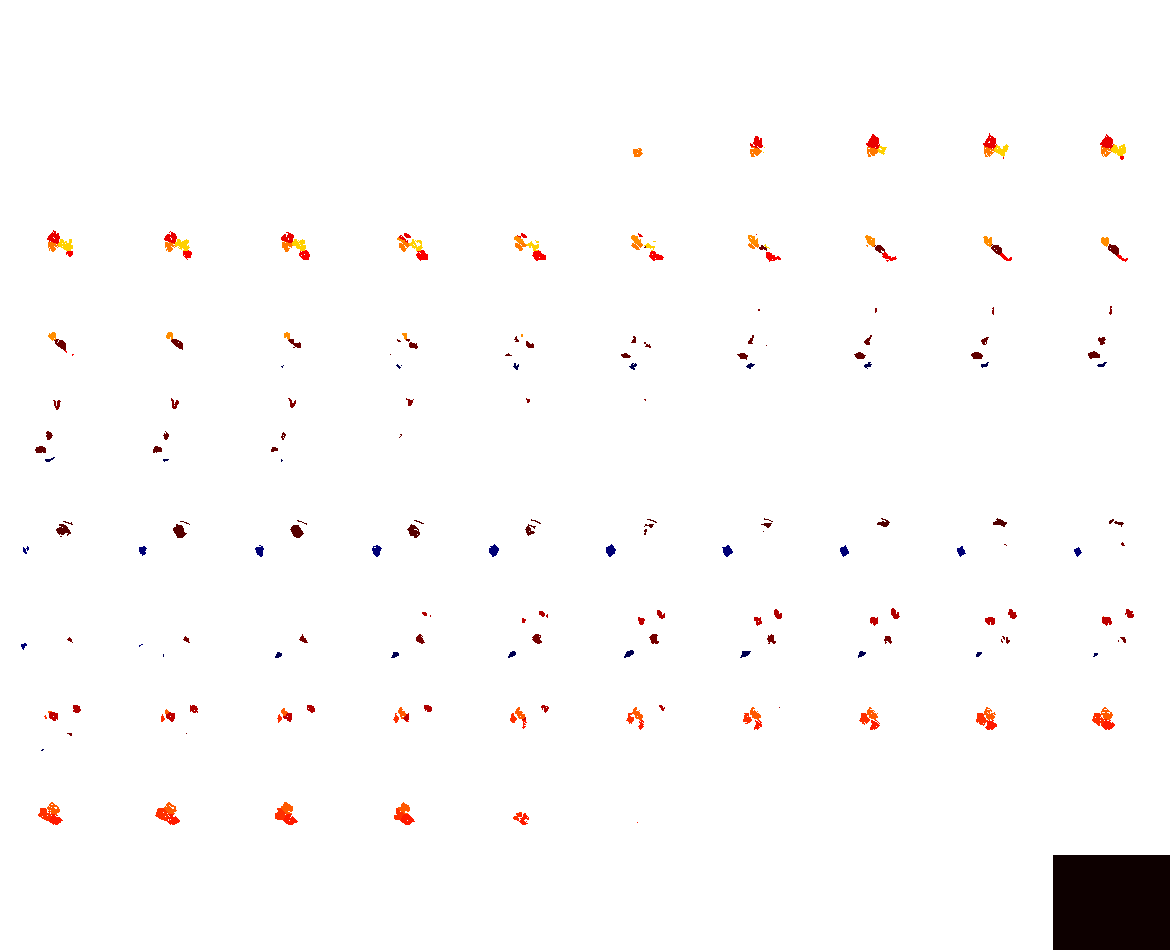

In [47]:
# Using Brainiak ISC

# Convert data to Brainiak format (ts x node x subject)
reshape_esc_b = np.transpose(esc_b, (1, 2, 0))

# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
esc_b_ave = b_isc(reshape_esc_b, pairwise=False)

esc_b_ave_isc, ci, esc_b_ave_p, distribution = b_bootstrap_isc(esc_b_ave, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median', 
                                              n_bootstraps= 5000)

fdr_thr = fdr(esc_b_ave_p)
print(fdr_thr)

# Assuming p is your numpy array of p-values
# Assuming fdr_thr is your FDR threshold value

# Create a boolean mask indicating which p-values are below the FDR threshold
surviving_nodes_mask = esc_b_ave_p <= fdr_thr

# Extract the indices of the nodes that survive the FDR threshold
surviving_nodes_indices = np.where(surviving_nodes_mask)[0]

# Optionally, extract the p-values of the surviving nodes
surviving_p_values = esc_b_ave_p[surviving_nodes_mask]

# Because of 0-index need to change the indices 
adjusted_indices = surviving_nodes_indices - 1

# Extract anatomical labels for the surviving nodes using list comprehension
surviving_labels = [ba_def[idx] for idx in adjusted_indices]

esc_b_s_nodes = {}

# Print the results along with ISC values
for idx in surviving_nodes_indices:
    # Use idx directly to access the anatomical label
    label = surviving_labels[np.where(surviving_nodes_indices == idx)[0][0]]  # Get the corresponding anatomical label
    isc_value = esc_b_ave_isc[idx]  # Get the ISC value for the node
    print(f"Node index {idx}:{label}, ISC Value: {isc_value}")
    esc_b_nodes[idx] = {'label': label, 'isc_value': isc_value}



esc_b_ave_isc, esc_b_ave_p = roi_to_brain(pd.Series(esc_b_ave_isc), expand_mask(mask)), roi_to_brain(pd.Series(esc_b_ave_p), expand_mask(mask))
view_img(threshold(esc_b_ave_isc, esc_b_ave_p, thr=fdr_thr).to_nifti(), draw_cross= False)

## After-Before 

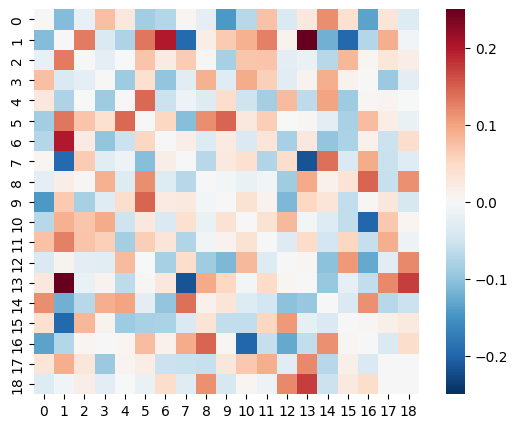

In [232]:
# Creates an empty list & creates similarity matrix
esc_ab_smat = []
for node in range(esc_ab_nodes):
    esc_ab_smat.append(Adjacency(1 - pairwise_distances(esc_ab[:, :, node], metric='correlation'), matrix_type='similarity'))
esc_ab_smat = Adjacency(esc_ab_smat)

# Visualize matrix 
esc_ab_smat[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')

-1


c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\nilearn\_utils\param_validation.py:73: UserWarning: The given float value must not exceed 0. But, you have given threshold=1e-06.
  f"The given float value must not exceed {value_check}. "
c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\nilearn\image\resampling.py:591: UserWarning: Casting data from int32 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\nilearn\plotting\find_cuts.py:67: UserWarning: Given img is empty. Returning default cu


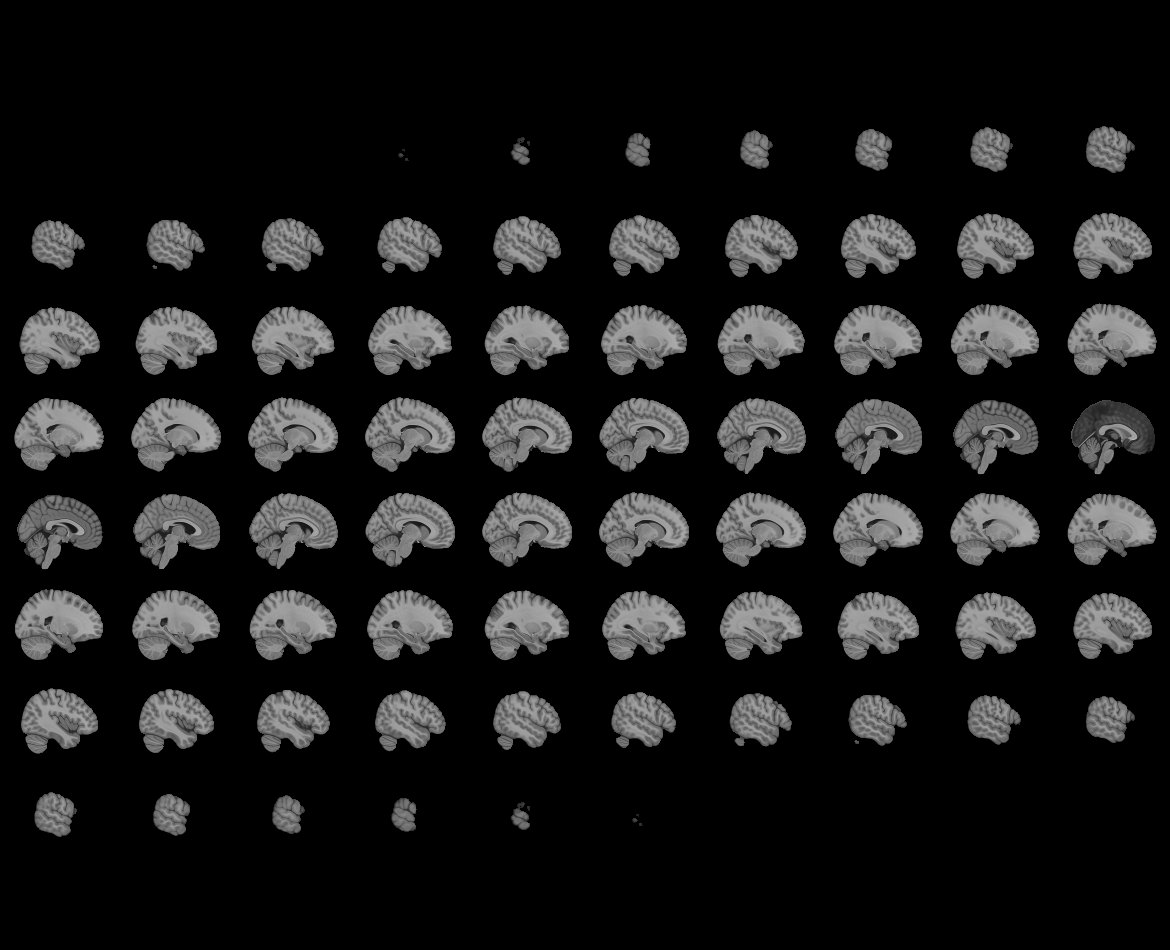
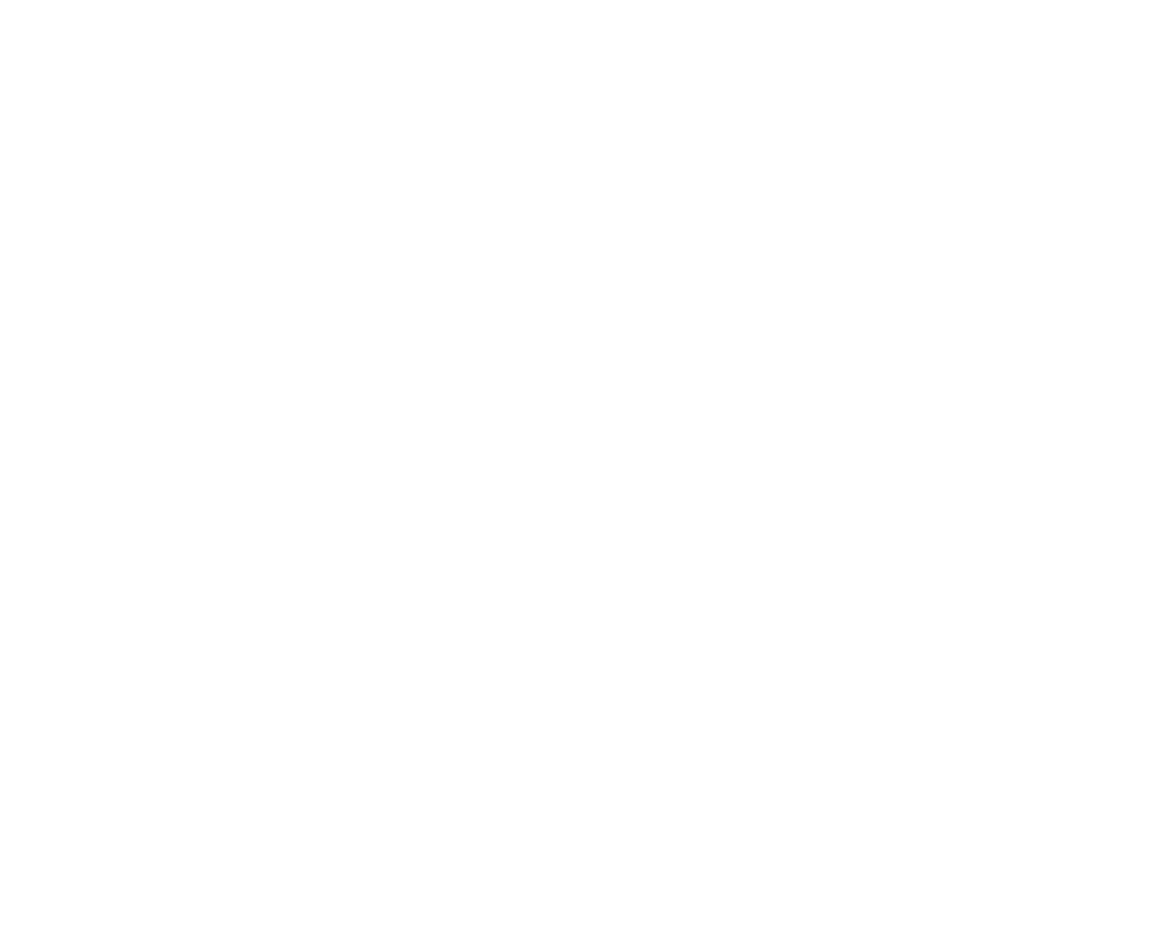

In [58]:
# trying median to see if it makes a diff. 
esc_ab_isc = {}
esc_ab_p_values = {}

for node in range(esc_ab_nodes):
    isc_result = esc_ab_smat[node].isc(metric='median', n_bootstraps=5000, n_jobs=1)
    esc_ab_isc[node] = isc_result['isc']
    esc_ab_p_values[node] = isc_result['p']

esc_ab_isc_brain, esc_ab_p_values_brain = roi_to_brain(pd.Series(esc_ab_isc), expand_mask(mask)), roi_to_brain(pd.Series(esc_ab_p_values), expand_mask(mask))

fdr_thr = fdr(pd.Series(esc_ab_p_values).values)
print(fdr_thr)

# Seeing which nodes are significant 

# Iterate over the p-values and print nodes that meet the threshold
for node, p_value in esc_ab_p_values.items():
    if p_value < fdr_thr:
        anatomical_label = ba_def[node]  # Change this if node is already 0-indexed
        print(f"Node: {anatomical_label}, p-value: {p_value}")

esc_ab_isc, esc_ab_p_values = roi_to_brain(pd.Series(esc_ab_isc), expand_mask(mask)), roi_to_brain(pd.Series(esc_ab_p_values), expand_mask(mask))
view_img(threshold(esc_ab_isc, esc_ab_p_values, thr=fdr_thr).to_nifti())

### Average 

0.0003999200159968006
Node index 127:Right-Thalamus, ISC Value: -0.05081400700954154
Node index 187:Left-Temporalpole (38), ISC Value: 0.033405960487239504
Node index 241:Cerebellum, ISC Value: -0.06686336264697039


c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



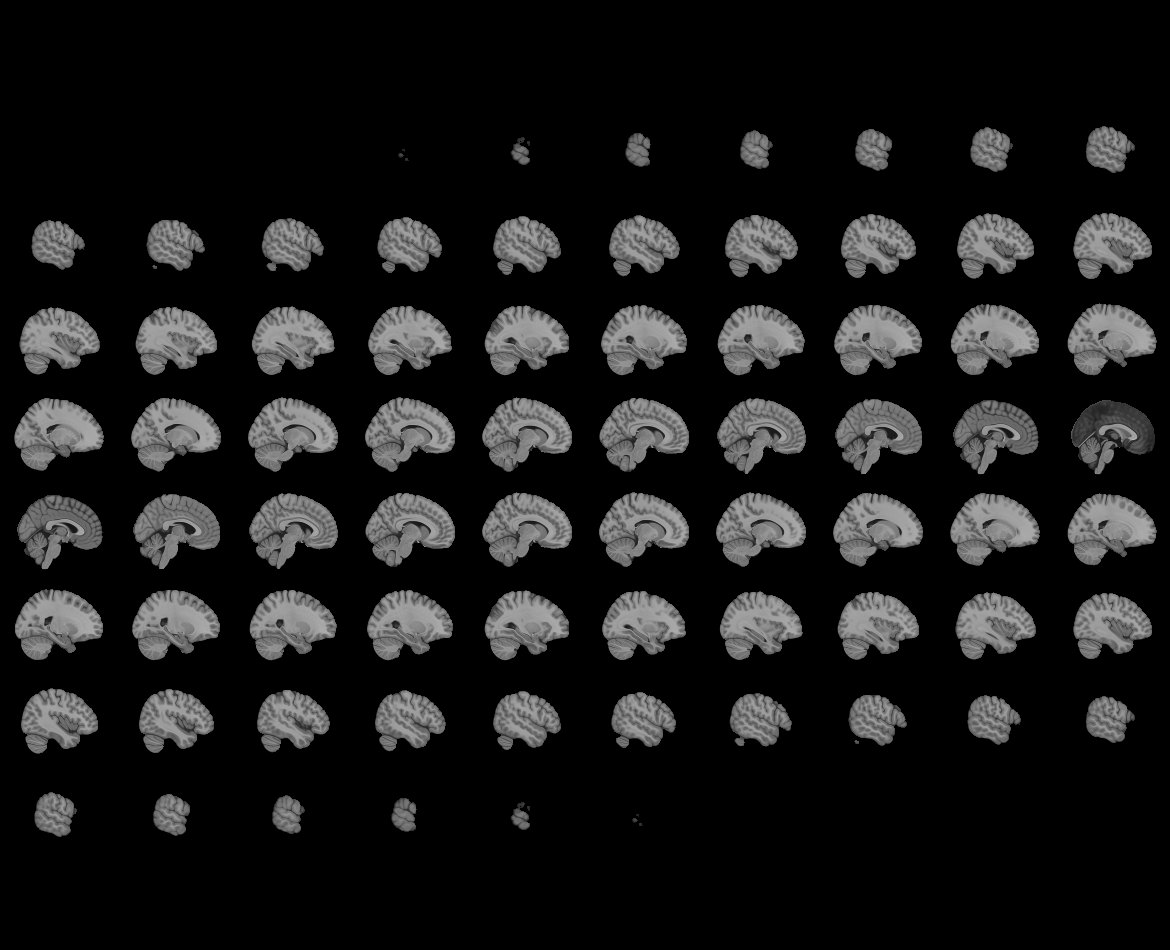
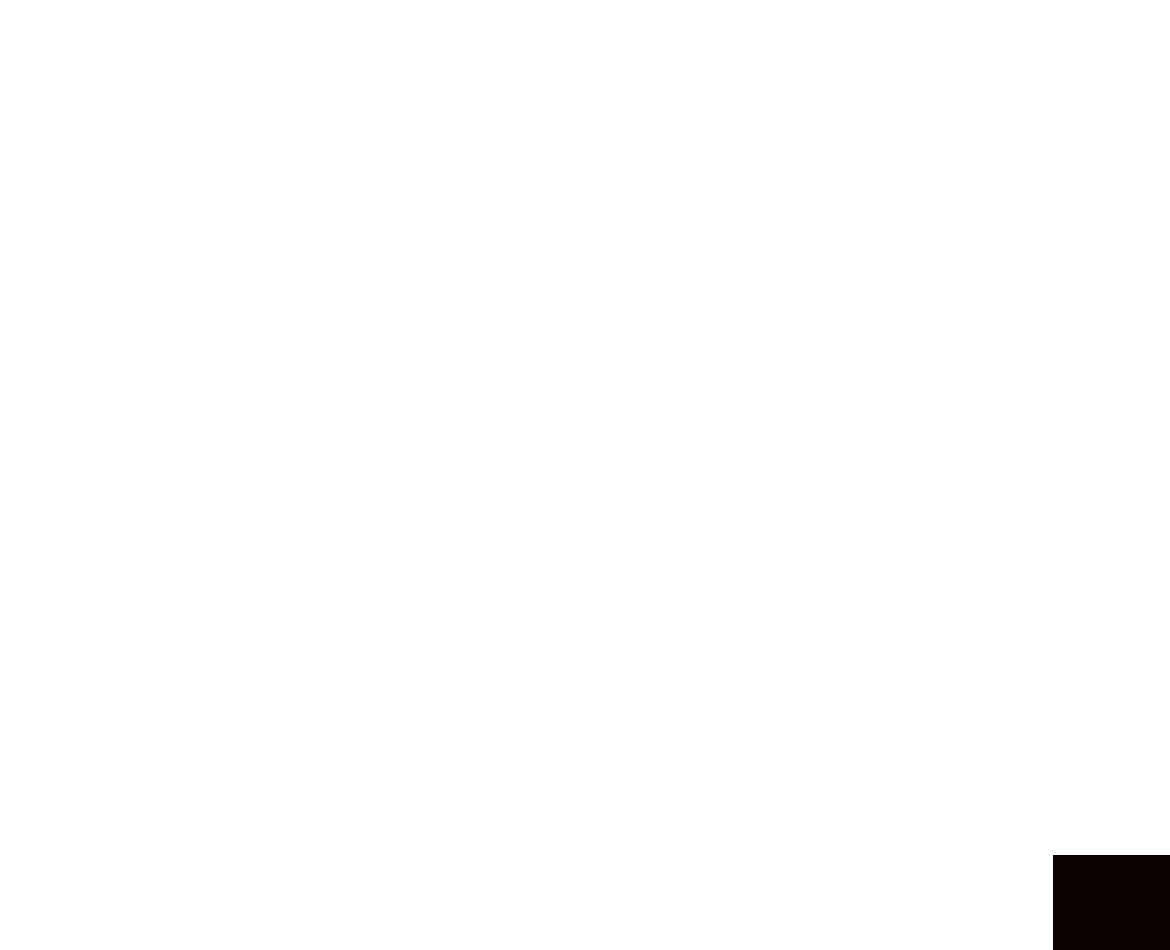

In [59]:
# Using Brainiak ISC

# Convert data to Brainiak format (ts x node x subject)
reshape_esc_ab = np.transpose(esc_ab, (1, 2, 0))

# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
esc_ab_ave = b_isc(reshape_esc_ab, pairwise=False)

esc_ab_ave_isc, ci, esc_ab_ave_p, distribution = b_bootstrap_isc(esc_ab_ave, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median', 
                                              n_bootstraps= 5000)

fdr_thr = fdr(esc_ab_ave_p)
print(fdr_thr)

# Assuming p is your numpy array of p-values
# Assuming fdr_thr is your FDR threshold value

# Create a boolean mask indicating which p-values are below the FDR threshold
surviving_nodes_mask = esc_ab_ave_p <= fdr_thr

# Extract the indices of the nodes that survive the FDR threshold
surviving_nodes_indices = np.where(surviving_nodes_mask)[0]

# Optionally, extract the p-values of the surviving nodes
surviving_p_values = esc_ab_ave_p[surviving_nodes_mask]

# Because of 0-index need to change the indices 
adjusted_indices = surviving_nodes_indices - 1

# Extract anatomical labels for the surviving nodes using list comprehension
surviving_labels = [ba_def[idx] for idx in adjusted_indices]

# Print the results along with ISC values
for idx in surviving_nodes_indices:
    # Use idx directly to access the anatomical label
    label = surviving_labels[np.where(surviving_nodes_indices == idx)[0][0]]  # Get the corresponding anatomical label
    isc_value = esc_ab_ave_isc[idx]  # Get the ISC value for the node
    print(f"Node index {idx}:{label}, ISC Value: {isc_value}")

esc_ab_ave_isc, esc_ab_ave_p = roi_to_brain(pd.Series(esc_ab_ave_isc), expand_mask(mask)), roi_to_brain(pd.Series(esc_ab_ave_p), expand_mask(mask))
view_img(threshold(esc_ab_ave_isc, esc_ab_ave_p, thr=fdr_thr).to_nifti(), draw_cross= False)



## Network Analysis

In [109]:
esc_a_n_smat = []
for network in range(esc_n_networks):
    esc_a_n_smat.append(Adjacency(1 - pairwise_distances(esc_a_n[:, :, network], metric='correlation'), matrix_type='similarity'))
esc_a_n_smat = Adjacency(esc_a_n_smat)

esc_a_n_isc = {}
esc_a_n_p_values = {}

for network in range(esc_n_networks):
    isc_result = esc_a_n_smat[network].isc(metric='mean', n_bootstraps=5000, n_jobs=1)
    esc_a_n_isc[network] = isc_result['isc']
    esc_a_n_p_values[network] = isc_result['p']

fdr_thr = fdr(pd.Series(esc_a_n_p_values).values)
print(fdr_thr)

-1


In [110]:
esc_b_n_smat = []
for network in range(esc_n_networks):
    esc_b_n_smat.append(Adjacency(1 - pairwise_distances(esc_b_n[:, :, network], metric='correlation'), matrix_type='similarity'))
esc_b_n_smat = Adjacency(esc_b_n_smat)

esc_b_n_isc = {}
esc_b_n_p_values = {}

for network in range(esc_n_networks):
    isc_result = esc_b_n_smat[network].isc(metric='mean', n_bootstraps=5000, n_jobs=1)
    esc_b_n_isc[network] = isc_result['isc']
    esc_b_n_p_values[network] = isc_result['p']

fdr_thr = fdr(pd.Series(esc_b_n_p_values).values)
print(fdr_thr)

-1


In [111]:
esc_ab_n_smat = []
for network in range(esc_n_networks):
    esc_ab_n_smat.append(Adjacency(1 - pairwise_distances(esc_ab_n[:, :, network], metric='correlation'), matrix_type='similarity'))
esc_ab_n_smat = Adjacency(esc_ab_n_smat)

esc_ab_n_isc = {}
esc_ab_n_p_values = {}

for network in range(esc_n_networks):
    isc_result = esc_ab_n_smat[network].isc(metric='mean', n_bootstraps=5000, n_jobs=1)
    esc_ab_n_isc[network] = isc_result['isc']
    esc_ab_n_p_values[network] = isc_result['p']
    
fdr_thr = fdr(pd.Series(esc_ab_n_p_values).values)
print(fdr_thr)

-1


### Average

In [169]:
# Convert data to Brainiak format (ts x node x subject)
reshape_esc_a_n = np.transpose(esc_a_n, (1, 2, 0))

# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
esc_a_n_ave = b_isc(reshape_esc_a_n, pairwise=False)

esc_a_n_ave_isc, ci, esc_a_n_ave_p, distribution = b_bootstrap_isc(esc_a_n_ave, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median', 
                                              n_bootstraps= 5000)

fdr_thr = fdr(esc_a_n_ave_p)
print(fdr_thr)

# Assuming p is your numpy array of p-values
# Assuming fdr_thr is your FDR threshold value

# Create a boolean mask indicating which p-values are below the FDR threshold
surviving_nodes_mask = esc_a_n_ave_p <= fdr_thr

# Extract the indices of the nodes that survive the FDR threshold
surviving_nodes_indices = np.where(surviving_nodes_mask)[0]

# Optionally, extract the p-values of the surviving nodes
surviving_p_values = esc_a_n_ave_p[surviving_nodes_mask]

# Print the results along with ISC values
for idx in surviving_nodes_indices:
    # Use idx directly to access the anatomical label
    isc_value = esc_a_n_ave_isc[idx]  # Get the ISC value for the node
    print(f"Network {idx}, ISC Value: {isc_value}")

0.003999200159968006
Node index 4, ISC Value: 0.038462678575160995


In [168]:
# Convert data to Brainiak format (ts x node x subject)
reshape_esc_b_n = np.transpose(esc_b_n, (1, 2, 0))

# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
esc_b_n_ave = b_isc(reshape_esc_b_n, pairwise=False)

esc_b_n_ave_isc, ci, esc_b_n_ave_p, distribution = b_bootstrap_isc(esc_b_n_ave, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median', 
                                              n_bootstraps= 5000)

fdr_thr = fdr(esc_b_n_ave_p)
print(fdr_thr)

# Assuming p is your numpy array of p-values
# Assuming fdr_thr is your FDR threshold value

# Create a boolean mask indicating which p-values are below the FDR threshold
surviving_nodes_mask = esc_b_n_ave_p <= fdr_thr

# Extract the indices of the nodes that survive the FDR threshold
surviving_nodes_indices = np.where(surviving_nodes_mask)[0]

# Optionally, extract the p-values of the surviving nodes
surviving_p_values = esc_b_n_ave_p[surviving_nodes_mask]

# Print the results
print("Surviving nodes indices:", surviving_nodes_indices)
print("Surviving p-values:", surviving_p_values)

-1
Surviving nodes indices: []
Surviving p-values: []


In [170]:
# Convert data to Brainiak format (ts x node x subject)
reshape_esc_ab_n = np.transpose(esc_ab_n, (1, 2, 0))

# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
esc_ab_n_ave = b_isc(reshape_esc_ab_n, pairwise=False)

esc_ab_n_ave_isc, ci, esc_ab_n_ave_p, distribution = b_bootstrap_isc(esc_ab_n_ave, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median', 
                                              n_bootstraps= 5000)

fdr_thr = fdr(esc_ab_n_ave_p)
print(fdr_thr)

# Assuming p is your numpy array of p-values
# Assuming fdr_thr is your FDR threshold value

# Create a boolean mask indicating which p-values are below the FDR threshold
surviving_nodes_mask = esc_ab_n_ave_p <= fdr_thr

# Extract the indices of the nodes that survive the FDR threshold
surviving_nodes_indices = np.where(surviving_nodes_mask)[0]

# Optionally, extract the p-values of the surviving nodes
surviving_p_values = esc_ab_n_ave_p[surviving_nodes_mask]

# Print the results along with ISC values
for idx in surviving_nodes_indices:
    # Use idx directly to access the anatomical label
    isc_value = esc_a_n_ave_isc[idx]  # Get the ISC value for the node
    print(f"Network {idx}, ISC Value: {isc_value}")

0.005598880223955209
Network 3, ISC Value: 0.004295371461868705


# PSI ISC

## After

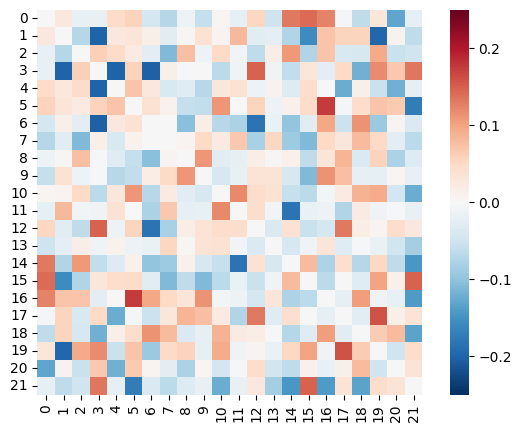

In [60]:
# Creates an empty list & creates similarity matrix
psi_a_smat = []
for node in range(psi_a_nodes):
    psi_a_smat.append(Adjacency(1 - pairwise_distances(psi_a[:, :, node], metric='correlation'), matrix_type='similarity'))
psi_a_smat = Adjacency(psi_a_smat)

# Visualize matrix 
psi_a_smat[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')



### Average 

0.0061987602479504095
Node index 14:Right-FrontEyeFields (8), ISC Value: 0.11052317942853132
Node index 19:Right-dlPFC(lat) (46), ISC Value: 0.07984683315154846
Node index 21:Right-Broca-Operc (44), ISC Value: 0.09381631696157267
Node index 27:Right-PreMot+SuppMot (6), ISC Value: 0.08349728628189687
Node index 30:Right-PreMot+SuppMot (6), ISC Value: 0.12092307362631467
Node index 35:Right-Insula (13), ISC Value: 0.08903747748567095
Node index 41:Right-VisMotor (7), ISC Value: 0.03530543576351276
Node index 45:Right-SupramargGyr (40), ISC Value: 0.11711672028394385
Node index 46:Right-SupramargGyr (40), ISC Value: 0.0963637037425602
Node index 55:Right-MedTempGyrus (21), ISC Value: 0.04155914604856283
Node index 60:Right-InfTempGyrus (20), ISC Value: 0.2647755376371964
Node index 61:Right-PrimAuditory (41), ISC Value: 0.07738765162825821
Node index 62:Right-PrimAuditory (41), ISC Value: 0.16848261411766374
Node index 64:Right-SupTempGyrus (22), ISC Value: 0.10653968918811682
Node index 

c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



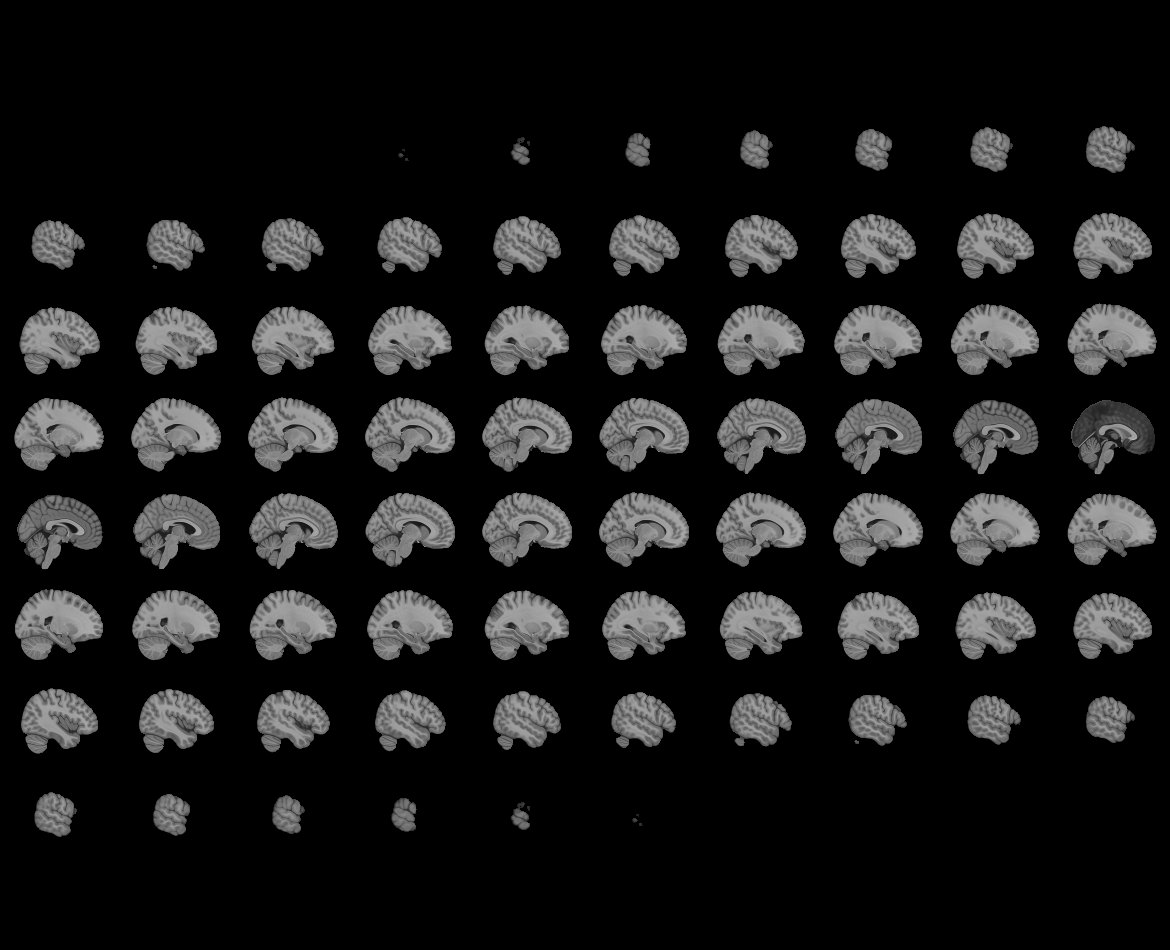
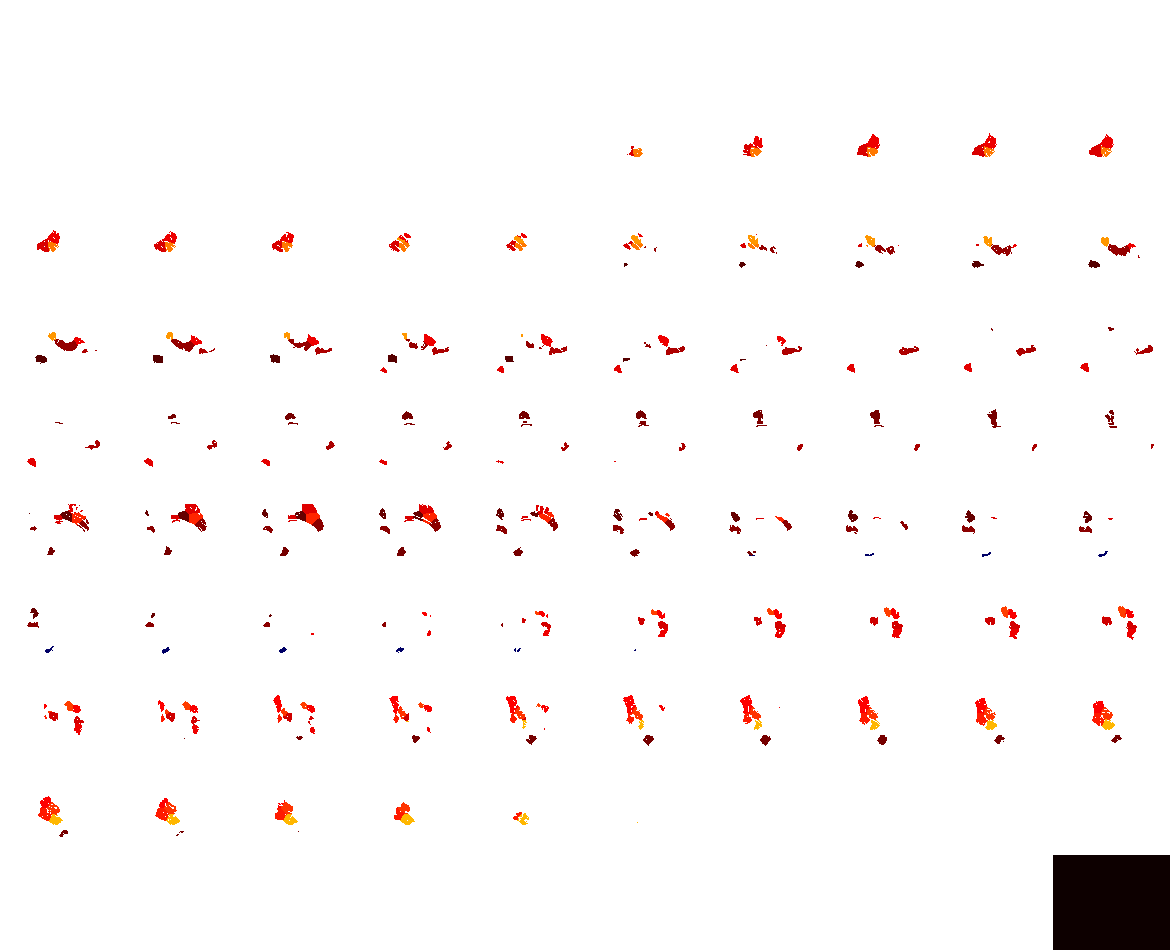

In [49]:
# Using Brainiak ISC

# Convert data to Brainiak format (ts x node x subject)
reshape_psi_a = np.transpose(psi_a, (1, 2, 0))

# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
psi_a_ave = b_isc(reshape_psi_a, pairwise=False)

psi_a_ave_isc, ci, psi_a_ave_p, distribution = b_bootstrap_isc(psi_a_ave, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median', 
                                              n_bootstraps= 5000)

fdr_thr = fdr(psi_a_ave_p)
print(fdr_thr)

# Assuming p is your numpy array of p-values
# Assuming fdr_thr is your FDR threshold value

# Create a boolean mask indicating which p-values are below the FDR threshold
surviving_nodes_mask = psi_a_ave_p <= fdr_thr

# Extract the indices of the nodes that survive the FDR threshold
surviving_nodes_indices = np.where(surviving_nodes_mask)[0]

# Optionally, extract the p-values of the surviving nodes
surviving_p_values = psi_a_ave_p[surviving_nodes_mask]

# Because of 0-index need to change the indices 
adjusted_indices = surviving_nodes_indices - 1

# Extract anatomical labels for the surviving nodes using list comprehension
surviving_labels = [ba_def[idx] for idx in adjusted_indices]

psi_a_s_nodes = {}

# Print the results along with ISC values
for idx in surviving_nodes_indices:
    # Use idx directly to access the anatomical label
    label = surviving_labels[np.where(surviving_nodes_indices == idx)[0][0]]  # Get the corresponding anatomical label
    isc_value = psi_a_ave_isc[idx]  # Get the ISC value for the node
    print(f"Node index {idx}:{label}, ISC Value: {isc_value}")
    psi_a_nodes[idx] = {'label': label, 'isc_value': isc_value}
    

psi_a_ave_isc, psi_a_ave_p = roi_to_brain(pd.Series(psi_a_ave_isc), expand_mask(mask)), roi_to_brain(pd.Series(psi_a_ave_p), expand_mask(mask))
view_img(threshold(psi_a_ave_isc, psi_a_ave_p, thr=fdr_thr).to_nifti(), draw_cross = False)

## Before

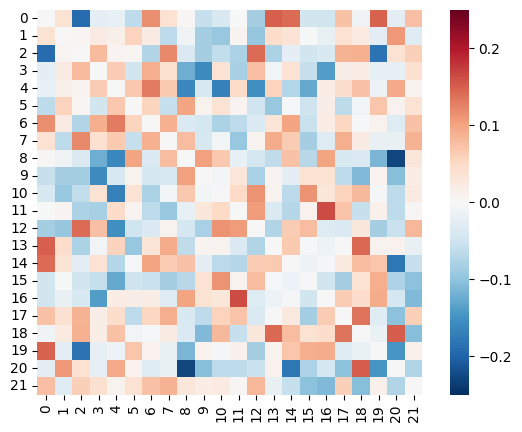

In [63]:
# Creates an empty list & creates similarity matrix
psi_b_smat = []
for node in range(psi_b_nodes):
    psi_b_smat.append(Adjacency(1 - pairwise_distances(psi_b[:, :, node], metric='correlation'), matrix_type='similarity'))
psi_b_smat = Adjacency(psi_b_smat)

# Visualize matrix 
psi_b_smat[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')


### Average

0.01279744051189762
Node index 8:Right-AntPFC (10), ISC Value: 0.09268334334910967
Node index 13:Right-FrontEyeFields (8), ISC Value: 0.0762705210175988
Node index 15:Right-FrontEyeFields (8), ISC Value: 0.07877922912361358
Node index 18:Right-ParsOrbitalis (47), ISC Value: 0.09272310055658124
Node index 19:Right-dlPFC(lat) (46), ISC Value: 0.10192695454552303
Node index 20:Right-Broca-Triang (45), ISC Value: 0.05964566115225815
Node index 21:Right-Broca-Operc (44), ISC Value: 0.13487041864740057
Node index 22:Right-Broca-Operc (44), ISC Value: 0.07253609750419801
Node index 23:Right-PrimMotor (4), ISC Value: 0.07080385759436514
Node index 26:Right-PreMot+SuppMot (6), ISC Value: 0.06418821694662752
Node index 27:Right-PreMot+SuppMot (6), ISC Value: 0.0703490109467473
Node index 30:Right-PreMot+SuppMot (6), ISC Value: 0.11361038888389909
Node index 32:Right-PreMot+SuppMot (6), ISC Value: 0.07111105733809386
Node index 33:Right-PrimSensory (1), ISC Value: 0.06604033636449126
Node index 3

c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



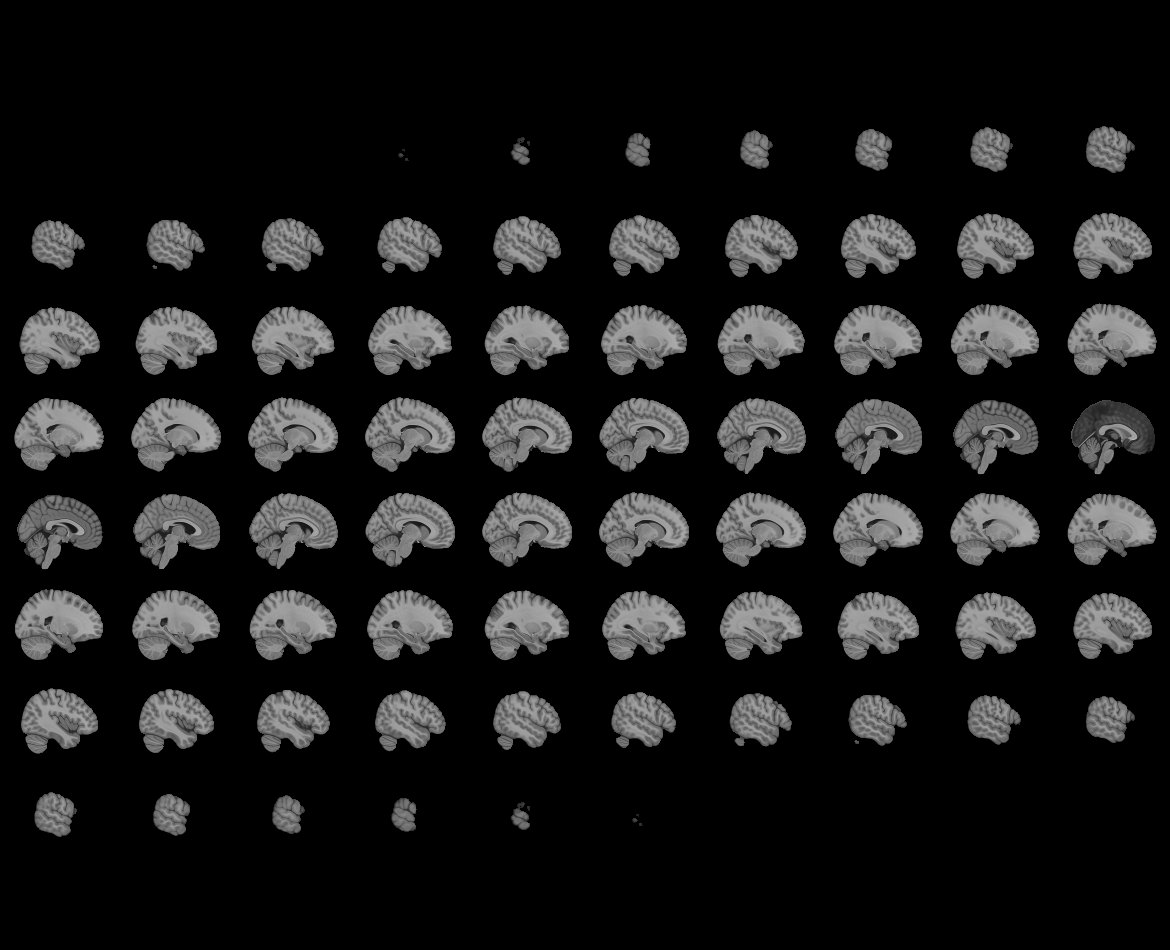
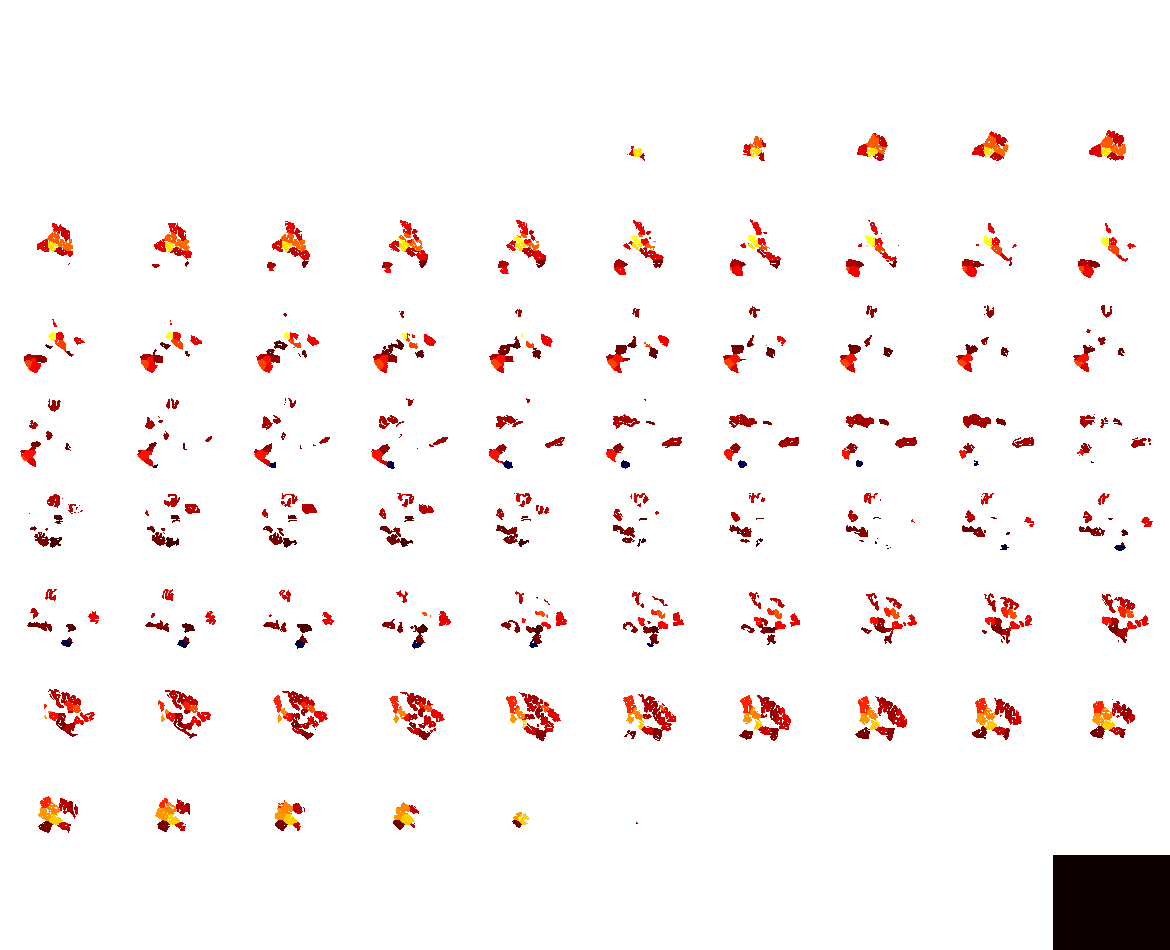

In [50]:
# Using Brainiak ISC

# Convert data to Brainiak format (ts x node x subject)
reshape_psi_b = np.transpose(psi_b, (1, 2, 0))

# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
psi_b_ave = b_isc(reshape_psi_b, pairwise=False)

psi_b_ave_isc, ci, psi_b_ave_p, distribution = b_bootstrap_isc(psi_b_ave, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median', 
                                              n_bootstraps= 5000)

fdr_thr = fdr(psi_b_ave_p)
print(fdr_thr)

# Assuming p is your numpy array of p-values
# Assuming fdr_thr is your FDR threshold value

# Create a boolean mask indicating which p-values are below the FDR threshold
surviving_nodes_mask = psi_b_ave_p <= fdr_thr

# Extract the indices of the nodes that survive the FDR threshold
surviving_nodes_indices = np.where(surviving_nodes_mask)[0]

# Optionally, extract the p-values of the surviving nodes
surviving_p_values = psi_b_ave_p[surviving_nodes_mask]

# Because of 0-index need to change the indices 
adjusted_indices = surviving_nodes_indices - 1

# Extract anatomical labels for the surviving nodes using list comprehension
surviving_labels = [ba_def[idx] for idx in adjusted_indices]

psi_b_s_nodes = {}

# Print the results along with ISC values
for idx in surviving_nodes_indices:
    # Use idx directly to access the anatomical label
    label = surviving_labels[np.where(surviving_nodes_indices == idx)[0][0]]  # Get the corresponding anatomical label
    isc_value = psi_b_ave_isc[idx]  # Get the ISC value for the node
    print(f"Node index {idx}:{label}, ISC Value: {isc_value}")
    psi_b_nodes[idx] = {'label': label, 'isc_value': isc_value}


psi_b_ave_isc, psi_b_ave_p = roi_to_brain(pd.Series(psi_b_ave_isc), expand_mask(mask)), roi_to_brain(pd.Series(psi_b_ave_p), expand_mask(mask))
view_img(threshold(psi_b_ave_isc, psi_b_ave_p, thr=fdr_thr).to_nifti())

## After-Before

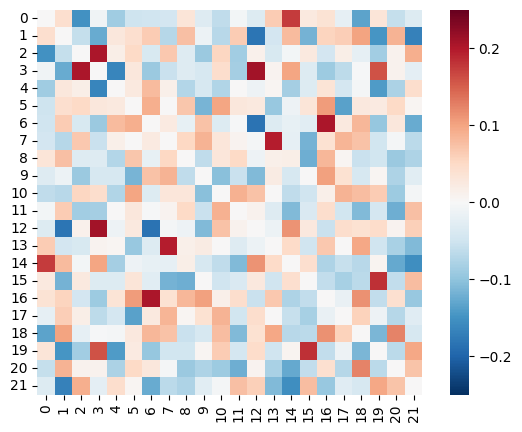

In [11]:
# Pairwise 

# Creates an empty list & creates similarity matrix
psi_ab_smat = []
for node in range(psi_ab_nodes):
    psi_ab_smat.append(Adjacency(1 - pairwise_distances(psi_ab[:, :, node], metric='correlation'), matrix_type='similarity'))
psi_ab_smat = Adjacency(psi_ab_smat)

# Visualize matrix 
psi_ab_smat[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')

### Average

0.0003999200159968006
Node index 87:Right-VentPostCing (23), ISC Value: 0.04834804311027241
Node index 92:Right-Amygdala, ISC Value: 0.04208305468549624
Node index 219:Left-DorsalACC (32), ISC Value: 0.052552325090495663
Node index 229:Left-Hippocampus, ISC Value: -0.03693584441076796


c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



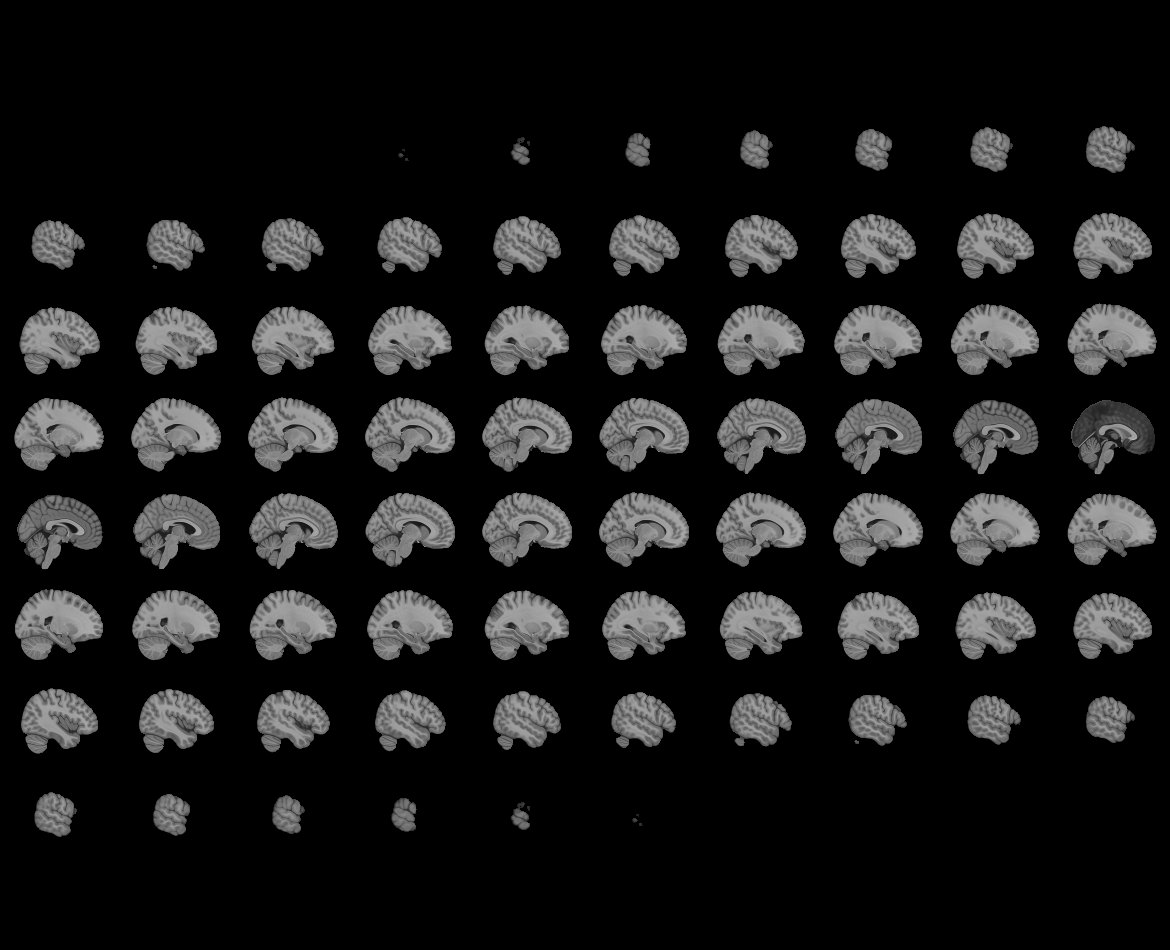
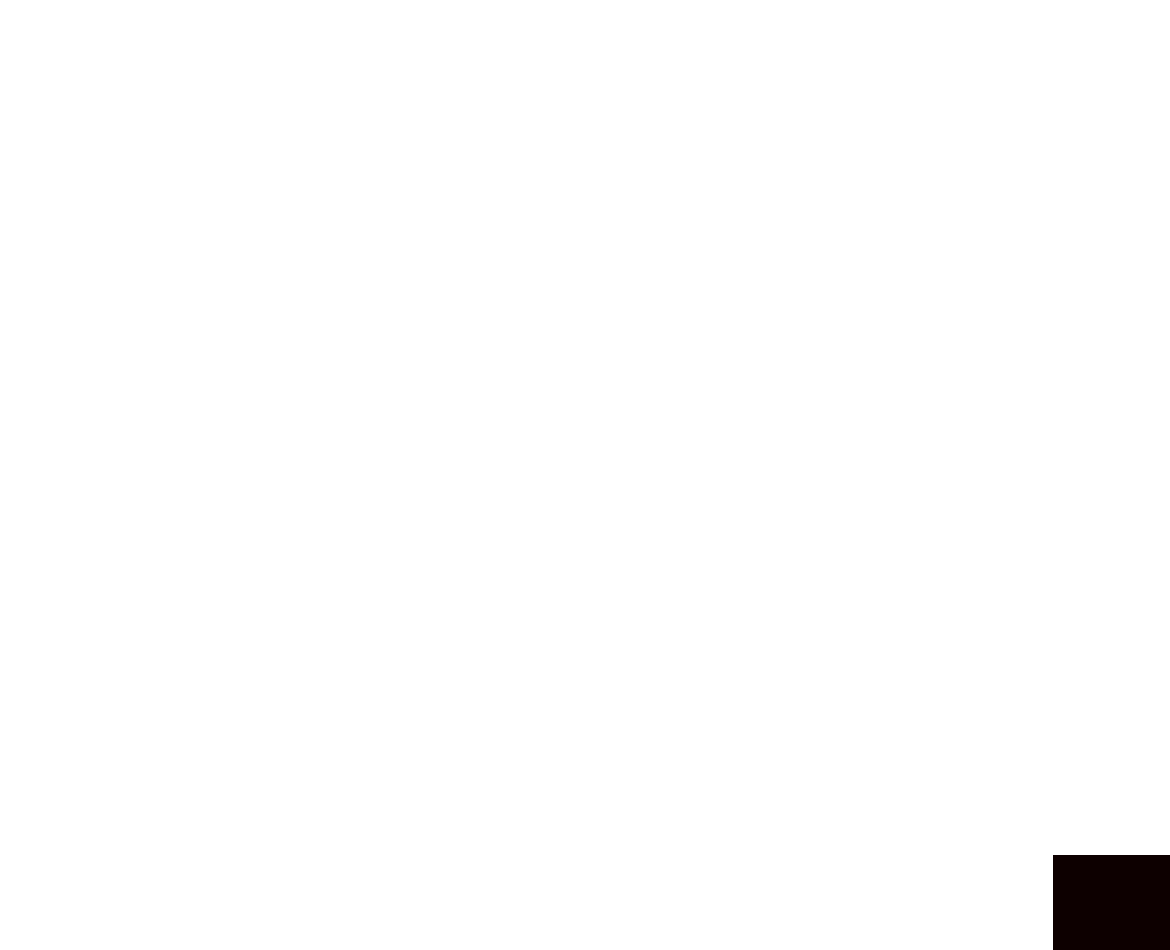

In [13]:
# Using Brainiak ISC

# Convert data to Brainiak format (ts x node x subject)
reshape_psi_ab = np.transpose(psi_ab, (1, 2, 0))

# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
psi_ab_ave = b_isc(reshape_psi_ab, pairwise=False)

psi_ab_ave_isc, ci, psi_ab_ave_p, distribution = b_bootstrap_isc(psi_ab_ave, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median', 
                                              n_bootstraps= 5000)

fdr_thr = fdr(psi_ab_ave_p)
print(fdr_thr)

# Assuming p is your numpy array of p-values
# Assuming fdr_thr is your FDR threshold value

# Create a boolean mask indicating which p-values are below the FDR threshold
surviving_nodes_mask = psi_ab_ave_p <= fdr_thr

# Extract the indices of the nodes that survive the FDR threshold
surviving_nodes_indices = np.where(surviving_nodes_mask)[0]

# Optionally, extract the p-values of the surviving nodes
surviving_p_values = psi_ab_ave_p[surviving_nodes_mask]

# Because of 0-index need to change the indices 
adjusted_indices = surviving_nodes_indices - 1

# Extract anatomical labels for the surviving nodes using list comprehension
surviving_labels = [ba_def[idx] for idx in adjusted_indices]

# Print the results along with ISC values
for idx in surviving_nodes_indices:
    # Use idx directly to access the anatomical label
    label = surviving_labels[np.where(surviving_nodes_indices == idx)[0][0]]  # Get the corresponding anatomical label
    isc_value = psi_ab_ave_isc[idx]  # Get the ISC value for the node
    print(f"Node index {idx}:{label}, ISC Value: {isc_value}")

psi_ab_ave_isc, psi_ab_ave_p = roi_to_brain(pd.Series(psi_ab_ave_isc), expand_mask(mask)), roi_to_brain(pd.Series(psi_ab_ave_p), expand_mask(mask))
view_img(threshold(psi_ab_ave_isc, psi_ab_ave_p, thr=fdr_thr).to_nifti(), draw_cross= False)

## Network 

In [106]:
psi_a_n_smat = []
for network in range(psi_n_networks):
    psi_a_n_smat.append(Adjacency(1 - pairwise_distances(psi_a_n[:, :, network], metric='correlation'), matrix_type='similarity'))
psi_a_n_smat = Adjacency(psi_a_n_smat)

psi_a_n_isc = {}
psi_a_n_p_values = {}

for network in range(psi_n_networks):
    isc_result = psi_a_n_smat[network].isc(metric='mean', n_bootstraps=5000, n_jobs=1)
    psi_a_n_isc[network] = isc_result['isc']
    psi_a_n_p_values[network] = isc_result['p']

fdr_thr = fdr(pd.Series(psi_a_n_p_values).values)
print(fdr_thr)


-1


In [107]:
psi_b_n_smat = []
for network in range(psi_n_networks):
    psi_b_n_smat.append(Adjacency(1 - pairwise_distances(psi_b_n[:, :, network], metric='correlation'), matrix_type='similarity'))
psi_b_n_smat = Adjacency(psi_b_n_smat)

psi_b_n_isc = {}
psi_b_n_p_values = {}

for network in range(psi_n_networks):
    isc_result = psi_b_n_smat[network].isc(metric='mean', n_bootstraps=5000, n_jobs=1)
    psi_b_n_isc[network] = isc_result['isc']
    psi_b_n_p_values[network] = isc_result['p']

fdr_thr = fdr(pd.Series(psi_b_n_p_values).values)
print(fdr_thr)

-1


In [108]:
psi_ab_n_smat = []
for network in range(psi_n_networks):
    psi_ab_n_smat.append(Adjacency(1 - pairwise_distances(psi_ab_n[:, :, network], metric='correlation'), matrix_type='similarity'))
psi_ab_n_smat = Adjacency(psi_ab_n_smat)

psi_ab_n_isc = {}
psi_ab_n_p_values = {}

for network in range(psi_n_networks):
    isc_result = psi_ab_n_smat[network].isc(metric='mean', n_bootstraps=5000, n_jobs=1)
    psi_ab_n_isc[network] = isc_result['isc']
    psi_ab_n_p_values[network] = isc_result['p']

    
fdr_thr = fdr(pd.Series(psi_ab_n_p_values).values)
print(fdr_thr)

-1


### Average 

In [169]:
# Convert data to Brainiak format (ts x node x subject)
reshape_psi_a_n = np.transpose(psi_a_n, (1, 2, 0))

# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
psi_a_n_ave = b_isc(reshape_psi_a_n, pairwise=False)

psi_a_n_ave_isc, ci, psi_a_n_ave_p, distribution = b_bootstrap_isc(psi_a_n_ave, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median', 
                                              n_bootstraps= 5000)

fdr_thr = fdr(psi_a_n_ave_p)
print(fdr_thr)

# Assuming p is your numpy array of p-values
# Assuming fdr_thr is your FDR threshold value

# Create a boolean mask indicating which p-values are below the FDR threshold
surviving_nodes_mask = psi_a_n_ave_p <= fdr_thr

# Extract the indices of the nodes that survive the FDR threshold
surviving_nodes_indices = np.where(surviving_nodes_mask)[0]

# Optionally, extract the p-values of the surviving nodes
surviving_p_values = psi_a_n_ave_p[surviving_nodes_mask]

# Print the results
print("Surviving nodes indices:", surviving_nodes_indices)
print("Surviving p-values:", surviving_p_values)

-1
Surviving nodes indices: []
Surviving p-values: []


In [101]:
# Convert data to Brainiak format (ts x node x subject)
reshape_psi_b_n = np.transpose(psi_b_n, (1, 2, 0))

# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
psi_b_n_ave = b_isc(reshape_psi_b_n, pairwise=False)

psi_b_n_ave_isc, ci, psi_b_n_ave_p, distribution = b_bootstrap_isc(psi_b_n_ave, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median', 
                                              n_bootstraps= 5000)

fdr_thr = fdr(psi_b_n_ave_p)
print(fdr_thr)

# Assuming p is your numpy array of p-values
# Assuming fdr_thr is your FDR threshold value

# Create a boolean mask indicating which p-values are below the FDR threshold
surviving_nodes_mask = psi_b_n_ave_p <= fdr_thr

# Extract the indices of the nodes that survive the FDR threshold
surviving_nodes_indices = np.where(surviving_nodes_mask)[0]

# Optionally, extract the p-values of the surviving nodes
surviving_p_values = psi_b_n_ave_p[surviving_nodes_mask]

# Print the results along with ISC values
for idx in surviving_nodes_indices:
    # Use idx directly to access the anatomical label
    isc_value = psi_b_n_ave_isc[idx]  # Get the ISC value for the node
    print(f"Network {idx}, ISC Value: {isc_value}")

0.0003999200159968006
Network 4, ISC Value: 0.08669370165367965


In [171]:
# Convert data to Brainiak format (ts x node x subject)
reshape_psi_ab_n = np.transpose(psi_ab_n, (1, 2, 0))

# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
psi_ab_n_ave = b_isc(reshape_psi_ab_n, pairwise=False)

psi_ab_n_ave_isc, ci, psi_ab_n_ave_p, distribution = b_bootstrap_isc(psi_ab_n_ave, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median', 
                                              n_bootstraps= 5000)

fdr_thr = fdr(psi_ab_n_ave_p)
print(fdr_thr)

# Assuming p is your numpy array of p-values
# Assuming fdr_thr is your FDR threshold value

# Create a boolean mask indicating which p-values are below the FDR threshold
surviving_nodes_mask = psi_ab_n_ave_p <= fdr_thr

# Extract the indices of the nodes that survive the FDR threshold
surviving_nodes_indices = np.where(surviving_nodes_mask)[0]

# Optionally, extract the p-values of the surviving nodes
surviving_p_values = psi_ab_n_ave_p[surviving_nodes_mask]

# Print the results
print("Surviving nodes indices:", surviving_nodes_indices)
print("Surviving p-values:", surviving_p_values)

-1
Surviving nodes indices: []
Surviving p-values: []


# Comparisons of Surviving Nodes (Ave ISC)
- No surviving nodes from pairwise method so only used Average ISC 
- Blocks must be run one by one since the functions use the same variable names for speed 
    - Thought to be fine since the printed results would be different 

In [52]:
# ESC 

# Unique to before 
unique_to_b = {k: v for k, v in esc_b_s_nodes.items() if k not in esc_a_s_nodes}

print("Nodes unique to before condition:")
for node, data in unique_to_b.items():
    print(f"Node index {node}: {data['label']}, ISC Value: {data['isc_value']}")

# Unique to after 
unique_to_a = {k: v for k, v in esc_a_s_nodes.items() if k not in esc_b_s_nodes}

print("Nodes unique to after condition:")
for node, data in unique_to_a.items():
    print(f"Node index {node}: {data['label']}, ISC Value: {data['isc_value']}")


# Common in both 
common_nodes = {k: (esc_b_s_nodes[k], esc_a_s_nodes[k]) 
                for k in esc_b_s_nodes if k in esc_a_s_nodes}

print("Nodes common to both conditions:")
for node, (b_data, a_data) in common_nodes.items():
    print(f"Node index {node}: {b_data['label']}, ESC ISC Value: {b_data['isc_value']}, PSI ISC Value: {a_data['isc_value']}")


Nodes unique to before condition:
Node index 64: Right-SupTempGyrus (22), ISC Value: 0.15021428770780093
Node index 91: Right-DorsalPCC (31), ISC Value: 0.054876709139171184
Node index 110: Cerebellum, ISC Value: -0.055377290628742935
Node index 117: Cerebellum, ISC Value: -0.03615943791406003
Node index 121: Right-Caudate, ISC Value: 0.03630379588001745
Node index 127: Right-Thalamus, ISC Value: 0.040309965044437374
Node index 159: Left-PreMot+SuppMot (6), ISC Value: 0.06461785332167919
Node index 187: Left-Temporalpole (38), ISC Value: 0.12315516972198962
Node index 228: Left-Amygdala, ISC Value: 0.04645135783934778
Node index 253: Cerebellum, ISC Value: 0.04438721318895845
Node index 255: Cerebellum, ISC Value: -0.03354888814329405
Nodes unique to after condition:
Node index 15: Right-FrontEyeFields (8), ISC Value: 0.0986138687835897
Node index 18: Right-ParsOrbitalis (47), ISC Value: 0.08070106859703616
Node index 19: Right-dlPFC(lat) (46), ISC Value: 0.07114278010825589
Node index

In [101]:
# PSI 

# Unique to before 
unique_to_b = {k: v for k, v in psi_b_s_nodes.items() if k not in psi_a_s_nodes}

print("Nodes unique to before condition:")
for node, data in unique_to_b.items():
    print(f"Node index {node}: {data['label']}, ISC Value: {data['isc_value']}")

# Unique to after 
unique_to_a = {k: v for k, v in psi_a_s_nodes.items() if k not in psi_b_s_nodes}

print("Nodes unique to after condition:")
for node, data in unique_to_a.items():
    print(f"Node index {node}: {data['label']}, ISC Value: {data['isc_value']}")


# Common in both 
common_nodes = {k: (psi_b_s_nodes[k], psi_a_s_nodes[k]) 
                for k in psi_b_s_nodes if k in psi_a_s_nodes}

print("Nodes common to both conditions:")
for node, (a_data, b_data) in common_nodes.items():
    print(f"Node index {node}: {a_data['label']}, psi ISC Value: {a_data['isc_value']}, PSI ISC Value: {b_data['isc_value']}")


Nodes unique to before condition:
Node index 8: Right-AntPFC (10), ISC Value: 0.09268334334910967
Node index 13: Right-FrontEyeFields (8), ISC Value: 0.0762705210175988
Node index 15: Right-FrontEyeFields (8), ISC Value: 0.07877922912361358
Node index 18: Right-ParsOrbitalis (47), ISC Value: 0.09272310055658124
Node index 20: Right-Broca-Triang (45), ISC Value: 0.05964566115225815
Node index 22: Right-Broca-Operc (44), ISC Value: 0.07253609750419801
Node index 23: Right-PrimMotor (4), ISC Value: 0.07080385759436514
Node index 26: Right-PreMot+SuppMot (6), ISC Value: 0.06418821694662752
Node index 32: Right-PreMot+SuppMot (6), ISC Value: 0.07111105733809386
Node index 33: Right-PrimSensory (1), ISC Value: 0.06604033636449126
Node index 36: Right-Insula (13), ISC Value: 0.046541639271426
Node index 38: Right-PrimSensory (1), ISC Value: 0.08477458650369651
Node index 39: Right-PrimSensory (1), ISC Value: 0.06229303733585777
Node index 52: Right-Temporalpole (38), ISC Value: 0.050755974618

In [102]:
# Differences in after treatment nodes 

# Unique to ESC
unique_to_esc = {k: v for k, v in esc_a_s_nodes.items() if k not in psi_b_s_nodes}

print("Nodes unique to ESC condition:")
for node, data in unique_to_esc.items():
    print(f"Node index {node}: {data['label']}, ISC Value: {data['isc_value']}")

# Unique to PSI
unique_to_psi = {k: v for k, v in psi_b_s_nodes.items() if k not in esc_a_s_nodes}

print("Nodes unique to PSI condition:")
for node, data in unique_to_psi.items():
    print(f"Node index {node}: {data['label']}, ISC Value: {data['isc_value']}")


# Common in both 
common_nodes = {k: (esc_a_s_nodes[k], psi_b_s_nodes[k]) 
                for k in esc_a_s_nodes if k in psi_b_s_nodes}

print("Nodes common to both conditions:")
for node, (psi_data, esc_data) in common_nodes.items():
    print(f"Node index {node}: {psi_data['label']}, psi ISC Value: {psi_data['isc_value']}, PSI ISC Value: {esc_data['isc_value']}")

Nodes unique to ESC condition:
Node index 48: Right-AngGyrus (39), ISC Value: 0.057798653616531304
Node index 53: Right-Temporalpole (38), ISC Value: 0.0968704059277322
Node index 68: Right-Fusiform (37), ISC Value: 0.06553115882237538
Node index 77: Right-SecVisual (18), ISC Value: -0.07967449366568286
Node index 153: Left-ParsOrbitalis (47), ISC Value: 0.058241181875055496
Node index 176: Left-VisMotor (7), ISC Value: 0.08265018401679074
Node index 183: Left-AngGyrus (39), ISC Value: 0.07506237575114273
Node index 211: Left-SecVisual (18), ISC Value: -0.08457425212791923
Node index 213: Left-SecVisual (18), ISC Value: -0.07784286344857344
Node index 216: Left-PrimVisual (17), ISC Value: -0.041825989692062054
Nodes unique to after condition:
Node index 8: Right-AntPFC (10), ISC Value: 0.09268334334910967
Node index 13: Right-FrontEyeFields (8), ISC Value: 0.0762705210175988
Node index 22: Right-Broca-Operc (44), ISC Value: 0.07253609750419801
Node index 23: Right-PrimMotor (4), ISC Va

In [103]:
# Differences in before treatment nodes 

# Unique to ESC
unique_to_esc = {k: v for k, v in esc_b_s_nodes.items() if k not in psi_a_s_nodes}

print("Nodes unique to ESC condition:")
for node, data in unique_to_esc.items():
    print(f"Node index {node}: {data['label']}, ISC Value: {data['isc_value']}")

# Unique to PSI
unique_to_psi = {k: v for k, v in psi_a_s_nodes.items() if k not in esc_b_s_nodes}

print("Nodes unique to PSI condition:")
for node, data in unique_to_psi.items():
    print(f"Node index {node}: {data['label']}, ISC Value: {data['isc_value']}")


# Common in both 
common_nodes = {k: (esc_b_s_nodes[k], psi_a_s_nodes[k]) 
                for k in esc_b_s_nodes if k in psi_a_s_nodes}

print("Nodes common to both conditions:")
for node, (psi_data, esc_data) in common_nodes.items():
    print(f"Node index {node}: {psi_data['label']}, psi ISC Value: {psi_data['isc_value']}, PSI ISC Value: {esc_data['isc_value']}")

Nodes unique to ESC condition:
Node index 91: Right-DorsalPCC (31), ISC Value: 0.054876709139171184
Node index 110: Cerebellum, ISC Value: -0.055377290628742935
Node index 117: Cerebellum, ISC Value: -0.03615943791406003
Node index 121: Right-Caudate, ISC Value: 0.03630379588001745
Node index 127: Right-Thalamus, ISC Value: 0.040309965044437374
Node index 159: Left-PreMot+SuppMot (6), ISC Value: 0.06461785332167919
Node index 187: Left-Temporalpole (38), ISC Value: 0.12315516972198962
Node index 228: Left-Amygdala, ISC Value: 0.04645135783934778
Node index 253: Cerebellum, ISC Value: 0.04438721318895845
Node index 255: Cerebellum, ISC Value: -0.03354888814329405
Nodes unique to PSI condition:
Node index 14: Right-FrontEyeFields (8), ISC Value: 0.11052317942853132
Node index 19: Right-dlPFC(lat) (46), ISC Value: 0.07984683315154846
Node index 27: Right-PreMot+SuppMot (6), ISC Value: 0.08349728628189687
Node index 30: Right-PreMot+SuppMot (6), ISC Value: 0.12092307362631467
Node index 35

# ISFC 
- Thresholded images are saved to .csv files so they could be put into (https://bioimagesuiteweb.github.io/webapp/connviewer.html?species=human) to view connectivity matrix
- Need to run each block separately since the same code variables are used in each block
- Degree was calculated as a way to quantify functional connectivity 
    - Better ways can be found

## ESC

### After

Text(96.78333333333339, 0.5, 'ROI')

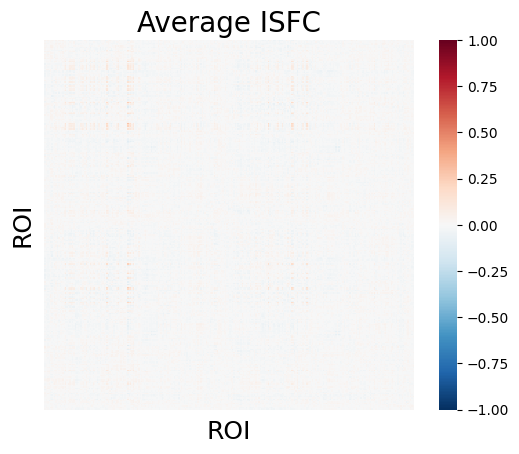

In [114]:
isfc_output = isfc(esc_a)

sns.heatmap(np.array(isfc_output).mean(axis=0), vmin=-1, vmax=1, square=True, cmap='RdBu_r', xticklabels=False, yticklabels=False)
plt.title('Average ISFC', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

0.00021420629957608607


Text(96.78333333333339, 0.5, 'ROI')

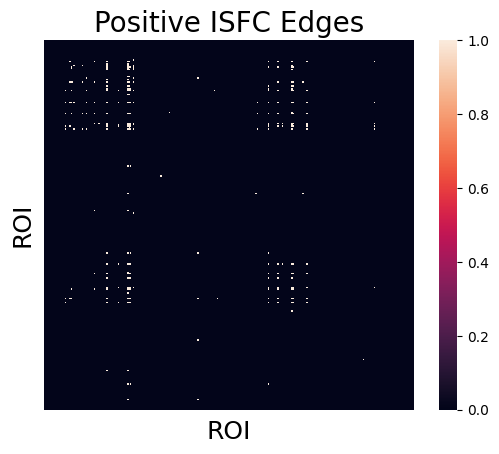

In [115]:
t, p = ttest_1samp(np.array([x.reshape(-1) for x in isfc_output]), 0)
thresh = fdr(p)
print(thresh)
thresholded_t_pos = t.copy()
thresholded_t_pos[p > thresh] = 0
thresholded_t_pos[thresholded_t_pos <= 0] = 0
thresholded_t_pos[thresholded_t_pos > 0] = 1
thresholded_t_pos = np.reshape(thresholded_t_pos, isfc_output[0].shape)

# Convert the array to a DataFrame
df = pd.DataFrame(thresholded_t_pos)

file_path = os.path.join(data_dir, "esc_a_pos.csv")

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=False)


sns.heatmap(thresholded_t_pos, square=True, xticklabels=False, yticklabels=False)
plt.title('Positive ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

Text(96.78333333333339, 0.5, 'ROI')

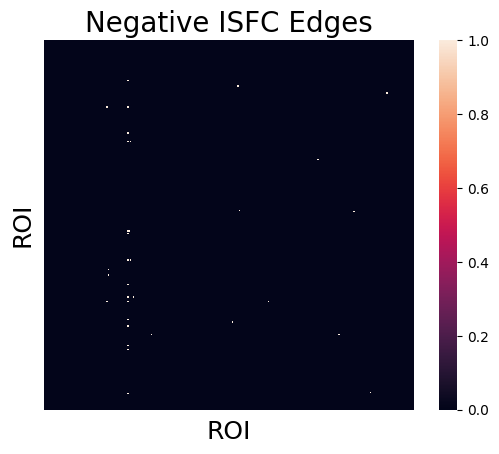

In [217]:
# Create a threshold map for negative ISFC values
thresholded_t_neg = t.copy()
thresholded_t_neg[p > thresh] = 0
thresholded_t_neg[thresholded_t_neg >= 0] = 0
thresholded_t_neg[thresholded_t_neg < 0] = 1
thresholded_t_neg = np.reshape(thresholded_t_neg, isfc_output[0].shape)

# Convert the array to a DataFrame
df = pd.DataFrame(thresholded_t_neg)

file_path = os.path.join(data_dir, "esc_a_neg.csv")

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=False)


sns.heatmap(thresholded_t_neg, square=True, xticklabels=False, yticklabels=False)
plt.title('Negative ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

In [84]:

# Calculate the degree of each node (Positive) 
node_degrees = np.sum(thresholded_t_pos, axis=1)  # Sum of each row gives the degree of each node

# Create a list of tuples (node, degree) and filter nodes with degree > 0
node_degree_list = [(node, degree) for node, degree in enumerate(node_degrees) if degree > 0]

# Sort the list by degree in descending order
node_degree_list.sort(key=lambda x: x[1], reverse=True)

esc_a_degree = {}
# Print the nodes with their degrees in descending order
for node, degree in node_degree_list:
    anatomical_label = ba_def[node]  
    print(f"Node {node} {anatomical_label}: Degree - {degree}")
    esc_a_degree[node] = {'label': anatomical_label, 'degree': degree}


Node 45 Right-SupramargGyr (40): Degree - 19.0
Node 36 Right-Insula (13): Degree - 15.0
Node 53 Right-MedTempGyrus (21): Degree - 15.0
Node 60 Right-PrimAuditory (41): Degree - 14.0
Node 62 Right-SupTempGyrus (22): Degree - 14.0
Node 64 Right-SupTempGyrus (22): Degree - 14.0
Node 187 Left-Temporalpole (38): Degree - 14.0
Node 30 Right-PreMot+SuppMot (6): Degree - 13.0
Node 179 Left-SupramargGyr (40): Degree - 12.0
Node 162 Left-PreMot+SuppMot (6): Degree - 11.0
Node 190 Left-MedTempGyrus (21): Degree - 11.0
Node 15 Right-ParsOrbitalis (47): Degree - 10.0
Node 19 Right-Broca-Triang (45): Degree - 10.0
Node 169 Left-Insula (13): Degree - 10.0
Node 180 Left-SupramargGyr (40): Degree - 10.0
Node 61 Right-PrimAuditory (41): Degree - 9.0
Node 172 Left-PrimSensory (1): Degree - 7.0
Node 18 Right-dlPFC(lat) (46): Degree - 6.0
Node 33 Right-Insula (13): Degree - 6.0
Node 35 Right-Insula (13): Degree - 6.0
Node 21 Right-Broca-Operc (44): Degree - 5.0
Node 154 Left-Broca-Triang (45): Degree - 5.0

In [187]:
# Calculate the degree of each node (Negative)
node_degrees = np.sum(thresholded_t_neg, axis=1)  # Sum of each row gives the degree of each node

# Create a list of tuples (node, degree) and filter nodes with degree > 0
node_degree_list = [(node, degree) for node, degree in enumerate(node_degrees) if degree > 0]

# Sort the list by degree in descending order
node_degree_list.sort(key=lambda x: x[1], reverse=True)

# Print the nodes with their degrees in descending order
for node, degree in node_degree_list:
    anatomical_label = ba_def[node]  
    print(f"Node {node} {anatomical_label}: Degree - {degree}")

Node 189 Left-MedTempGyrus (21): Degree - 3.0
Node 48 Right-AngGyrus (39): Degree - 2.0
Node 73 Right-VisualAssoc (19): Degree - 2.0
Node 138 Left-AntPFC (10): Degree - 2.0
Node 159 Left-PreMot+SuppMot (6): Degree - 2.0
Node 186 Left-Temporalpole (38): Degree - 2.0
Node 213 Left-SecVisual (18): Degree - 2.0
Node 29 Right-PreMot+SuppMot (6): Degree - 1.0
Node 33 Right-Insula (13): Degree - 1.0
Node 38 Right-PrimSensory (1): Degree - 1.0
Node 67 Right-Fusiform (37): Degree - 1.0
Node 86 Right-VentPostCing (23): Degree - 1.0
Node 123 Right-Putamen: Degree - 1.0
Node 124 Right-Putamen: Degree - 1.0
Node 140 Left-AntPFC (10): Degree - 1.0
Node 166 Left-PrimSensory (1): Degree - 1.0
Node 170 Left-PrimSensory (1): Degree - 1.0
Node 177 Left-VisMotor (7): Degree - 1.0
Node 202 Left-VisualAssoc (19): Degree - 1.0
Node 204 Left-VisualAssoc (19): Degree - 1.0
Node 207 Left-VisualAssoc (19): Degree - 1.0
Node 221 Left-VentPostCing (23): Degree - 1.0
Node 224 Left-DorsalPCC (31): Degree - 1.0
Node 

### Before

0.00023594207791323375


Text(96.78333333333339, 0.5, 'ROI')

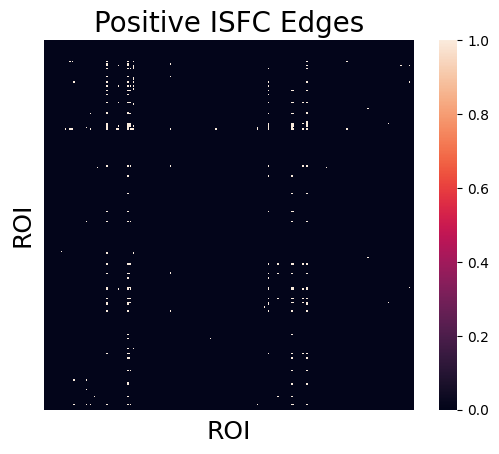

In [85]:
isfc_output = isfc(esc_b)

t, p = ttest_1samp(np.array([x.reshape(-1) for x in isfc_output]), 0)
thresh = fdr(p)
print(thresh)
thresholded_t_pos = t.copy()
thresholded_t_pos[p > thresh] = 0
thresholded_t_pos[thresholded_t_pos <= 0] = 0
thresholded_t_pos[thresholded_t_pos > 0] = 1
thresholded_t_pos = np.reshape(thresholded_t_pos, isfc_output[0].shape)

# Convert the array to a DataFrame
df = pd.DataFrame(thresholded_t_pos)

file_path = os.path.join(data_dir, "esc_b_pos.csv")

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=False)


sns.heatmap(thresholded_t_pos, square=True, xticklabels=False, yticklabels=False)
plt.title('Positive ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

Text(96.78333333333339, 0.5, 'ROI')

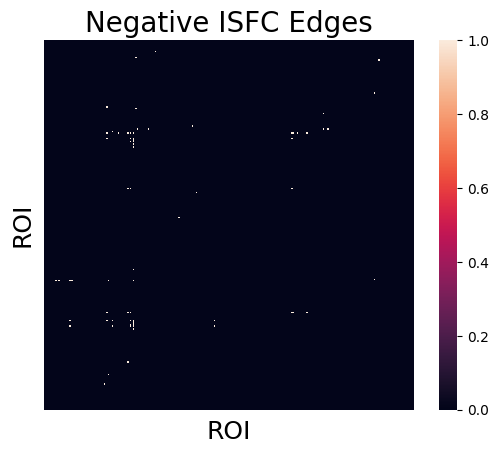

In [219]:
# Create a threshold map for negative ISFC values
thresholded_t_neg = t.copy()
thresholded_t_neg[p > thresh] = 0
thresholded_t_neg[thresholded_t_neg >= 0] = 0
thresholded_t_neg[thresholded_t_neg < 0] = 1
thresholded_t_neg = np.reshape(thresholded_t_neg, isfc_output[0].shape)

# Convert the array to a DataFrame
df = pd.DataFrame(thresholded_t_neg)

file_path = os.path.join(data_dir, "esc_b_neg.csv")

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=False)


sns.heatmap(thresholded_t_neg, square=True, xticklabels=False, yticklabels=False)
plt.title('Negative ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

In [86]:

# Calculate the degree of each node (pos.)
node_degrees = np.sum(thresholded_t_pos, axis=1)  # Sum of each row gives the degree of each node

# Create a list of tuples (node, degree) and filter nodes with degree > 0
node_degree_list = [(node, degree) for node, degree in enumerate(node_degrees) if degree > 0]

# Sort the list by degree in descending order
node_degree_list.sort(key=lambda x: x[1], reverse=True)

esc_b_degree = {}

# Print the nodes with their degrees in descending order
for node, degree in node_degree_list:
    anatomical_label = ba_def[node]  
    print(f"Node {node} {anatomical_label}: Degree - {degree}")
    esc_b_degree[node] = {'label': anatomical_label, 'degree': degree}

Node 64 Right-SupTempGyrus (22): Degree - 21.0
Node 45 Right-SupramargGyr (40): Degree - 10.0
Node 60 Right-PrimAuditory (41): Degree - 10.0
Node 62 Right-SupTempGyrus (22): Degree - 10.0
Node 162 Left-PreMot+SuppMot (6): Degree - 10.0
Node 187 Left-Temporalpole (38): Degree - 10.0
Node 190 Left-MedTempGyrus (21): Degree - 10.0
Node 264 Brainstem: Degree - 10.0
Node 53 Right-MedTempGyrus (21): Degree - 9.0
Node 179 Left-SupramargGyr (40): Degree - 9.0
Node 180 Left-SupramargGyr (40): Degree - 9.0
Node 36 Right-Insula (13): Degree - 8.0
Node 61 Right-PrimAuditory (41): Degree - 8.0
Node 169 Left-Insula (13): Degree - 8.0
Node 15 Right-ParsOrbitalis (47): Degree - 7.0
Node 18 Right-dlPFC(lat) (46): Degree - 7.0
Node 30 Right-PreMot+SuppMot (6): Degree - 7.0
Node 91 Right-Amygdala: Degree - 7.0
Node 227 Left-Amygdala: Degree - 7.0
Node 20 Right-Broca-Operc (44): Degree - 6.0
Node 33 Right-Insula (13): Degree - 6.0
Node 63 Right-SupTempGyrus (22): Degree - 6.0
Node 131 Brainstem: Degree - 

In [191]:

# Calculate the degree of each node (neg.)
node_degrees = np.sum(thresholded_t_neg, axis=1)  # Sum of each row gives the degree of each node

# Create a list of tuples (node, degree) and filter nodes with degree > 0
node_degree_list = [(node, degree) for node, degree in enumerate(node_degrees) if degree > 0]

# Sort the list by degree in descending order
node_degree_list.sort(key=lambda x: x[1], reverse=True)

# Print the nodes with their degrees in descending order
for node, degree in node_degree_list:
    anatomical_label = ba_def[node]  
    print(f"Node {node} {anatomical_label}: Degree - {degree}")

Node 67 Right-Fusiform (37): Degree - 9.0
Node 174 Left-VisMotor (7): Degree - 7.0
Node 197 Left-Fusiform (37): Degree - 6.0
Node 203 Left-VisualAssoc (19): Degree - 6.0
Node 207 Left-VisualAssoc (19): Degree - 5.0
Node 64 Right-SupTempGyrus (22): Degree - 4.0
Node 71 Right-VisualAssoc (19): Degree - 4.0
Node 107 Cerebellum: Degree - 3.0
Node 73 Right-VisualAssoc (19): Degree - 2.0
Node 206 Left-VisualAssoc (19): Degree - 2.0
Node 8 Right-AntPFC (10): Degree - 1.0
Node 12 Right-FrontEyeFields (8): Degree - 1.0
Node 14 Right-FrontEyeFields (8): Degree - 1.0
Node 38 Right-PrimSensory (1): Degree - 1.0
Node 48 Right-AngGyrus (39): Degree - 1.0
Node 49 Right-AngGyrus (39): Degree - 1.0
Node 53 Right-MedTempGyrus (21): Degree - 1.0
Node 62 Right-SupTempGyrus (22): Degree - 1.0
Node 66 Right-Fusiform (37): Degree - 1.0
Node 72 Right-VisualAssoc (19): Degree - 1.0
Node 75 Right-SecVisual (18): Degree - 1.0
Node 77 Right-SecVisual (18): Degree - 1.0
Node 110 Cerebellum: Degree - 1.0
Node 128 B

Text(96.78333333333339, 0.5, 'ROI')

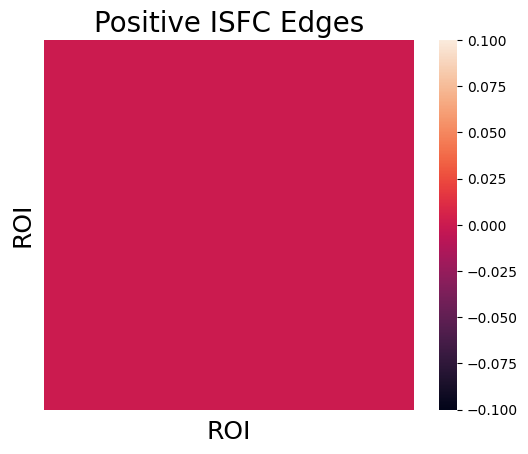

In [199]:
isfc_output = isfc(esc_ab)

t, p = ttest_1samp(np.array([x.reshape(-1) for x in isfc_output]), 0)
thresh = fdr(p)
thresholded_t_pos = t.copy()
thresholded_t_pos[p > thresh] = 0
thresholded_t_pos[thresholded_t_pos <= 0] = 0
thresholded_t_pos[thresholded_t_pos > 0] = 1
thresholded_t_pos = np.reshape(thresholded_t_pos, isfc_output[0].shape)

# Convert the array to a DataFrame
df = pd.DataFrame(thresholded_t_pos)

file_path = os.path.join(data_dir, "esc_ab_pos.csv")

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=False)


sns.heatmap(thresholded_t_pos, square=True, xticklabels=False, yticklabels=False)
plt.title('Positive ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

Text(96.78333333333339, 0.5, 'ROI')

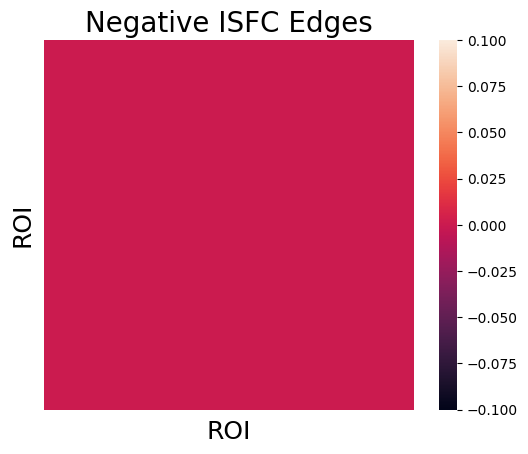

In [200]:
# Create a threshold map for negative ISFC values
thresholded_t_neg = t.copy()
thresholded_t_neg[p > thresh] = 0
thresholded_t_neg[thresholded_t_neg >= 0] = 0
thresholded_t_neg[thresholded_t_neg < 0] = 1
thresholded_t_neg = np.reshape(thresholded_t_neg, isfc_output[0].shape)

# Convert the array to a DataFrame
df = pd.DataFrame(thresholded_t_neg)

file_path = os.path.join(data_dir, "esc_a_neg.csv")

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=False)


sns.heatmap(thresholded_t_neg, square=True, xticklabels=False, yticklabels=False)
plt.title('Negative ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

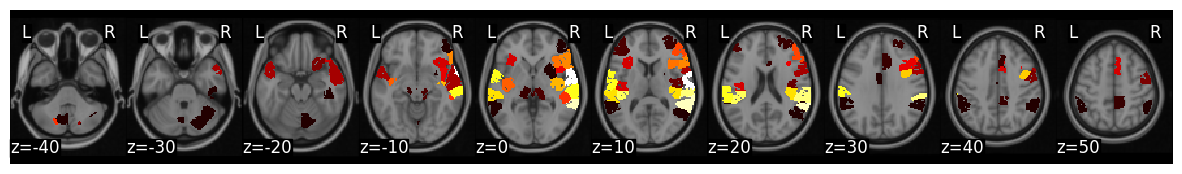

In [73]:
degree = pd.Series(dict(Adjacency(thresholded_t_pos, matrix_type='similarity').to_graph().degree()))
brain_degree = roi_to_brain(degree, expand_mask(mask))
brain_degree.plot()

c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



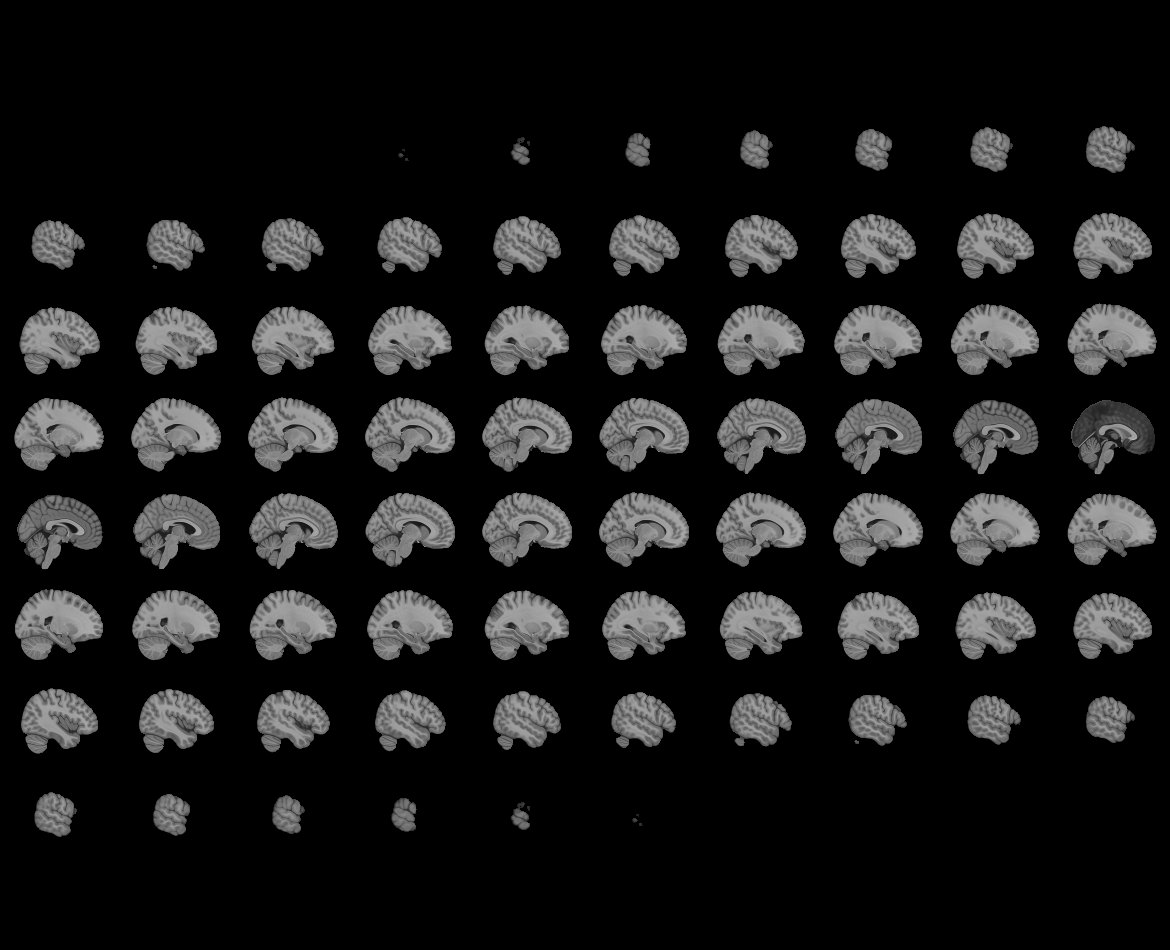
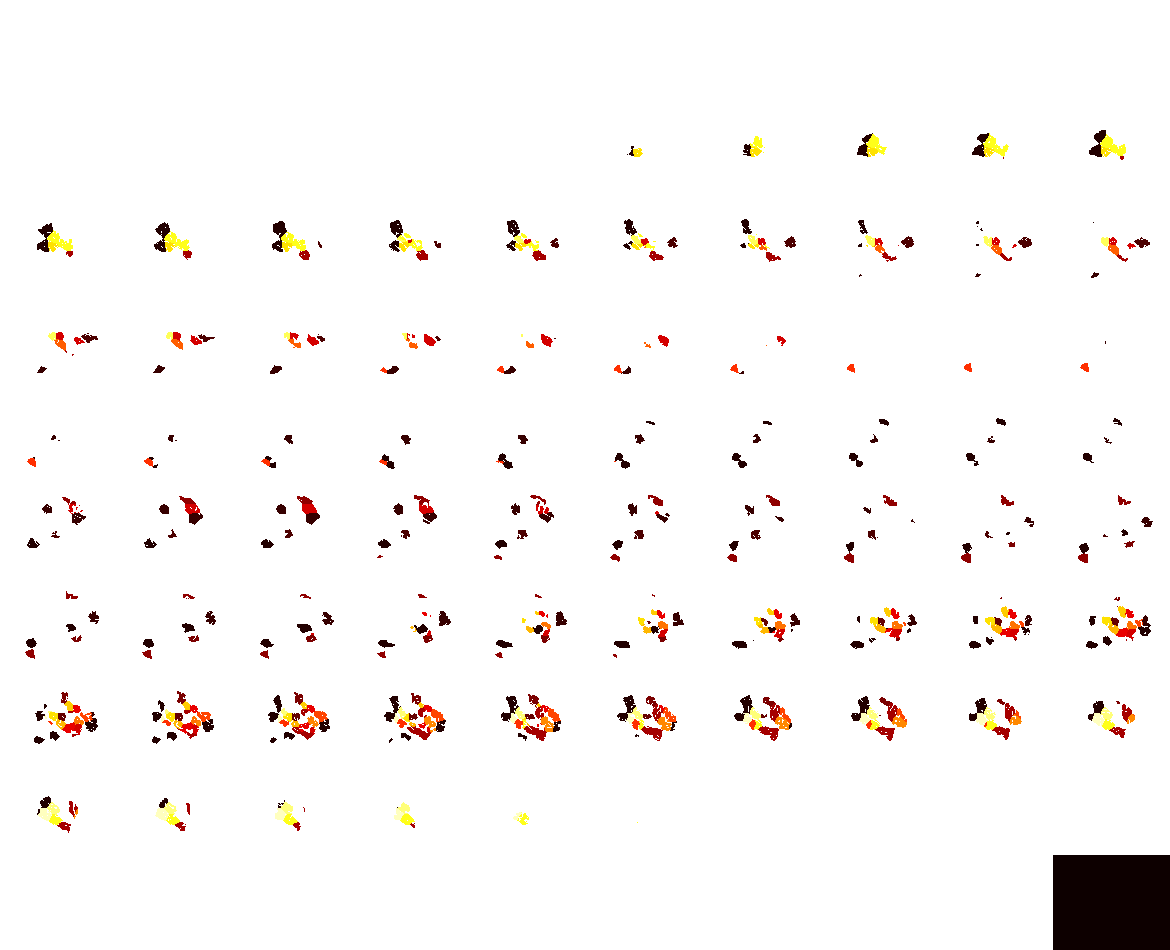

In [74]:
view_img(brain_degree.to_nifti())


## PSI 

### Before

0.00021636012870907692


Text(96.78333333333339, 0.5, 'ROI')

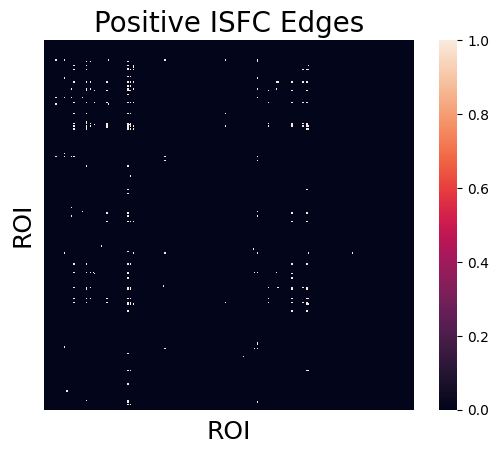

In [87]:
isfc_output = isfc(psi_a)
t, p = ttest_1samp(np.array([x.reshape(-1) for x in isfc_output]), 0)
thresh = fdr(p)
print(thresh)
thresholded_t_pos = t.copy()
thresholded_t_pos[p > thresh] = 0
thresholded_t_pos[thresholded_t_pos <= 0] = 0
thresholded_t_pos[thresholded_t_pos > 0] = 1
thresholded_t_pos = np.reshape(thresholded_t_pos, isfc_output[0].shape)

# Convert the array to a DataFrame
df = pd.DataFrame(thresholded_t_pos)

file_path = os.path.join(data_dir, "psi_a_pos.csv")

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=False)


sns.heatmap(thresholded_t_pos, square=True, xticklabels=False, yticklabels=False)
plt.title('Positive ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

Text(96.78333333333339, 0.5, 'ROI')

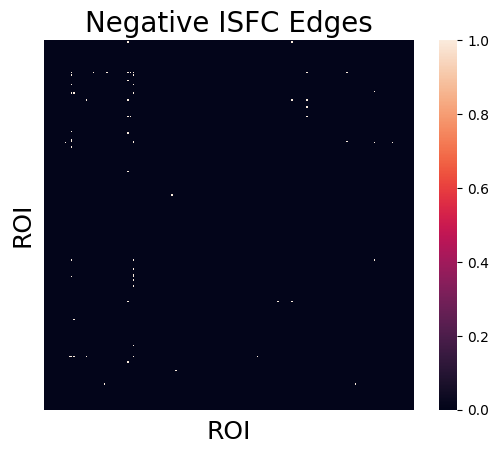

In [88]:
# Create a threshold map for negative ISFC values
thresholded_t_neg = t.copy()
thresholded_t_neg[p > thresh] = 0
thresholded_t_neg[thresholded_t_neg >= 0] = 0
thresholded_t_neg[thresholded_t_neg < 0] = 1
thresholded_t_neg = np.reshape(thresholded_t_neg, isfc_output[0].shape)

# Convert the array to a DataFrame
df = pd.DataFrame(thresholded_t_neg)

file_path = os.path.join(data_dir, "psi_a_neg.csv")

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=False)


sns.heatmap(thresholded_t_neg, square=True, xticklabels=False, yticklabels=False)
plt.title('Negative ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

In [89]:

# Calculate the degree of each node
node_degrees = np.sum(thresholded_t_pos, axis=1)  # Sum of each row gives the degree of each node

# Create a list of tuples (node, degree) and filter nodes with degree > 0
node_degree_list = [(node, degree) for node, degree in enumerate(node_degrees) if degree > 0]

# Sort the list by degree in descending order
node_degree_list.sort(key=lambda x: x[1], reverse=True)

psi_b_degree = {}

# Print the nodes with their degrees in descending order
for node, degree in node_degree_list:
    anatomical_label = ba_def[node]  
    print(f"Node {node} {anatomical_label}: Degree - {degree}")
    psi_b_degree[node] = {'label': anatomical_label, 'degree': degree}


Node 62 Right-SupTempGyrus (22): Degree - 13.0
Node 30 Right-PreMot+SuppMot (6): Degree - 12.0
Node 45 Right-SupramargGyr (40): Degree - 11.0
Node 60 Right-PrimAuditory (41): Degree - 10.0
Node 179 Left-SupramargGyr (40): Degree - 10.0
Node 187 Left-Temporalpole (38): Degree - 10.0
Node 190 Left-MedTempGyrus (21): Degree - 10.0
Node 36 Right-Insula (13): Degree - 9.0
Node 21 Right-Broca-Operc (44): Degree - 8.0
Node 168 Left-Insula (13): Degree - 8.0
Node 35 Right-Insula (13): Degree - 7.0
Node 61 Right-PrimAuditory (41): Degree - 7.0
Node 64 Right-SupTempGyrus (22): Degree - 7.0
Node 14 Right-FrontEyeFields (8): Degree - 6.0
Node 84 Right-VentPostCing (23): Degree - 6.0
Node 131 Brainstem: Degree - 6.0
Node 154 Left-Broca-Triang (45): Degree - 6.0
Node 162 Left-PreMot+SuppMot (6): Degree - 6.0
Node 18 Right-dlPFC(lat) (46): Degree - 5.0
Node 41 Right-VisMotor (7): Degree - 5.0
Node 53 Right-MedTempGyrus (21): Degree - 5.0
Node 180 Left-SupramargGyr (40): Degree - 5.0
Node 191 Left-Med

In [206]:

# Calculate the degree of each node
node_degrees = np.sum(thresholded_t_neg, axis=1)  # Sum of each row gives the degree of each node

# Create a list of tuples (node, degree) and filter nodes with degree > 0
node_degree_list = [(node, degree) for node, degree in enumerate(node_degrees) if degree > 0]

# Sort the list by degree in descending order
node_degree_list.sort(key=lambda x: x[1], reverse=True)

# Print the nodes with their degrees in descending order
for node, degree in node_degree_list:
    anatomical_label = ba_def[node]  
    print(f"Node {node} {anatomical_label}: Degree - {degree}")

Node 23 Right-PreMot+SuppMot (6): Degree - 8.0
Node 229 Left-Hippocampus: Degree - 6.0
Node 43 Right-VisMotor (7): Degree - 4.0
Node 74 Right-VisualAssoc (19): Degree - 4.0
Node 38 Right-PrimSensory (1): Degree - 3.0
Node 55 Right-InfTempGyrus (20): Degree - 3.0
Node 73 Right-VisualAssoc (19): Degree - 3.0
Node 159 Left-PreMot+SuppMot (6): Degree - 3.0
Node 189 Left-MedTempGyrus (21): Degree - 3.0
Node 1 Right-OrbFrontal (11): Degree - 2.0
Node 25 Right-PreMot+SuppMot (6): Degree - 2.0
Node 32 Right-PrimSensory (1): Degree - 2.0
Node 171 Left-PrimSensory (1): Degree - 2.0
Node 249 Cerebellum: Degree - 2.0
Node 29 Right-PreMot+SuppMot (6): Degree - 1.0
Node 37 Right-PrimSensory (1): Degree - 1.0
Node 48 Right-AngGyrus (39): Degree - 1.0
Node 66 Right-Fusiform (37): Degree - 1.0
Node 67 Right-Fusiform (37): Degree - 1.0
Node 72 Right-VisualAssoc (19): Degree - 1.0
Node 77 Right-SecVisual (18): Degree - 1.0
Node 95 Right-Parahipp (36): Degree - 1.0
Node 112 Cerebellum: Degree - 1.0
Node 1

### After

0.0012148912036726283


Text(96.78333333333339, 0.5, 'ROI')

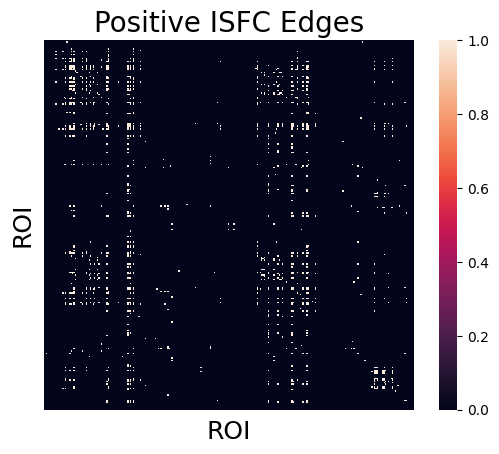

In [121]:
isfc_output = isfc(psi_b)
t, p = ttest_1samp(np.array([x.reshape(-1) for x in isfc_output]), 0)
thresh = fdr(p)
print(thresh)
thresholded_t_pos = t.copy()
thresholded_t_pos[p > thresh] = 0
thresholded_t_pos[thresholded_t_pos <= 0] = 0
thresholded_t_pos[thresholded_t_pos > 0] = 1
thresholded_t_pos = np.reshape(thresholded_t_pos, isfc_output[0].shape)

# Convert the array to a DataFrame
df = pd.DataFrame(thresholded_t_pos)

file_path = os.path.join(data_dir, "psi_b_pos.csv")

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=False)


sns.heatmap(thresholded_t_pos, square=True, xticklabels=False, yticklabels=False)
plt.title('Positive ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

Text(96.78333333333339, 0.5, 'ROI')

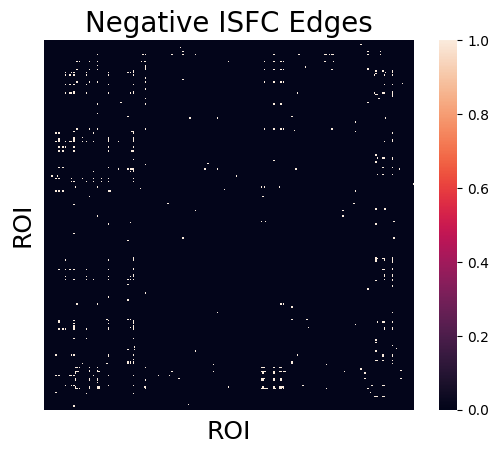

In [111]:
# Create a threshold map for negative ISFC values
thresholded_t_neg = t.copy()
thresholded_t_neg[p > thresh] = 0
thresholded_t_neg[thresholded_t_neg >= 0] = 0
thresholded_t_neg[thresholded_t_neg < 0] = 1
thresholded_t_neg = np.reshape(thresholded_t_neg, isfc_output[0].shape)

# Convert the array to a DataFrame
df = pd.DataFrame(thresholded_t_neg)

file_path = os.path.join(data_dir, "psi_b_neg.csv")

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=False)


sns.heatmap(thresholded_t_neg, square=True, xticklabels=False, yticklabels=False)
plt.title('Negative ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

In [105]:

# Calculate the degree of each node
node_degrees = np.sum(thresholded_t_pos, axis=1)  # Sum of each row gives the degree of each node

# Create a list of tuples (node, degree) and filter nodes with degree > 0
node_degree_list = [(node, degree) for node, degree in enumerate(node_degrees) if degree > 0]

# Sort the list by degree in descending order
node_degree_list.sort(key=lambda x: x[1], reverse=True)

psi_a_degree = {}

# Print the nodes with their degrees in descending order
for node, degree in node_degree_list:
    anatomical_label = ba_def[node]  
    print(f"Node {node} {anatomical_label}: Degree - {degree}")
    psi_a_degree[node] = {'label': anatomical_label, 'degree': degree}

Node 62 Right-SupTempGyrus (22): Degree - 31.0
Node 45 Right-SupramargGyr (40): Degree - 29.0
Node 64 Right-SupTempGyrus (22): Degree - 29.0
Node 21 Right-Broca-Operc (44): Degree - 28.0
Node 190 Left-MedTempGyrus (21): Degree - 27.0
Node 30 Right-PreMot+SuppMot (6): Degree - 26.0
Node 60 Right-PrimAuditory (41): Degree - 25.0
Node 187 Left-Temporalpole (38): Degree - 25.0
Node 18 Right-dlPFC(lat) (46): Degree - 24.0
Node 179 Left-SupramargGyr (40): Degree - 24.0
Node 180 Left-SupramargGyr (40): Degree - 23.0
Node 15 Right-ParsOrbitalis (47): Degree - 21.0
Node 154 Left-Broca-Triang (45): Degree - 21.0
Node 168 Left-Insula (13): Degree - 20.0
Node 169 Left-Insula (13): Degree - 20.0
Node 19 Right-Broca-Triang (45): Degree - 19.0
Node 191 Left-MedTempGyrus (21): Degree - 19.0
Node 20 Right-Broca-Operc (44): Degree - 18.0
Node 162 Left-PreMot+SuppMot (6): Degree - 18.0
Node 239 Cerebellum: Degree - 18.0
Node 46 Right-SupramargGyr (40): Degree - 17.0
Node 61 Right-PrimAuditory (41): Degre

In [210]:

# Calculate the degree of each node
node_degrees = np.sum(thresholded_t_neg, axis=1)  # Sum of each row gives the degree of each node

# Create a list of tuples (node, degree) and filter nodes with degree > 0
node_degree_list = [(node, degree) for node, degree in enumerate(node_degrees) if degree > 0]

# Sort the list by degree in descending order
node_degree_list.sort(key=lambda x: x[1], reverse=True)

# Print the nodes with their degrees in descending order
for node, degree in node_degree_list:
    anatomical_label = ba_def[node]  
    print(f"Node {node} {anatomical_label}: Degree - {degree}")

Node 252 Cerebellum: Degree - 19.0
Node 240 Cerebellum: Degree - 18.0
Node 10 Right-dlPFC(dorsal) (9): Degree - 15.0
Node 15 Right-ParsOrbitalis (47): Degree - 14.0
Node 73 Right-VisualAssoc (19): Degree - 14.0
Node 38 Right-PrimSensory (1): Degree - 13.0
Node 251 Cerebellum: Degree - 13.0
Node 237 Cerebellum: Degree - 12.0
Node 245 Cerebellum: Degree - 11.0
Node 21 Right-Broca-Operc (44): Degree - 10.0
Node 23 Right-PreMot+SuppMot (6): Degree - 10.0
Node 166 Left-PrimSensory (1): Degree - 10.0
Node 173 Left-VisMotor (7): Degree - 10.0
Node 243 Cerebellum: Degree - 10.0
Node 25 Right-PreMot+SuppMot (6): Degree - 9.0
Node 64 Right-SupTempGyrus (22): Degree - 9.0
Node 93 Right-Hippocampus: Degree - 9.0
Node 209 Left-SecVisual (18): Degree - 9.0
Node 250 Cerebellum: Degree - 9.0
Node 30 Right-PreMot+SuppMot (6): Degree - 8.0
Node 32 Right-PrimSensory (1): Degree - 8.0
Node 100 Cerebellum: Degree - 8.0
Node 228 Left-Hippocampus: Degree - 8.0
Node 246 Cerebellum: Degree - 8.0
Node 102 Cereb

Text(96.78333333333339, 0.5, 'ROI')

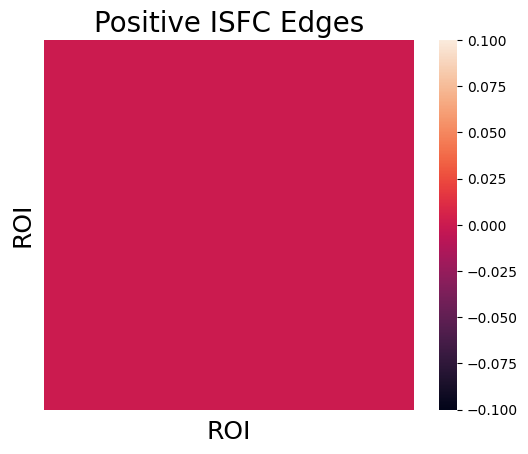

In [211]:
isfc_output = isfc(psi_ab)

t, p = ttest_1samp(np.array([x.reshape(-1) for x in isfc_output]), 0)
thresh = fdr(p)
thresholded_t_pos = t.copy()
thresholded_t_pos[p > thresh] = 0
thresholded_t_pos[thresholded_t_pos <= 0] = 0
thresholded_t_pos[thresholded_t_pos > 0] = 1
thresholded_t_pos = np.reshape(thresholded_t_pos, isfc_output[0].shape)

# Convert the array to a DataFrame
df = pd.DataFrame(thresholded_t_pos)

file_path = os.path.join(data_dir, "psi_ab_pos.csv")

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=False)


sns.heatmap(thresholded_t_pos, square=True, xticklabels=False, yticklabels=False)
plt.title('Positive ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

Text(96.78333333333339, 0.5, 'ROI')

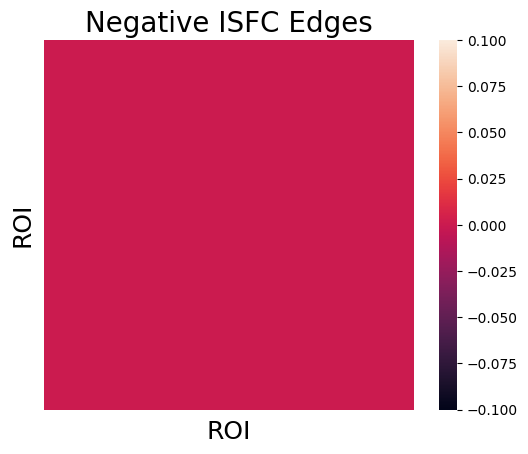

In [212]:
# Create a threshold map for negative ISFC values
thresholded_t_neg = t.copy()
thresholded_t_neg[p > thresh] = 0
thresholded_t_neg[thresholded_t_neg >= 0] = 0
thresholded_t_neg[thresholded_t_neg < 0] = 1
thresholded_t_neg = np.reshape(thresholded_t_neg, isfc_output[0].shape)

# Convert the array to a DataFrame
df = pd.DataFrame(thresholded_t_neg)

file_path = os.path.join(data_dir, "psi_ab_neg.csv")

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False, header=False)


sns.heatmap(thresholded_t_neg, square=True, xticklabels=False, yticklabels=False)
plt.title('Negative ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

In [213]:

# Calculate the degree of each node
node_degrees = np.sum(thresholded_t_pos, axis=1)  # Sum of each row gives the degree of each node

# Create a list of tuples (node, degree) and filter nodes with degree > 0
node_degree_list = [(node, degree) for node, degree in enumerate(node_degrees) if degree > 0]

# Sort the list by degree in descending order
node_degree_list.sort(key=lambda x: x[1], reverse=True)

# Print the nodes with their degrees in descending order
for node, degree in node_degree_list:
    anatomical_label = ba_def[node]  
    print(f"Node {node} {anatomical_label}: Degree - {degree}")

In [214]:

# Calculate the degree of each node
node_degrees = np.sum(thresholded_t_neg, axis=1)  # Sum of each row gives the degree of each node

# Create a list of tuples (node, degree) and filter nodes with degree > 0
node_degree_list = [(node, degree) for node, degree in enumerate(node_degrees) if degree > 0]

# Sort the list by degree in descending order
node_degree_list.sort(key=lambda x: x[1], reverse=True)

# Print the nodes with their degrees in descending order
for node, degree in node_degree_list:
    anatomical_label = ba_def[node]  
    print(f"Node {node} {anatomical_label}: Degree - {degree}")

## Node Connections 
- All ROI looked at below were found to have a high degree of connection and so change in degree and what they are connected 

In [96]:
# ESC 

# Unique to before 
unique_to_esc = {k: v for k, v in esc_b_degree.items() if k not in esc_a_degree}

print("Nodes unique to before condition:")
for node, data in unique_to_esc.items():
    print(f"Node index {node}: {data['label']}, Degree: {data['degree']}")

# Unique to after 
unique_to_psi = {k: v for k, v in esc_a_degree.items() if k not in esc_b_degree}

print("Nodes unique to after condition:")
for node, data in unique_to_psi.items():
    print(f"Node index {node}: {data['label']}, Degree: {data['degree']}")


# Common in both 
common_nodes = {k: (esc_b_degree[k], esc_a_degree[k]) 
                for k in esc_b_degree if k in esc_a_degree}

print("Nodes common to both conditions:")
for node, (esc_data, psi_data) in common_nodes.items():
    print(f"Node index {node}: {esc_data['label']}, ESC Before: {esc_data['degree']}, ESC After: {psi_data['degree']}")


Nodes unique to before condition:
Node index 264: Brainstem, Degree: 10.0
Node index 227: Left-Amygdala, Degree: 7.0
Node index 131: Brainstem, Degree: 6.0
Node index 124: Right-Putamen, Degree: 5.0
Node index 191: Left-MedTempGyrus (21), Degree: 4.0
Node index 230: Left-Hippocampus, Degree: 4.0
Node index 258: Left-Caudate, Degree: 4.0
Node index 92: Right-Hippocampus, Degree: 2.0
Node index 213: Left-SecVisual (18), Degree: 2.0
Node index 216: Outside defined BAs, Degree: 2.0
Node index 223: Left-VentPostCing (23), Degree: 2.0
Node index 246: Cerebellum, Degree: 2.0
Node index 46: Right-SupramargGyr (40), Degree: 1.0
Node index 49: Right-AngGyrus (39), Degree: 1.0
Node index 59: Right-InfTempGyrus (20), Degree: 1.0
Node index 153: Left-dlPFC(lat) (46), Degree: 1.0
Node index 157: Left-PrimMotor (4), Degree: 1.0
Node index 193: Left-InfTempGyrus (20), Degree: 1.0
Node index 248: Cerebellum, Degree: 1.0
Node index 253: Cerebellum, Degree: 1.0
Nodes unique to after condition:
Node index

In [98]:
# PSI 

# Unique to before 
unique_to_psi = {k: v for k, v in psi_b_degree.items() if k not in psi_a_degree}

print("Nodes unique to before condition:")
for node, data in unique_to_psi.items():
    print(f"Node index {node}: {data['label']}, Degree: {data['degree']}")

# Unique to after 
unique_to_psi = {k: v for k, v in psi_a_degree.items() if k not in psi_b_degree}

print("Nodes unique to after condition:")
for node, data in unique_to_psi.items():
    print(f"Node index {node}: {data['label']}, Degree: {data['degree']}")


# Common in both 
common_nodes = {k: (psi_b_degree[k], psi_a_degree[k]) 
                for k in psi_b_degree if k in psi_a_degree}

print("Nodes common to both conditions:")
for node, (psi_data, esc_data) in common_nodes.items():
    print(f"Node index {node}: {psi_data['label']}, psi Before: {psi_data['degree']}, psi After: {esc_data['degree']}")

Nodes unique to before condition:
Node index 131: Brainstem, Degree: 6.0
Node index 264: Brainstem, Degree: 2.0
Node index 59: Right-InfTempGyrus (20), Degree: 1.0
Node index 82: Right-DorsalACC (32), Degree: 1.0
Node index 151: Left-ParsOrbitalis (47), Degree: 1.0
Node index 178: Left-SupramargGyr (40), Degree: 1.0
Nodes unique to after condition:
Node index 183: Left-AngGyrus (39), Degree: 17.0
Node index 69: Right-Fusiform (37), Degree: 16.0
Node index 246: Cerebellum, Degree: 15.0
Node index 90: Right-DorsalPCC (31), Degree: 14.0
Node index 13: Right-FrontEyeFields (8), Degree: 13.0
Node index 252: Cerebellum, Degree: 13.0
Node index 156: Left-PreMot+SuppMot (6), Degree: 11.0
Node index 237: Cerebellum, Degree: 11.0
Node index 42: Right-VisMotor (7), Degree: 10.0
Node index 120: Right-Caudate, Degree: 10.0
Node index 245: Cerebellum, Degree: 10.0
Node index 247: Cerebellum, Degree: 10.0
Node index 8: Right-AntPFC (10), Degree: 9.0
Node index 23: Right-PreMot+SuppMot (6), Degree: 8.

In [99]:
# Differences in after treatment nodes 

# Unique to before 
unique_to_psi = {k: v for k, v in esc_a_degree.items() if k not in psi_a_degree}

print("Nodes unique to before condition:")
for node, data in unique_to_psi.items():
    print(f"Node index {node}: {data['label']}, Degree: {data['degree']}")

# Unique to after 
unique_to_psi = {k: v for k, v in psi_a_degree.items() if k not in esc_a_degree}

print("Nodes unique to after condition:")
for node, data in unique_to_psi.items():
    print(f"Node index {node}: {data['label']}, Degree: {data['degree']}")


# Common in both 
common_nodes = {k: (esc_a_degree[k], psi_a_degree[k]) 
                for k in esc_a_degree if k in psi_a_degree}

print("Nodes common to both conditions:")
for node, (psi_data, esc_data) in common_nodes.items():
    print(f"Node index {node}: {psi_data['label']}, ESC: {psi_data['degree']}, PSI: {esc_data['degree']}")

Nodes unique to before condition:
Node index 17: Right-ParsOrbitalis (47), Degree: 2.0
Node index 260: Left-Putamen, Degree: 2.0
Node index 217: Left-PreMot+SuppMot (6), Degree: 1.0
Node index 231: Left-Hippocampus, Degree: 1.0
Nodes unique to after condition:
Node index 191: Left-MedTempGyrus (21), Degree: 19.0
Node index 46: Right-SupramargGyr (40), Degree: 17.0
Node index 69: Right-Fusiform (37), Degree: 16.0
Node index 246: Cerebellum, Degree: 15.0
Node index 90: Right-DorsalPCC (31), Degree: 14.0
Node index 127: Right-Thalamus, Degree: 14.0
Node index 13: Right-FrontEyeFields (8), Degree: 13.0
Node index 223: Left-VentPostCing (23), Degree: 13.0
Node index 252: Cerebellum, Degree: 13.0
Node index 41: Right-VisMotor (7), Degree: 11.0
Node index 156: Left-PreMot+SuppMot (6), Degree: 11.0
Node index 237: Cerebellum, Degree: 11.0
Node index 42: Right-VisMotor (7), Degree: 10.0
Node index 120: Right-Caudate, Degree: 10.0
Node index 227: Left-Amygdala, Degree: 10.0
Node index 245: Cereb

In [100]:
# Differences in before treatment nodes 

# Unique to before 
unique_to_psi = {k: v for k, v in esc_b_degree.items() if k not in psi_b_degree}

print("Nodes unique to before condition:")
for node, data in unique_to_psi.items():
    print(f"Node index {node}: {data['label']}, Degree: {data['degree']}")

# Unique to after 
unique_to_psi = {k: v for k, v in psi_b_degree.items() if k not in esc_b_degree}

print("Nodes unique to after condition:")
for node, data in unique_to_psi.items():
    print(f"Node index {node}: {data['label']}, Degree: {data['degree']}")


# Common in both 
common_nodes = {k: (esc_b_degree[k], psi_b_degree[k]) 
                for k in esc_b_degree if k in psi_b_degree}

print("Nodes common to both conditions:")
for node, (psi_data, esc_data) in common_nodes.items():
    print(f"Node index {node}: {psi_data['label']}, ESC: {psi_data['degree']}, PSI: {esc_data['degree']}")

Nodes unique to before condition:
Node index 230: Left-Hippocampus, Degree: 4.0
Node index 258: Left-Caudate, Degree: 4.0
Node index 17: Right-ParsOrbitalis (47), Degree: 3.0
Node index 52: Right-Temporalpole (38), Degree: 3.0
Node index 92: Right-Hippocampus, Degree: 2.0
Node index 213: Left-SecVisual (18), Degree: 2.0
Node index 216: Outside defined BAs, Degree: 2.0
Node index 246: Cerebellum, Degree: 2.0
Node index 28: Right-PreMot+SuppMot (6), Degree: 1.0
Node index 49: Right-AngGyrus (39), Degree: 1.0
Node index 157: Left-PrimMotor (4), Degree: 1.0
Node index 193: Left-InfTempGyrus (20), Degree: 1.0
Node index 248: Cerebellum, Degree: 1.0
Node index 253: Cerebellum, Degree: 1.0
Nodes unique to after condition:
Node index 21: Right-Broca-Operc (44), Degree: 8.0
Node index 14: Right-FrontEyeFields (8), Degree: 6.0
Node index 84: Right-VentPostCing (23), Degree: 6.0
Node index 41: Right-VisMotor (7), Degree: 5.0
Node index 125: Right-Thalamus, Degree: 4.0
Node index 127: Right-Thalam

#### STG

In [61]:
# ESC Before
# Node to inspect
target_node = 64

# Get the list of connected nodes
connected_nodes = np.where(thresholded_t_pos[target_node] == 1)[0]

stg_eb_fc = {}
stg_eb_fc[target_node] = [(node, ba_def[node]) for node in connected_nodes]


# Print the connected nodes along with their anatomical labels
for node in connected_nodes:
    anatomical_label = ba_def[node]  # Assuming ba_def contains the anatomical labels
    print(f"Node {target_node} is functionally connected to Node {node} {anatomical_label}")



Node 64 is functionally connected to Node 15 Right-ParsOrbitalis (47)
Node 64 is functionally connected to Node 18 Right-dlPFC(lat) (46)
Node 64 is functionally connected to Node 19 Right-Broca-Triang (45)
Node 64 is functionally connected to Node 20 Right-Broca-Operc (44)
Node 64 is functionally connected to Node 33 Right-Insula (13)
Node 64 is functionally connected to Node 45 Right-SupramargGyr (40)
Node 64 is functionally connected to Node 52 Right-Temporalpole (38)
Node 64 is functionally connected to Node 53 Right-MedTempGyrus (21)
Node 64 is functionally connected to Node 60 Right-PrimAuditory (41)
Node 64 is functionally connected to Node 62 Right-SupTempGyrus (22)
Node 64 is functionally connected to Node 63 Right-SupTempGyrus (22)
Node 64 is functionally connected to Node 64 Right-SupTempGyrus (22)
Node 64 is functionally connected to Node 91 Right-Amygdala
Node 64 is functionally connected to Node 124 Right-Putamen
Node 64 is functionally connected to Node 154 Left-Broca-Tri

In [64]:
# ESC After
# Node to inspect
target_node = 45

# Get the list of connected nodes
connected_nodes = np.where(thresholded_t_pos[target_node] == 1)[0]

stg_ea_fc = {}
stg_ea_fc[target_node] = [(node, ba_def[node]) for node in connected_nodes]

# Print the connected nodes along with their anatomical labels
for node in connected_nodes:
    anatomical_label = ba_def[node]  # Assuming ba_def contains the anatomical labels
    print(f"Node {target_node} is functionally connected to Node {node} {anatomical_label}")

Node 45 is functionally connected to Node 15 Right-ParsOrbitalis (47)
Node 45 is functionally connected to Node 18 Right-dlPFC(lat) (46)
Node 45 is functionally connected to Node 19 Right-Broca-Triang (45)
Node 45 is functionally connected to Node 21 Right-Broca-Operc (44)
Node 45 is functionally connected to Node 30 Right-PreMot+SuppMot (6)
Node 45 is functionally connected to Node 36 Right-Insula (13)
Node 45 is functionally connected to Node 45 Right-SupramargGyr (40)
Node 45 is functionally connected to Node 53 Right-MedTempGyrus (21)
Node 45 is functionally connected to Node 60 Right-PrimAuditory (41)
Node 45 is functionally connected to Node 61 Right-PrimAuditory (41)
Node 45 is functionally connected to Node 62 Right-SupTempGyrus (22)
Node 45 is functionally connected to Node 64 Right-SupTempGyrus (22)
Node 45 is functionally connected to Node 154 Left-Broca-Triang (45)
Node 45 is functionally connected to Node 162 Left-PreMot+SuppMot (6)
Node 45 is functionally connected to Nod

In [66]:
# PSI Before 
# Node to inspect
target_node = 62

# Get the list of connected nodes
connected_nodes = np.where(thresholded_t_pos[target_node] == 1)[0]

stg_pb_fc = {}
stg_pb_fc[target_node] = [(node, ba_def[node]) for node in connected_nodes]

# Print the connected nodes along with their anatomical labels
for node in connected_nodes:
    anatomical_label = ba_def[node]  # Assuming ba_def contains the anatomical labels
    print(f"Node {target_node} is functionally connected to Node {node} {anatomical_label}")

Node 62 is functionally connected to Node 21 Right-Broca-Operc (44)
Node 62 is functionally connected to Node 30 Right-PreMot+SuppMot (6)
Node 62 is functionally connected to Node 33 Right-Insula (13)
Node 62 is functionally connected to Node 45 Right-SupramargGyr (40)
Node 62 is functionally connected to Node 60 Right-PrimAuditory (41)
Node 62 is functionally connected to Node 62 Right-SupTempGyrus (22)
Node 62 is functionally connected to Node 64 Right-SupTempGyrus (22)
Node 62 is functionally connected to Node 131 Brainstem
Node 62 is functionally connected to Node 162 Left-PreMot+SuppMot (6)
Node 62 is functionally connected to Node 179 Left-SupramargGyr (40)
Node 62 is functionally connected to Node 187 Left-Temporalpole (38)
Node 62 is functionally connected to Node 190 Left-MedTempGyrus (21)
Node 62 is functionally connected to Node 191 Left-MedTempGyrus (21)


In [68]:
# PSI After

# Node to inspect
target_node = 62

# Get the list of connected nodes
connected_nodes = np.where(thresholded_t_pos[target_node] == 1)[0]

stg_pa_fc = {}
stg_pa_fc[target_node] = [(node, ba_def[node]) for node in connected_nodes]

# Print the connected nodes along with their anatomical labels
for node in connected_nodes:
    anatomical_label = ba_def[node]  # Assuming ba_def contains the anatomical labels
    print(f"Node {target_node} is functionally connected to Node {node} {anatomical_label}")

Node 62 is functionally connected to Node 15 Right-ParsOrbitalis (47)
Node 62 is functionally connected to Node 18 Right-dlPFC(lat) (46)
Node 62 is functionally connected to Node 21 Right-Broca-Operc (44)
Node 62 is functionally connected to Node 30 Right-PreMot+SuppMot (6)
Node 62 is functionally connected to Node 33 Right-Insula (13)
Node 62 is functionally connected to Node 35 Right-Insula (13)
Node 62 is functionally connected to Node 36 Right-Insula (13)
Node 62 is functionally connected to Node 45 Right-SupramargGyr (40)
Node 62 is functionally connected to Node 46 Right-SupramargGyr (40)
Node 62 is functionally connected to Node 53 Right-MedTempGyrus (21)
Node 62 is functionally connected to Node 60 Right-PrimAuditory (41)
Node 62 is functionally connected to Node 61 Right-PrimAuditory (41)
Node 62 is functionally connected to Node 62 Right-SupTempGyrus (22)
Node 62 is functionally connected to Node 64 Right-SupTempGyrus (22)
Node 62 is functionally connected to Node 69 Right-Fu

##### Comparisons

In [75]:
# ESC
for key1, areas_1 in stg_ea_fc.items():
    areas_1 = set(areas_1)

    for key2, areas_2 in stg_eb_fc.items():
        areas_2 = set(areas_2)
        
        # Find common and unique areas between these two sets
        common_areas = areas_1 & areas_2
        unique_to_stg_ea_fc = areas_1 - areas_2
        unique_to_stg_eb_fc = areas_2 - areas_1
        
        print("    Common areas:")
        for area in common_areas:
            print(f"      {area}")
        
        print("    Unique to `stg_ea_fc`:")
        for area in unique_to_stg_ea_fc:
            print(f"      {area}")
        
        print("    Unique to `stg_eb_fc`:")
        for area in unique_to_stg_eb_fc:
            print(f"      {area}")



    Common areas:
      (62, 'Right-SupTempGyrus (22)')
      (180, 'Left-SupramargGyr (40)')
      (19, 'Right-Broca-Triang (45)')
      (190, 'Left-MedTempGyrus (21)')
      (162, 'Left-PreMot+SuppMot (6)')
      (60, 'Right-PrimAuditory (41)')
      (179, 'Left-SupramargGyr (40)')
      (18, 'Right-dlPFC(lat) (46)')
      (45, 'Right-SupramargGyr (40)')
      (53, 'Right-MedTempGyrus (21)')
      (64, 'Right-SupTempGyrus (22)')
      (15, 'Right-ParsOrbitalis (47)')
      (154, 'Left-Broca-Triang (45)')
    Unique to `stg_ea_fc`:
      (36, 'Right-Insula (13)')
      (30, 'Right-PreMot+SuppMot (6)')
      (61, 'Right-PrimAuditory (41)')
      (169, 'Left-Insula (13)')
      (239, 'Cerebellum')
      (21, 'Right-Broca-Operc (44)')
    Unique to `stg_eb_fc`:
      (187, 'Left-Temporalpole (38)')
      (91, 'Right-Amygdala')
      (219, 'Left-VentAntCing (24)')
      (20, 'Right-Broca-Operc (44)')
      (63, 'Right-SupTempGyrus (22)')
      (52, 'Right-Temporalpole (38)')
      (124, '

In [76]:
# PSI 
for key1, areas_1 in stg_pa_fc.items():
    areas_1 = set(areas_1)

    for key2, areas_2 in stg_pb_fc.items():
        areas_2 = set(areas_2)
        
        # Find common and unique areas between these two sets
        common_areas = areas_1 & areas_2
        unique_to_stg_pa_fc = areas_1 - areas_2
        unique_to_stg_pb_fc = areas_2 - areas_1
        
        print("    Common areas:")
        for area in common_areas:
            print(f"      {area}")
        
        print("    Unique to `stg_pa_fc`:")
        for area in unique_to_stg_pa_fc:
            print(f"      {area}")
        
        print("    Unique to `stg_pb_fc`:")
        for area in unique_to_stg_pb_fc:
            print(f"      {area}")



    Common areas:
      (62, 'Right-SupTempGyrus (22)')
      (187, 'Left-Temporalpole (38)')
      (30, 'Right-PreMot+SuppMot (6)')
      (190, 'Left-MedTempGyrus (21)')
      (60, 'Right-PrimAuditory (41)')
      (162, 'Left-PreMot+SuppMot (6)')
      (179, 'Left-SupramargGyr (40)')
      (191, 'Left-MedTempGyrus (21)')
      (45, 'Right-SupramargGyr (40)')
      (64, 'Right-SupTempGyrus (22)')
      (21, 'Right-Broca-Operc (44)')
      (33, 'Right-Insula (13)')
    Unique to `stg_pa_fc`:
      (61, 'Right-PrimAuditory (41)')
      (46, 'Right-SupramargGyr (40)')
      (169, 'Left-Insula (13)')
      (127, 'Right-Thalamus')
      (172, 'Left-PrimSensory (1)')
      (183, 'Left-AngGyrus (39)')
      (69, 'Right-Fusiform (37)')
      (252, 'Cerebellum')
      (180, 'Left-SupramargGyr (40)')
      (262, 'Left-Thalamus')
      (196, 'Left-SupTempGyrus (22)')
      (246, 'Cerebellum')
      (36, 'Right-Insula (13)')
      (18, 'Right-dlPFC(lat) (46)')
      (239, 'Cerebellum')
      (53, 

In [80]:
# Before 

for key1, areas_1 in stg_pb_fc.items():
    areas_1 = set(areas_1)

    for key2, areas_2 in stg_eb_fc.items():
        areas_2 = set(areas_2)
        
        # Find common and unique areas between these two sets
        common_areas = areas_1 & areas_2
        unique_to_stg_pb_fc = areas_1 - areas_2
        unique_to_stg_eb_fc = areas_2 - areas_1
        
        print("    Common areas:")
        for area in common_areas:
            print(f"      {area}")
        
        print("    Unique to `stg_pb_fc`:")
        for area in unique_to_stg_pb_fc:
            print(f"      {area}")
        
        print("    Unique to `stg_eb_fc`:")
        for area in unique_to_stg_eb_fc:
            print(f"      {area}")



    Common areas:
      (62, 'Right-SupTempGyrus (22)')
      (187, 'Left-Temporalpole (38)')
      (190, 'Left-MedTempGyrus (21)')
      (60, 'Right-PrimAuditory (41)')
      (162, 'Left-PreMot+SuppMot (6)')
      (179, 'Left-SupramargGyr (40)')
      (45, 'Right-SupramargGyr (40)')
      (64, 'Right-SupTempGyrus (22)')
      (33, 'Right-Insula (13)')
    Unique to `stg_pb_fc`:
      (21, 'Right-Broca-Operc (44)')
      (191, 'Left-MedTempGyrus (21)')
      (30, 'Right-PreMot+SuppMot (6)')
      (131, 'Brainstem')
    Unique to `stg_eb_fc`:
      (180, 'Left-SupramargGyr (40)')
      (19, 'Right-Broca-Triang (45)')
      (18, 'Right-dlPFC(lat) (46)')
      (91, 'Right-Amygdala')
      (219, 'Left-VentAntCing (24)')
      (20, 'Right-Broca-Operc (44)')
      (53, 'Right-MedTempGyrus (21)')
      (63, 'Right-SupTempGyrus (22)')
      (15, 'Right-ParsOrbitalis (47)')
      (52, 'Right-Temporalpole (38)')
      (124, 'Right-Putamen')
      (154, 'Left-Broca-Triang (45)')


In [79]:
# After

for key1, areas_1 in stg_pa_fc.items():
    areas_1 = set(areas_1)

    for key2, areas_2 in stg_ea_fc.items():
        areas_2 = set(areas_2)
        
        # Find common and unique areas between these two sets
        common_areas = areas_1 & areas_2
        unique_to_stg_pa_fc = areas_1 - areas_2
        unique_to_stg_ea_fc = areas_2 - areas_1
        
        print("    Common areas:")
        for area in common_areas:
            print(f"      {area}")
        
        print("    Unique to `stg_pa_fc`:")
        for area in unique_to_stg_pa_fc:
            print(f"      {area}")
        
        print("    Unique to `stg_ea_fc`:")
        for area in unique_to_stg_ea_fc:
            print(f"      {area}")

    Common areas:
      (62, 'Right-SupTempGyrus (22)')
      (180, 'Left-SupramargGyr (40)')
      (30, 'Right-PreMot+SuppMot (6)')
      (36, 'Right-Insula (13)')
      (61, 'Right-PrimAuditory (41)')
      (190, 'Left-MedTempGyrus (21)')
      (162, 'Left-PreMot+SuppMot (6)')
      (60, 'Right-PrimAuditory (41)')
      (169, 'Left-Insula (13)')
      (179, 'Left-SupramargGyr (40)')
      (18, 'Right-dlPFC(lat) (46)')
      (45, 'Right-SupramargGyr (40)')
      (239, 'Cerebellum')
      (53, 'Right-MedTempGyrus (21)')
      (21, 'Right-Broca-Operc (44)')
      (64, 'Right-SupTempGyrus (22)')
      (15, 'Right-ParsOrbitalis (47)')
      (154, 'Left-Broca-Triang (45)')
    Unique to `stg_pa_fc`:
      (187, 'Left-Temporalpole (38)')
      (262, 'Left-Thalamus')
      (35, 'Right-Insula (13)')
      (46, 'Right-SupramargGyr (40)')
      (172, 'Left-PrimSensory (1)')
      (191, 'Left-MedTempGyrus (21)')
      (69, 'Right-Fusiform (37)')
      (196, 'Left-SupTempGyrus (22)')
      (252, 

### dlPFC PSI 

In [109]:
# PSI After Pos. 
# Node to inspect
target_node = 18

# Get the list of connected nodes
connected_nodes = np.where(thresholded_t_pos[target_node] == 1)[0]

dllpfc_psi_pos_fc = {}
dllpfc_psi_pos_fc[target_node] = [(node, ba_def[node]) for node in connected_nodes]

# Print the connected nodes along with their anatomical labels
for node in connected_nodes:
    anatomical_label = ba_def[node]  # Assuming ba_def contains the anatomical labels
    print(f"Node {target_node} is functionally connected to Node {node} {anatomical_label}")

Node 18 is functionally connected to Node 15 Right-ParsOrbitalis (47)
Node 18 is functionally connected to Node 18 Right-dlPFC(lat) (46)
Node 18 is functionally connected to Node 19 Right-Broca-Triang (45)
Node 18 is functionally connected to Node 20 Right-Broca-Operc (44)
Node 18 is functionally connected to Node 21 Right-Broca-Operc (44)
Node 18 is functionally connected to Node 30 Right-PreMot+SuppMot (6)
Node 18 is functionally connected to Node 33 Right-Insula (13)
Node 18 is functionally connected to Node 35 Right-Insula (13)
Node 18 is functionally connected to Node 45 Right-SupramargGyr (40)
Node 18 is functionally connected to Node 46 Right-SupramargGyr (40)
Node 18 is functionally connected to Node 60 Right-PrimAuditory (41)
Node 18 is functionally connected to Node 62 Right-SupTempGyrus (22)
Node 18 is functionally connected to Node 64 Right-SupTempGyrus (22)
Node 18 is functionally connected to Node 69 Right-Fusiform (37)
Node 18 is functionally connected to Node 154 Left-B

In [112]:
# PSI After Neg. 
# Node to inspect
target_node = 10

# Get the list of connected nodes
connected_nodes = np.where(thresholded_t_neg[target_node] == 1)[0]

dllpfc_psi_neg_fc = {}
dllpfc_psi_neg_fc[target_node] = [(node, ba_def[node]) for node in connected_nodes]

# Print the connected nodes along with their anatomical labels
for node in connected_nodes:
    anatomical_label = ba_def[node]  # Assuming ba_def contains the anatomical labels
    print(f"Node {target_node} is functionally connected to Node {node} {anatomical_label}")

Node 10 is functionally connected to Node 38 Right-PrimSensory (1)
Node 10 is functionally connected to Node 71 Right-VisualAssoc (19)
Node 10 is functionally connected to Node 73 Right-VisualAssoc (19)
Node 10 is functionally connected to Node 92 Right-Hippocampus
Node 10 is functionally connected to Node 100 Cerebellum
Node 10 is functionally connected to Node 109 Cerebellum
Node 10 is functionally connected to Node 166 Left-PrimSensory (1)
Node 10 is functionally connected to Node 184 Left-Temporalpole (38)
Node 10 is functionally connected to Node 203 Left-VisualAssoc (19)
Node 10 is functionally connected to Node 204 Left-VisualAssoc (19)
Node 10 is functionally connected to Node 206 Left-VisualAssoc (19)
Node 10 is functionally connected to Node 208 Left-VisualAssoc (19)
Node 10 is functionally connected to Node 209 Left-SecVisual (18)
Node 10 is functionally connected to Node 234 Left-Parahipp (36)
Node 10 is functionally connected to Node 243 Cerebellum


In [113]:
# Comparison b/w pos. and neg. corr. 
for key1, areas_1 in dllpfc_psi_pos_fc.items():
    areas_1 = set(areas_1)

    for key2, areas_2 in dllpfc_psi_neg_fc.items():
        areas_2 = set(areas_2)
        
        # Find common and unique areas between these two sets
        common_areas = areas_1 & areas_2
        unique_to_dllpfc_psi_pos_fc = areas_1 - areas_2
        unique_to_dllpfc_psi_neg_fc = areas_2 - areas_1
        
        print("    Common areas:")
        for area in common_areas:
            print(f"      {area}")
        
        print("    Unique to `dllpfc_psi_pos_fc`:")
        for area in unique_to_dllpfc_psi_pos_fc:
            print(f"      {area}")
        
        print("    Unique to `dllpfc_psi_neg_fc`:")
        for area in unique_to_dllpfc_psi_neg_fc:
            print(f"      {area}")

    Common areas:
    Unique to `dllpfc_psi_pos_fc`:
      (187, 'Left-Temporalpole (38)')
      (30, 'Right-PreMot+SuppMot (6)')
      (46, 'Right-SupramargGyr (40)')
      (162, 'Left-PreMot+SuppMot (6)')
      (60, 'Right-PrimAuditory (41)')
      (183, 'Left-AngGyrus (39)')
      (179, 'Left-SupramargGyr (40)')
      (69, 'Right-Fusiform (37)')
      (252, 'Cerebellum')
      (62, 'Right-SupTempGyrus (22)')
      (190, 'Left-MedTempGyrus (21)')
      (20, 'Right-Broca-Operc (44)')
      (45, 'Right-SupramargGyr (40)')
      (33, 'Right-Insula (13)')
      (246, 'Cerebellum')
      (19, 'Right-Broca-Triang (45)')
      (18, 'Right-dlPFC(lat) (46)')
      (191, 'Left-MedTempGyrus (21)')
      (239, 'Cerebellum')
      (64, 'Right-SupTempGyrus (22)')
      (21, 'Right-Broca-Operc (44)')
      (15, 'Right-ParsOrbitalis (47)')
      (35, 'Right-Insula (13)')
      (154, 'Left-Broca-Triang (45)')
    Unique to `dllpfc_psi_neg_fc`:
      (204, 'Left-VisualAssoc (19)')
      (234, 'Left-Pa

### Insula

In [119]:
# ESC After 

# Node to inspect
target_node = 36

# Get the list of connected nodes
connected_nodes = np.where(thresholded_t_pos[target_node] == 1)[0]

insula_esc_fc = {}
insula_esc_fc[target_node] = [(node, ba_def[node]) for node in connected_nodes]

# Print the connected nodes along with their anatomical labels
for node in connected_nodes:
    anatomical_label = ba_def[node]  # Assuming ba_def contains the anatomical labels
    print(f"Node {target_node} is functionally connected to Node {node} {anatomical_label}")

Node 36 is functionally connected to Node 15 Right-ParsOrbitalis (47)
Node 36 is functionally connected to Node 19 Right-Broca-Triang (45)
Node 36 is functionally connected to Node 30 Right-PreMot+SuppMot (6)
Node 36 is functionally connected to Node 45 Right-SupramargGyr (40)
Node 36 is functionally connected to Node 53 Right-MedTempGyrus (21)
Node 36 is functionally connected to Node 60 Right-PrimAuditory (41)
Node 36 is functionally connected to Node 61 Right-PrimAuditory (41)
Node 36 is functionally connected to Node 62 Right-SupTempGyrus (22)
Node 36 is functionally connected to Node 64 Right-SupTempGyrus (22)
Node 36 is functionally connected to Node 123 Right-Putamen
Node 36 is functionally connected to Node 162 Left-PreMot+SuppMot (6)
Node 36 is functionally connected to Node 169 Left-Insula (13)
Node 36 is functionally connected to Node 179 Left-SupramargGyr (40)
Node 36 is functionally connected to Node 180 Left-SupramargGyr (40)
Node 36 is functionally connected to Node 190 

In [122]:
# PSI after 

target_node = 168

# Get the list of connected nodes
connected_nodes = np.where(thresholded_t_pos[target_node] == 1)[0]

insula_psi_fc = {}
insula_psi_fc[target_node] = [(node, ba_def[node]) for node in connected_nodes]

# Print the connected nodes along with their anatomical labels
for node in connected_nodes:
    anatomical_label = ba_def[node]  # Assuming ba_def contains the anatomical labels
    print(f"Node {target_node} is functionally connected to Node {node} {anatomical_label}")

Node 168 is functionally connected to Node 18 Right-dlPFC(lat) (46)
Node 168 is functionally connected to Node 19 Right-Broca-Triang (45)
Node 168 is functionally connected to Node 20 Right-Broca-Operc (44)
Node 168 is functionally connected to Node 21 Right-Broca-Operc (44)
Node 168 is functionally connected to Node 30 Right-PreMot+SuppMot (6)
Node 168 is functionally connected to Node 45 Right-SupramargGyr (40)
Node 168 is functionally connected to Node 60 Right-PrimAuditory (41)
Node 168 is functionally connected to Node 62 Right-SupTempGyrus (22)
Node 168 is functionally connected to Node 64 Right-SupTempGyrus (22)
Node 168 is functionally connected to Node 123 Right-Putamen
Node 168 is functionally connected to Node 154 Left-Broca-Triang (45)
Node 168 is functionally connected to Node 156 Left-PreMot+SuppMot (6)
Node 168 is functionally connected to Node 162 Left-PreMot+SuppMot (6)
Node 168 is functionally connected to Node 179 Left-SupramargGyr (40)
Node 168 is functionally conne

In [123]:
# PSI after 

# PSI after 

target_node = 169

# Get the list of connected nodes
connected_nodes = np.where(thresholded_t_pos[target_node] == 1)[0]

insula_psi_fc = {}
insula_psi_fc[target_node] = [(node, ba_def[node]) for node in connected_nodes]

# Print the connected nodes along with their anatomical labels
for node in connected_nodes:
    anatomical_label = ba_def[node]  # Assuming ba_def contains the anatomical labels
    print(f"Node {target_node} is functionally connected to Node {node} {anatomical_label}")

Node 169 is functionally connected to Node 20 Right-Broca-Operc (44)
Node 169 is functionally connected to Node 30 Right-PreMot+SuppMot (6)
Node 169 is functionally connected to Node 33 Right-Insula (13)
Node 169 is functionally connected to Node 36 Right-Insula (13)
Node 169 is functionally connected to Node 39 Right-PrimSensory (1)
Node 169 is functionally connected to Node 45 Right-SupramargGyr (40)
Node 169 is functionally connected to Node 60 Right-PrimAuditory (41)
Node 169 is functionally connected to Node 61 Right-PrimAuditory (41)
Node 169 is functionally connected to Node 62 Right-SupTempGyrus (22)
Node 169 is functionally connected to Node 64 Right-SupTempGyrus (22)
Node 169 is functionally connected to Node 162 Left-PreMot+SuppMot (6)
Node 169 is functionally connected to Node 169 Left-Insula (13)
Node 169 is functionally connected to Node 172 Left-PrimSensory (1)
Node 169 is functionally connected to Node 179 Left-SupramargGyr (40)
Node 169 is functionally connected to Nod

# Pairwise PSI RSA 

## After NN

In [ ]:
rsa_psi_a_QIDS_nn, rsa_psi_a_QIDS_p_nn = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_QIDS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_QIDS_nn[node] = stats_annak['correlation']
    rsa_psi_a_QIDS_p_nn[node] = stats_annak['p']


Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_GEMS_nn, rsa_psi_a_GEMS_p_nn = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_GEMS_tot_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_GEMS_nn[node] = stats_annak['correlation']
    rsa_psi_a_GEMS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_GEMS_subl_nn, rsa_psi_a_GEMS_subl_p_nn = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_GEMS_subl_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_GEMS_subl_nn[node] = stats_annak['correlation']
    rsa_psi_a_GEMS_subl_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_GEMS_vit_nn, rsa_psi_a_GEMS_vit_p_nn = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_GEMS_vit_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_GEMS_vit_nn[node] = stats_annak['correlation']
    rsa_psi_a_GEMS_vit_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_GEMS_une_nn, rsa_psi_a_GEMS_une_p_nn = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_GEMS_une_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_GEMS_une_nn[node] = stats_annak['correlation']
    rsa_psi_a_GEMS_une_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_SHAPS_nn, rsa_psi_a_SHAPS_p_nn = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_SHAPS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_SHAPS_nn[node] = stats_annak['correlation']
    rsa_psi_a_SHAPS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_LEIS_nn, rsa_psi_a_LEIS_p_nn = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_LEIS_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_LEIS_nn[node] = stats_annak['correlation']
    rsa_psi_a_LEIS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_BDI_nn, rsa_psi_a_BDI_p_nn = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_BDI_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_BDI_nn[node] = stats_annak['correlation']
    rsa_psi_a_BDI_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_AIMS_nn, rsa_psi_a_AIMS_p_nn = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_AIMS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_AIMS_nn[node] = stats_annak['correlation']
    rsa_psi_a_AIMS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

## After AnnaK

In [ ]:
rsa_psi_a_QIDS, rsa_psi_a_QIDS_p = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_QIDS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_QIDS[node] = stats_annak['correlation']
    rsa_psi_a_QIDS_p[node] = stats_annak['p']


In [ ]:
rsa_psi_a_GEMS, rsa_psi_a_GEMS_p = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_GEMS_tot_a_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_GEMS[node] = stats_annak['correlation']
    rsa_psi_a_GEMS_p[node] = stats_annak['p']

In [ ]:
rsa_psi_a_GEMS_subl, rsa_psi_a_GEMS_subl_p = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_GEMS_subl[node] = stats_annak['correlation']
    rsa_psi_a_GEMS_subl_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_GEMS_vit, rsa_psi_a_GEMS_vit_p = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_GEMS_vit[node] = stats_annak['correlation']
    rsa_psi_a_GEMS_vit_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_GEMS_une, rsa_psi_a_GEMS_une_p = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_GEMS_une[node] = stats_annak['correlation']
    rsa_psi_a_GEMS_une_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_SHAPS, rsa_psi_a_SHAPS_p = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_SHAPS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_SHAPS[node] = stats_annak['correlation']
    rsa_psi_a_SHAPS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_LEIS, rsa_psi_a_LEIS_p = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_LEIS_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_LEIS[node] = stats_annak['correlation']
    rsa_psi_a_LEIS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_BDI, rsa_psi_a_BDI_p = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_BDI_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_BDI[node] = stats_annak['correlation']
    rsa_psi_a_BDI_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_a_AIMS, rsa_psi_a_AIMS_p = {}, {}

for node in range(len(psi_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_a_smat[node].similarity(psi_AIMS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_a_AIMS[node] = stats_annak['correlation']
    rsa_psi_a_AIMS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

## Before NN 

In [ ]:
rsa_psi_b_QIDS_nn, rsa_psi_b_QIDS_p_nn = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_QIDS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_QIDS_nn[node] = stats_annak['correlation']
    rsa_psi_b_QIDS_p_nn[node] = stats_annak['p']


Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_GEMS_nn, rsa_psi_b_GEMS_p_nn = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_GEMS_tot_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_GEMS_nn[node] = stats_annak['correlation']
    rsa_psi_b_GEMS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_GEMS_subl_nn, rsa_psi_b_GEMS_subl_p_nn = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_GEMS_subl_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_GEMS_subl_nn[node] = stats_annak['correlation']
    rsa_psi_b_GEMS_subl_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_GEMS_vit_nn, rsa_psi_b_GEMS_vit_p_nn = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_GEMS_vit_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_GEMS_vit_nn[node] = stats_annak['correlation']
    rsa_psi_b_GEMS_vit_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_GEMS_une_nn, rsa_psi_b_GEMS_une_p_nn = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_GEMS_une_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_GEMS_une_nn[node] = stats_annak['correlation']
    rsa_psi_b_GEMS_une_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_SHAPS_nn, rsa_psi_b_SHAPS_p_nn = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_SHAPS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_SHAPS_nn[node] = stats_annak['correlation']
    rsa_psi_b_SHAPS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_LEIS_nn, rsa_psi_b_LEIS_p_nn = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_LEIS_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_LEIS_nn[node] = stats_annak['correlation']
    rsa_psi_b_LEIS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_BDI_nn, rsa_psi_b_BDI_p_nn = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_BDI_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_BDI_nn[node] = stats_annak['correlation']
    rsa_psi_b_BDI_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_AIMS_nn, rsa_psi_b_AIMS_p_nn = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_AIMS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_AIMS_nn[node] = stats_annak['correlation']
    rsa_psi_b_AIMS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

## Before AnnaK

In [ ]:
# Loop wasn't working, faster to just copy and paste previous rsa functions 

#psi_b_rsa = {}
#
## Loop over psi_bmats and esc_bmats
#for bmat in psi_bmats:
#
#    rsa_results = {}
#    rsa_results_p_values = {}
#    
#    for node in range(len(psi_b_smat)):
#        if node == 0:
#            print("Doing node {} of {} for {}...".format(node + 1, len(psi_b_smat), bmat), end=" ")
#        else:
#            print("{}..".format(node + 1), end=" ")
#
#        stats_annak = psi_b_smat[node].similarity(bmat, metric='spearman', n_permute=5000, n_jobs=1)
#        rsa_results[node] = stats_annak['correlation']
#        rsa_results_p_values[node] = stats_annak['p']
#
#    # Store rsa_result and rsa_result_p in rsa_results
#    psi_b_rsa[f'rsa_{bmat}'] = rsa_results
#    psi_b_rsa[f'rsa_{bmat}_p'] = rsa_results_p_values

Doing node 1 of 268 for nltools.data.adjacency.Adjacency(shape=(231,), square_shape=(22, 22), Y=0, is_symmetric=True,matrix_type=similarity)... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 16

In [ ]:
rsa_psi_b_QIDS, rsa_psi_b_QIDS_p = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_QIDS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_QIDS[node] = stats_annak['correlation']
    rsa_psi_b_QIDS_p[node] = stats_annak['p']


Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_GEMS, rsa_psi_b_GEMS_p = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_GEMS_tot_a_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_GEMS[node] = stats_annak['correlation']
    rsa_psi_b_GEMS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_GEMS_subl, rsa_psi_b_GEMS_subl_p = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_GEMS_subl[node] = stats_annak['correlation']
    rsa_psi_b_GEMS_subl_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_GEMS_vit, rsa_psi_b_GEMS_vit_p = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_GEMS_vit[node] = stats_annak['correlation']
    rsa_psi_b_GEMS_vit_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_GEMS_une, rsa_psi_b_GEMS_une_p = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_GEMS_une[node] = stats_annak['correlation']
    rsa_psi_b_GEMS_une_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_SHAPS, rsa_psi_b_SHAPS_p = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_SHAPS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_SHAPS[node] = stats_annak['correlation']
    rsa_psi_b_SHAPS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_LEIS, rsa_psi_b_LEIS_p = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_LEIS_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_LEIS[node] = stats_annak['correlation']
    rsa_psi_b_LEIS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_BDI, rsa_psi_b_BDI_p = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_BDI_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_BDI[node] = stats_annak['correlation']
    rsa_psi_b_BDI_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_b_AIMS, rsa_psi_b_AIMS_p = {}, {}

for node in range(len(psi_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_b_smat[node].similarity(psi_AIMS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_b_AIMS[node] = stats_annak['correlation']
    rsa_psi_b_AIMS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

## AB AnnaK

In [ ]:
rsa_psi_ab_QIDS, isrsa_psi_ab_QIDS_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_QIDS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_QIDS[node] = stats_annak['correlation']
    isrsa_psi_ab_QIDS_p[node] = stats_annak['p']

rsa_psi_ab_QIDS_brain = roi_to_brain(pd.Series(rsa_psi_ab_QIDS), expand_mask(mask))
isrsa_psi_ab_QIDS_p_brain = roi_to_brain(pd.Series(isrsa_psi_ab_QIDS_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_ab_GEMS, rsa_psi_ab_GEMS_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_GEMS_tot_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_GEMS[node] = stats_annak['correlation']
    rsa_psi_ab_GEMS_p[node] = stats_annak['p']

rsa_psi_ab_GEMS_brain = roi_to_brain(pd.Series(rsa_psi_ab_GEMS), expand_mask(mask))
rsa_psi_ab_GEMS_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_GEMS_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_ab_GEMS_subl, rsa_psi_ab_GEMS_subl_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_GEMS_subl[node] = stats_annak['correlation']
    rsa_psi_ab_GEMS_subl_p[node] = stats_annak['p']

rsa_psi_ab_GEMS_subl_brain = roi_to_brain(pd.Series(rsa_psi_ab_GEMS_subl), expand_mask(mask))
rsa_psi_ab_GEMS_subl_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_GEMS_subl_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_ab_GEMS_vit, rsa_psi_ab_GEMS_vit_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_GEMS_vit[node] = stats_annak['correlation']
    rsa_psi_ab_GEMS_vit_p[node] = stats_annak['p']

rsa_psi_ab_GEMS_vit_brain = roi_to_brain(pd.Series(rsa_psi_ab_GEMS_vit), expand_mask(mask))
rsa_psi_ab_GEMS_vit_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_GEMS_vit_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_ab_GEMS_une, rsa_psi_ab_GEMS_une_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_GEMS_une[node] = stats_annak['correlation']
    rsa_psi_ab_GEMS_une_p[node] = stats_annak['p']

rsa_psi_ab_GEMS_une_brain = roi_to_brain(pd.Series(rsa_psi_ab_GEMS_une), expand_mask(mask))
rsa_psi_ab_GEMS_une_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_GEMS_une_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_ab_SHAP, rsa_psi_ab_SHAP_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_SHAPS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_SHAP[node] = stats_annak['correlation']
    rsa_psi_ab_SHAP_p[node] = stats_annak['p']

rsa_psi_ab_SHAP_brain = roi_to_brain(pd.Series(rsa_psi_ab_SHAP), expand_mask(mask))
rsa_psi_ab_SHAP_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_SHAP_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_ab_LEIS, rsa_psi_ab_LEIS_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_LEIS_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_LEIS[node] = stats_annak['correlation']
    rsa_psi_ab_LEIS_p[node] = stats_annak['p']

rsa_psi_ab_LEIS_brain = roi_to_brain(pd.Series(rsa_psi_ab_LEIS), expand_mask(mask))
rsa_psi_ab_LEIS_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_LEIS_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_ab_BDI, rsa_psi_ab_BDI_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_BDI_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_BDI[node] = stats_annak['correlation']
    rsa_psi_ab_BDI_p[node] = stats_annak['p']

rsa_psi_ab_BDI_brain = roi_to_brain(pd.Series(rsa_psi_ab_BDI), expand_mask(mask))
rsa_psi_ab_BDI_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_BDI_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_ab_AIMS, rsa_psi_ab_AIMS_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_AIMS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_AIMS[node] = stats_annak['correlation']
    rsa_psi_ab_AIMS_p[node] = stats_annak['p']

rsa_psi_ab_AIMS_brain = roi_to_brain(pd.Series(rsa_psi_ab_AIMS), expand_mask(mask))
rsa_psi_ab_AIMS_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_AIMS_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_ab_aro, rsa_psi_ab_aro_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_aro_c_bmat, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_aro[node] = stats_annak['correlation']
    rsa_psi_ab_aro_p[node] = stats_annak['p']

rsa_psi_ab_aro_brain = roi_to_brain(pd.Series(rsa_psi_ab_aro), expand_mask(mask))
rsa_psi_ab_aro_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_aro_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
# Trying Pearson Corr. instead of Spearmann for arousal and valence
    # Because I didn't rank arousal or valence and Spearmann is for corr. between rank scores
    # Whereas Pearson is for absolute values 
rsa_psi_ab_aro, rsa_psi_ab_aro_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_aro_c_bmat, metric='pearson', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_aro[node] = stats_annak['correlation']
    rsa_psi_ab_aro_p[node] = stats_annak['p']

rsa_psi_ab_aro_brain = roi_to_brain(pd.Series(rsa_psi_ab_aro), expand_mask(mask))
rsa_psi_ab_aro_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_aro_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_ab_val, rsa_psi_ab_val_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_val_c_bmat, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_val[node] = stats_annak['correlation']
    rsa_psi_ab_val_p[node] = stats_annak['p']

rsa_psi_ab_val_brain = roi_to_brain(pd.Series(rsa_psi_ab_val), expand_mask(mask))
rsa_psi_ab_val_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_val_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_ab_val_ran, rsa_psi_ab_val_ran_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_val_ran_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_val_ran[node] = stats_annak['correlation']
    rsa_psi_ab_val_ran_p[node] = stats_annak['p']

rsa_psi_ab_val_ran_brain = roi_to_brain(pd.Series(rsa_psi_ab_val_ran), expand_mask(mask))
rsa_psi_ab_val_ran_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_val_ran_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_psi_ab_aro_ran, rsa_psi_ab_aro_ran_p = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_aro_ran_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_aro_ran[node] = stats_annak['correlation']
    rsa_psi_ab_aro_ran_p[node] = stats_annak['p']

rsa_psi_ab_aro_ran_brain = roi_to_brain(pd.Series(rsa_psi_ab_aro_ran), expand_mask(mask))
rsa_psi_ab_aro_ran_p_brain = roi_to_brain(pd.Series(rsa_psi_ab_aro_ran_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

## AB NN

In [236]:
rsa_psi_ab_QIDS_nn, rsa_psi_ab_QIDS_p_nn = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_QIDS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_QIDS_nn[node] = stats_annak['correlation']
    rsa_psi_ab_QIDS_p_nn[node] = stats_annak['p']


Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [237]:
rsa_psi_ab_GEMS_nn, rsa_psi_ab_GEMS_p_nn = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_GEMS_tot_a_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_GEMS_nn[node] = stats_annak['correlation']
    rsa_psi_ab_GEMS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [238]:
rsa_psi_ab_GEMS_subl_nn, rsa_psi_ab_GEMS_subl_p_nn = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_GEMS_subl_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_GEMS_subl_nn[node] = stats_annak['correlation']
    rsa_psi_ab_GEMS_subl_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [239]:
rsa_psi_ab_GEMS_vit_nn, rsa_psi_ab_GEMS_vit_p_nn = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_GEMS_vit_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_GEMS_vit_nn[node] = stats_annak['correlation']
    rsa_psi_ab_GEMS_vit_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [240]:
rsa_psi_ab_GEMS_une_nn, rsa_psi_ab_GEMS_une_p_nn = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_GEMS_une_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_GEMS_une_nn[node] = stats_annak['correlation']
    rsa_psi_ab_GEMS_une_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [241]:
rsa_psi_ab_SHAPS_nn, rsa_psi_ab_SHAPS_p_nn = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_SHAPS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_SHAPS_nn[node] = stats_annak['correlation']
    rsa_psi_ab_SHAPS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [242]:
rsa_psi_ab_LEIS_nn, rsa_psi_ab_LEIS_p_nn = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_LEIS_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_LEIS_nn[node] = stats_annak['correlation']
    rsa_psi_ab_LEIS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [243]:
rsa_psi_ab_AIMS_nn, rsa_psi_ab_AIMS_p_nn = {}, {}

for node in range(len(psi_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(psi_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = psi_ab_smat[node].similarity(psi_AIMS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_psi_ab_AIMS_nn[node] = stats_annak['correlation']
    rsa_psi_ab_AIMS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

## Network

In [ ]:
psi_a_n_rsa = compute_pair_rsa(psi_a_n_smat, psi_bmats)

In [ ]:
psi_b_n_rsa = compute_pair_rsa(psi_b_n_smat, psi_bmats)

Doing node 1 of 8 for QIDS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished QIDS
Doing node 1 of 8 for GEMS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS
Doing node 1 of 8 for GEMS_subl... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_subl
Doing node 1 of 8 for GEMS_vit... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_vit
Doing node 1 of 8 for GEMS_une... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_une
Doing node 1 of 8 for SHAP... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished SHAP
Doing node 1 of 8 for LEIS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished LEIS
Doing node 1 of 8 for BDI... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished BDI
Doing node 1 of 8 for AIMS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished AIMS
Doing node 1 of 8 for Arousal... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished Arousal
Doing node 1 of 8 for Valence... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished Valence
Doing node 1 of 8 for QIDS_nn... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished QIDS_nn
Doing node 1 of 8 for GEMS_nn... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_nn
Doing node 1 of 

In [ ]:
psi_ab_n_rsa = compute_pair_rsa(psi_ab_n_smat, psi_bmats)

Doing node 1 of 8 for QIDS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished QIDS
Doing node 1 of 8 for GEMS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS
Doing node 1 of 8 for GEMS_subl... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_subl
Doing node 1 of 8 for GEMS_vit... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_vit
Doing node 1 of 8 for GEMS_une... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_une
Doing node 1 of 8 for SHAP... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished SHAP
Doing node 1 of 8 for LEIS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished LEIS
Doing node 1 of 8 for BDI... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished BDI
Doing node 1 of 8 for AIMS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished AIMS
Doing node 1 of 8 for Arousal... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished Arousal
Doing node 1 of 8 for Valence... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished Valence
Doing node 1 of 8 for QIDS_nn... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished QIDS_nn
Doing node 1 of 8 for GEMS_nn... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_nn
Doing node 1 of 

# Pairwise ESC RSA

## After NN

In [ ]:
rsa_esc_a_QIDS_nn, rsa_esc_a_QIDS_p_nn = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_QIDS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_QIDS_nn[node] = stats_annak['correlation']
    rsa_esc_a_QIDS_p_nn[node] = stats_annak['p']


Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_GEMS_nn, rsa_esc_a_GEMS_p_nn = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_GEMS_tot_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_GEMS_nn[node] = stats_annak['correlation']
    rsa_esc_a_GEMS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_GEMS_subl_nn, rsa_esc_a_GEMS_subl_p_nn = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_GEMS_subl_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_GEMS_subl_nn[node] = stats_annak['correlation']
    rsa_esc_a_GEMS_subl_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_GEMS_vit_nn, rsa_esc_a_GEMS_vit_p_nn = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_GEMS_vit_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_GEMS_vit_nn[node] = stats_annak['correlation']
    rsa_esc_a_GEMS_vit_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_GEMS_une_nn, rsa_esc_a_GEMS_une_p_nn = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_GEMS_une_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_GEMS_une_nn[node] = stats_annak['correlation']
    rsa_esc_a_GEMS_une_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_SHAPS_nn, rsa_esc_a_SHAPS_p_nn = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_SHAPS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_SHAPS_nn[node] = stats_annak['correlation']
    rsa_esc_a_SHAPS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_LEIS_nn, rsa_esc_a_LEIS_p_nn = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_LEIS_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_LEIS_nn[node] = stats_annak['correlation']
    rsa_esc_a_LEIS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_BDI_nn, rsa_esc_a_BDI_p_nn = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_BDI_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_BDI_nn[node] = stats_annak['correlation']
    rsa_esc_a_BDI_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_AIMS_nn, rsa_esc_a_AIMS_p_nn = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_AIMS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_AIMS_nn[node] = stats_annak['correlation']
    rsa_esc_a_AIMS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

## After AnnaK

In [ ]:
rsa_esc_a_QIDS, rsa_esc_a_QIDS_p = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_QIDS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_QIDS[node] = stats_annak['correlation']
    rsa_esc_a_QIDS_p[node] = stats_annak['p']


In [ ]:
rsa_esc_a_GEMS, rsa_esc_a_GEMS_p = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_GEMS_tot_a_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_GEMS[node] = stats_annak['correlation']
    rsa_esc_a_GEMS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_GEMS_subl, rsa_esc_a_GEMS_subl_p = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_GEMS_subl[node] = stats_annak['correlation']
    rsa_esc_a_GEMS_subl_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_GEMS_vit, rsa_esc_a_GEMS_vit_p = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_GEMS_vit[node] = stats_annak['correlation']
    rsa_esc_a_GEMS_vit_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_GEMS_une, rsa_esc_a_GEMS_une_p = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_GEMS_une[node] = stats_annak['correlation']
    rsa_esc_a_GEMS_une_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_SHAPS, rsa_esc_a_SHAPS_p = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_SHAPS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_SHAPS[node] = stats_annak['correlation']
    rsa_esc_a_SHAPS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_LEIS, rsa_esc_a_LEIS_p = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_LEIS_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_LEIS[node] = stats_annak['correlation']
    rsa_esc_a_LEIS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_BDI, rsa_esc_a_BDI_p = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_BDI_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_BDI[node] = stats_annak['correlation']
    rsa_esc_a_BDI_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_a_AIMS, rsa_esc_a_AIMS_p = {}, {}

for node in range(len(esc_a_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_a_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_a_smat[node].similarity(esc_AIMS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_a_AIMS[node] = stats_annak['correlation']
    rsa_esc_a_AIMS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

## Before NN

In [ ]:
rsa_esc_b_QIDS_nn, rsa_esc_b_QIDS_p_nn = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_QIDS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_QIDS_nn[node] = stats_annak['correlation']
    rsa_esc_b_QIDS_p_nn[node] = stats_annak['p']


Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_GEMS_nn, rsa_esc_b_GEMS_p_nn = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_GEMS_tot_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_GEMS_nn[node] = stats_annak['correlation']
    rsa_esc_b_GEMS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_GEMS_subl_nn, rsa_esc_b_GEMS_subl_p_nn = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_GEMS_subl_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_GEMS_subl_nn[node] = stats_annak['correlation']
    rsa_esc_b_GEMS_subl_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_GEMS_vit_nn, rsa_esc_b_GEMS_vit_p_nn = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_GEMS_vit_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_GEMS_vit_nn[node] = stats_annak['correlation']
    rsa_esc_b_GEMS_vit_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_GEMS_une_nn, rsa_esc_b_GEMS_une_p_nn = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_GEMS_une_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_GEMS_une_nn[node] = stats_annak['correlation']
    rsa_esc_b_GEMS_une_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [114]:
rsa_esc_b_SHAPS_nn, rsa_esc_b_SHAPS_p_nn = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_SHAPS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_SHAPS_nn[node] = stats_annak['correlation']
    rsa_esc_b_SHAPS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [123]:
for node, p_value in rsa_esc_b_SHAPS_p_nn.items():
    if p_value < .001:
        correlation = rsa_esc_b_SHAPS_nn[node]
        anatomical_label = ba_def[node]  
        print(f"Node {node} ({label}): Correlation = {correlation}, p-value = {p_value}")

In [115]:
rsa_esc_b_LEIS_nn, rsa_esc_b_LEIS_p_nn = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_LEIS_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_LEIS_nn[node] = stats_annak['correlation']
    rsa_esc_b_LEIS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_BDI_nn, rsa_esc_b_BDI_p_nn = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_BDI_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_BDI_nn[node] = stats_annak['correlation']
    rsa_esc_b_BDI_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [116]:
rsa_esc_b_AIMS_nn, rsa_esc_b_AIMS_p_nn = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_AIMS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_AIMS_nn[node] = stats_annak['correlation']
    rsa_esc_b_AIMS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

## Before AnnaK

In [ ]:
# Loop wasnt working 
#esc_b_rsa = {}
#
## Loop over esc_bmats and esc_bmats
#for bmat in esc_bmats:
#
#    rsa_results = {}
#    rsa_results_p_values = {}
#    
#    for node in range(len(esc_b_smat)):
#        if node == 0:
#            print("Doing node {} of {} for {}...".format(node + 1, len(esc_b_smat), bmat), end=" ")
#        else:
#            print("{}..".format(node + 1), end=" ")
#
#        stats_annak = esc_b_smat[node].similarity(bmat, metric='spearman', n_permute=5000, n_jobs=1)
#        rsa_results[node] = stats_annak['correlation']
#        rsa_results_p_values[node] = stats_annak['p']
#
#    # Store rsa_result and rsa_result_p in rsa_results
#    esc_b_rsa[f'rsa_{bmat}'] = rsa_results
#    esc_b_rsa[f'rsa_{bmat}_p'] = rsa_results_p_values

Doing node 1 of 268 for nltools.data.adjacency.Adjacency(shape=(171,), square_shape=(19, 19), Y=0, is_symmetric=True,matrix_type=similarity)... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 16

In [ ]:
rsa_esc_b_QIDS, rsa_esc_b_QIDS_p = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_QIDS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_QIDS[node] = stats_annak['correlation']
    rsa_esc_b_QIDS_p[node] = stats_annak['p']


Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_GEMS, rsa_esc_b_GEMS_p = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_GEMS_tot_a_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_GEMS[node] = stats_annak['correlation']
    rsa_esc_b_GEMS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_GEMS_subl, rsa_esc_b_GEMS_subl_p = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_GEMS_subl[node] = stats_annak['correlation']
    rsa_esc_b_GEMS_subl_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_GEMS_vit, rsa_esc_b_GEMS_vit_p = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_GEMS_vit[node] = stats_annak['correlation']
    rsa_esc_b_GEMS_vit_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_GEMS_une, rsa_esc_b_GEMS_une_p = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_GEMS_une[node] = stats_annak['correlation']
    rsa_esc_b_GEMS_une_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_SHAPS, rsa_esc_b_SHAPS_p = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_SHAPS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_SHAPS[node] = stats_annak['correlation']
    rsa_esc_b_SHAPS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_LEIS, rsa_esc_b_LEIS_p = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_LEIS_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_LEIS[node] = stats_annak['correlation']
    rsa_esc_b_LEIS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_BDI, rsa_esc_b_BDI_p = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_BDI_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_BDI[node] = stats_annak['correlation']
    rsa_esc_b_BDI_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_b_AIMS, rsa_esc_b_AIMS_p = {}, {}

for node in range(len(esc_b_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_b_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_b_smat[node].similarity(esc_AIMS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_b_AIMS[node] = stats_annak['correlation']
    rsa_esc_b_AIMS_p[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

## AB AnnaK

In [ ]:
rsa_esc_ab_QIDS, rsa_esc_ab_QIDS_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_QIDS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_QIDS[node] = stats_annak['correlation']
    rsa_esc_ab_QIDS_p[node] = stats_annak['p']

rsa_esc_ab_QIDS_brain = roi_to_brain(pd.Series(rsa_esc_ab_QIDS), expand_mask(mask))
rsa_esc_ab_QIDS_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_QIDS_p), expand_mask(mask)) 

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_ab_GEMS, rsa_esc_ab_GEMS_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_GEMS_tot_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_GEMS[node] = stats_annak['correlation']
    rsa_esc_ab_GEMS_p[node] = stats_annak['p']

rsa_esc_ab_GEMS_brain = roi_to_brain(pd.Series(rsa_esc_ab_GEMS), expand_mask(mask))
rsa_esc_ab_GEMS_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_GEMS_p), expand_mask(mask))



Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_ab_GEMS_subl, rsa_esc_ab_GEMS_subl_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_GEMS_subl[node] = stats_annak['correlation']
    rsa_esc_ab_GEMS_subl_p[node] = stats_annak['p']

rsa_esc_ab_GEMS_subl_brain = roi_to_brain(pd.Series(rsa_esc_ab_GEMS_subl), expand_mask(mask))
rsa_esc_ab_GEMS_subl_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_GEMS_subl_p), expand_mask(mask))



Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_ab_GEMS_vit, rsa_esc_ab_GEMS_vit_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_GEMS_vit[node] = stats_annak['correlation']
    rsa_esc_ab_GEMS_vit_p[node] = stats_annak['p']

rsa_esc_ab_GEMS_vit_brain = roi_to_brain(pd.Series(rsa_esc_ab_GEMS_vit), expand_mask(mask))
rsa_esc_ab_GEMS_vit_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_GEMS_vit_p), expand_mask(mask))


Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_ab_GEMS_une, rsa_esc_ab_GEMS_une_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_GEMS_une[node] = stats_annak['correlation']
    rsa_esc_ab_GEMS_une_p[node] = stats_annak['p']

rsa_esc_ab_GEMS_une_brain = roi_to_brain(pd.Series(rsa_esc_ab_GEMS_une), expand_mask(mask))
rsa_esc_ab_GEMS_une_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_GEMS_une_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_ab_SHAP, rsa_esc_ab_SHAP_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_SHAPS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_SHAP[node] = stats_annak['correlation']
    rsa_esc_ab_SHAP_p[node] = stats_annak['p']

rsa_esc_ab_SHAP_brain = roi_to_brain(pd.Series(rsa_esc_ab_SHAP), expand_mask(mask))
rsa_esc_ab_SHAP_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_SHAP_p), expand_mask(mask)) 

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_ab_LEIS, rsa_esc_ab_LEIS_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_LEIS_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_LEIS[node] = stats_annak['correlation']
    rsa_esc_ab_LEIS_p[node] = stats_annak['p']

rsa_esc_ab_LEIS_brain = roi_to_brain(pd.Series(rsa_esc_ab_LEIS), expand_mask(mask))
rsa_esc_ab_LEIS_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_LEIS_p), expand_mask(mask)) 

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_ab_BDI, rsa_esc_ab_BDI_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_BDI_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_BDI[node] = stats_annak['correlation']
    rsa_esc_ab_BDI_p[node] = stats_annak['p']

rsa_esc_ab_BDI_brain = roi_to_brain(pd.Series(rsa_esc_ab_BDI), expand_mask(mask))
rsa_esc_ab_BDI_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_BDI_p), expand_mask(mask)) 

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_ab_AIMS, rsa_esc_ab_AIMS_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_AIMS_c_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_AIMS[node] = stats_annak['correlation']
    rsa_esc_ab_AIMS_p[node] = stats_annak['p']

rsa_esc_ab_AIMS_brain = roi_to_brain(pd.Series(rsa_esc_ab_AIMS), expand_mask(mask))
rsa_esc_ab_AIMS_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_AIMS_p), expand_mask(mask)) 

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_ab_aro, rsa_esc_ab_aro_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_aro_c_bmat, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_aro[node] = stats_annak['correlation']
    rsa_esc_ab_aro_p[node] = stats_annak['p']

rsa_esc_ab_aro_brain = roi_to_brain(pd.Series(rsa_esc_ab_aro), expand_mask(mask))
rsa_esc_ab_aro_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_aro_p), expand_mask(mask)) 

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_ab_val, rsa_esc_ab_val_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_val_c_bmat, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_val[node] = stats_annak['correlation']
    rsa_esc_ab_val_p[node] = stats_annak['p']

rsa_esc_ab_val_brain = roi_to_brain(pd.Series(rsa_esc_ab_val), expand_mask(mask))
rsa_esc_ab_val_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_val_p), expand_mask(mask)) 

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_ab_val_ran, rsa_esc_ab_val_ran_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_val_ran_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_val_ran[node] = stats_annak['correlation']
    rsa_esc_ab_val_ran_p[node] = stats_annak['p']

rsa_esc_ab_val_ran_brain = roi_to_brain(pd.Series(rsa_esc_ab_val_ran), expand_mask(mask))
rsa_esc_ab_val_ran_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_val_ran_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [ ]:
rsa_esc_ab_aro_ran, rsa_esc_ab_aro_ran_p = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_aro_ran_annak, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_aro_ran[node] = stats_annak['correlation']
    rsa_esc_ab_aro_ran_p[node] = stats_annak['p']

rsa_esc_ab_aro_ran_brain = roi_to_brain(pd.Series(rsa_esc_ab_aro_ran), expand_mask(mask))
rsa_esc_ab_aro_ran_p_brain = roi_to_brain(pd.Series(rsa_esc_ab_aro_ran_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

## AB NN

In [244]:
rsa_esc_ab_QIDS_nn, rsa_esc_ab_QIDS_p_nn = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_QIDS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_QIDS_nn[node] = stats_annak['correlation']
    rsa_esc_ab_QIDS_p_nn[node] = stats_annak['p']


Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [245]:
rsa_esc_ab_GEMS_nn, rsa_esc_ab_GEMS_p_nn = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_GEMS_tot_a_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_GEMS_nn[node] = stats_annak['correlation']
    rsa_esc_ab_GEMS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [246]:
rsa_esc_ab_GEMS_subl_nn, rsa_esc_ab_GEMS_subl_p_nn = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_GEMS_subl_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_GEMS_subl_nn[node] = stats_annak['correlation']
    rsa_esc_ab_GEMS_subl_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [247]:
rsa_esc_ab_GEMS_vit_nn, rsa_esc_ab_GEMS_vit_p_nn = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_GEMS_vit_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_GEMS_vit_nn[node] = stats_annak['correlation']
    rsa_esc_ab_GEMS_vit_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [248]:
rsa_esc_ab_GEMS_une_nn, rsa_esc_ab_GEMS_une_p_nn = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_GEMS_une_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_GEMS_une_nn[node] = stats_annak['correlation']
    rsa_esc_ab_GEMS_une_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [249]:
rsa_esc_ab_SHAPS_nn, rsa_esc_ab_SHAPS_p_nn = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_SHAPS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_SHAPS_nn[node] = stats_annak['correlation']
    rsa_esc_ab_SHAPS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [250]:
rsa_esc_ab_LEIS_nn, rsa_esc_ab_LEIS_p_nn = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_LEIS_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_LEIS_nn[node] = stats_annak['correlation']
    rsa_esc_ab_LEIS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

In [251]:
rsa_esc_ab_AIMS_nn, rsa_esc_ab_AIMS_p_nn = {}, {}

for node in range(len(esc_ab_smat)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(esc_ab_smat)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    
    
    stats_annak = esc_ab_smat[node].similarity(esc_AIMS_c_nn, metric='spearman', n_permute=5000, n_jobs=1 )
    rsa_esc_ab_AIMS_nn[node] = stats_annak['correlation']
    rsa_esc_ab_AIMS_p_nn[node] = stats_annak['p']

Doing node 1 of 268... 

2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182.. 183.. 184.. 185.. 18

## Network 

In [ ]:
esc_a_n_rsa = compute_pair_rsa(esc_a_n_smat, esc_bmats)

Doing node 1 of 8 for QIDS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished QIDS
Doing node 1 of 8 for GEMS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS
Doing node 1 of 8 for GEMS_subl... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_subl
Doing node 1 of 8 for GEMS_vit... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_vit
Doing node 1 of 8 for GEMS_une... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_une
Doing node 1 of 8 for SHAP... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished SHAP
Doing node 1 of 8 for LEIS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished LEIS
Doing node 1 of 8 for BDI... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished BDI
Doing node 1 of 8 for AIMS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished AIMS
Doing node 1 of 8 for Arousal... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished Arousal
Doing node 1 of 8 for Valence... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished Valence
Doing node 1 of 8 for QIDS_nn... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished QIDS_nn
Doing node 1 of 8 for GEMS_nn... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_nn
Doing node 1 of 

In [ ]:
esc_b_n_rsa = compute_pair_rsa(esc_b_n_smat, esc_bmats)

Doing node 1 of 8 for QIDS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished QIDS
Doing node 1 of 8 for GEMS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS
Doing node 1 of 8 for GEMS_subl... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_subl
Doing node 1 of 8 for GEMS_vit... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_vit
Doing node 1 of 8 for GEMS_une... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_une
Doing node 1 of 8 for SHAP... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished SHAP
Doing node 1 of 8 for LEIS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished LEIS
Doing node 1 of 8 for BDI... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished BDI
Doing node 1 of 8 for AIMS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished AIMS
Doing node 1 of 8 for Arousal... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished Arousal
Doing node 1 of 8 for Valence... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished Valence
Doing node 1 of 8 for QIDS_nn... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished QIDS_nn
Doing node 1 of 8 for GEMS_nn... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_nn
Doing node 1 of 

In [ ]:
esc_ab_n_rsa = compute_pair_rsa(esc_ab_n_smat, esc_bmats)

Doing node 1 of 8 for QIDS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished QIDS
Doing node 1 of 8 for GEMS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS
Doing node 1 of 8 for GEMS_subl... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_subl
Doing node 1 of 8 for GEMS_vit... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_vit
Doing node 1 of 8 for GEMS_une... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_une
Doing node 1 of 8 for SHAP... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished SHAP
Doing node 1 of 8 for LEIS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished LEIS
Doing node 1 of 8 for BDI... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished BDI
Doing node 1 of 8 for AIMS... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished AIMS
Doing node 1 of 8 for Arousal... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished Arousal
Doing node 1 of 8 for Valence... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished Valence
Doing node 1 of 8 for QIDS_nn... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished QIDS_nn
Doing node 1 of 8 for GEMS_nn... 2.. 3.. 4.. 5.. 6.. 7.. 8.. Finished GEMS_nn
Doing node 1 of 

# Average RSA  

- All pairwise calculations were done before, these were done later and so loops were created to optimize calculations, these were also faster since there was less data 
- Format of this section is based on the way the behavioral scores were represented 

## Base Behavior scores 

In [ ]:
psi_a_ave_rsa = {}

for var_name in psi_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(psi_a_ave.shape[1]):
        isc_node_values = psi_a_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    psi_a_ave_rsa[base_name] = nodewise_results


In [ ]:
psi_b_ave_rsa = {}

for var_name in psi_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(psi_b_ave.shape[1]):
        isc_node_values = psi_b_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    psi_b_ave_rsa[base_name] = nodewise_results

In [ ]:
psi_ab_ave_rsa = {}

for var_name in psi_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(psi_ab_ave.shape[1]):
        isc_node_values = psi_ab_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    psi_ab_ave_rsa[base_name] = nodewise_results

In [ ]:
esc_a_ave_rsa = {}

for var_name in esc_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(esc_a_ave.shape[1]):
        isc_node_values = esc_a_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    esc_a_ave_rsa[base_name] = nodewise_results

In [ ]:
esc_b_ave_rsa = {}

for var_name in esc_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(esc_b_ave.shape[1]):
        isc_node_values = esc_b_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    esc_b_ave_rsa[base_name] = nodewise_results

In [ ]:
esc_ab_ave_rsa = {}

for var_name in esc_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(esc_ab_ave.shape[1]):
        isc_node_values = esc_ab_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    esc_ab_ave_rsa[base_name] = nodewise_results

### Thresholding

In [132]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in psi_a_ave_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        anatomical_label = ba_def[node]  
        print(f"  Node {node}: {anatomical_label} correlation: {correlation}")



For psi_QIDS_p, number of significant nodes (p < 0.001): 1
  Node 214: Left-PrimVisual (17) correlation: -0.6578000397966104
For psi_GEMS_tot_, number of significant nodes (p < 0.001): 0
For psi_GEMS_subl_, number of significant nodes (p < 0.001): 0
For psi_GEMS_vit_, number of significant nodes (p < 0.001): 0
For psi_GEMS_une_, number of significant nodes (p < 0.001): 1
  Node 242: Cerebellum correlation: 0.6585324179894465
For psi_SHAPS_, number of significant nodes (p < 0.001): 0
For psi_LEI, number of significant nodes (p < 0.001): 4
  Node 8: Right-AntPFC (10) correlation: 0.7115258848680591
  Node 130: Brainstem correlation: 0.6732041531267731
  Node 237: Cerebellum correlation: 0.6897911713431506
  Node 251: Cerebellum correlation: 0.7875973822052392
For psi_BDI_, number of significant nodes (p < 0.001): 0
For psi_AIMS_, number of significant nodes (p < 0.001): 1
  Node 240: Cerebellum correlation: -0.7134463730316825


In [81]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in psi_b_ave_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        anatomical_label = ba_def[node]  
        print(f"  Node {node}: {anatomical_label} correlation: {correlation}")

For psi_QIDS_p, number of significant nodes (p < 0.001): 0
For psi_GEMS_tot_, number of significant nodes (p < 0.001): 0
For psi_GEMS_subl_, number of significant nodes (p < 0.001): 0
For psi_GEMS_vit_, number of significant nodes (p < 0.001): 2
  Node 44: Right-SupramargGyr (40) correlation: -0.6683661720411617
  Node 232: Left-Parahipp (36) correlation: -0.6813826173899733
For psi_GEMS_une_, number of significant nodes (p < 0.001): 0
For psi_SHAPS_, number of significant nodes (p < 0.001): 1
  Node 219: Left-VentAntCing (24) correlation: 0.66632149366545
For psi_LEI, number of significant nodes (p < 0.001): 0
For psi_BDI_, number of significant nodes (p < 0.001): 0
For psi_AIMS_, number of significant nodes (p < 0.001): 2
  Node 127: Right-Thalamus correlation: 0.6770924177179661
  Node 183: Left-AngGyrus (39) correlation: -0.7123103119281288


In [80]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in psi_ab_ave_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        anatomical_label = ba_def[node]  
        print(f"  Node {node}: {anatomical_label} correlation: {correlation}")

For psi_QIDS_p, number of significant nodes (p < 0.001): 0
For psi_GEMS_tot_, number of significant nodes (p < 0.001): 0
For psi_GEMS_subl_, number of significant nodes (p < 0.001): 0
For psi_GEMS_vit_, number of significant nodes (p < 0.001): 0
For psi_GEMS_une_, number of significant nodes (p < 0.001): 0
For psi_SHAPS_, number of significant nodes (p < 0.001): 1
  Node 132: Brainstem correlation: -0.7102485099430527
For psi_LEI, number of significant nodes (p < 0.001): 0
For psi_BDI_, number of significant nodes (p < 0.001): 0
For psi_AIMS_, number of significant nodes (p < 0.001): 0


In [85]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in esc_a_ave_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        anatomical_label = ba_def[node]  
        print(f"  Node {node}: {anatomical_label} correlation: {correlation}")

For esc_QIDS_p, number of significant nodes (p < 0.001): 0
For esc_GEMS_tot_, number of significant nodes (p < 0.001): 0
For esc_GEMS_subl_, number of significant nodes (p < 0.001): 0
For esc_GEMS_vit_, number of significant nodes (p < 0.001): 0
For esc_GEMS_une_, number of significant nodes (p < 0.001): 1
  Node 41: Right-VisMotor (7) correlation: -0.7653773188471092
For esc_SHAPS_, number of significant nodes (p < 0.001): 0
For esc_LEI, number of significant nodes (p < 0.001): 1
  Node 221: Left-VentPostCing (23) correlation: -0.7547716285166645
For esc_BDI_, number of significant nodes (p < 0.001): 0
For esc_AIMS_, number of significant nodes (p < 0.001): 0


In [86]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in esc_b_ave_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        anatomical_label = ba_def[node]  
        print(f"  Node {node}: {anatomical_label} correlation: {correlation}")

For esc_QIDS_p, number of significant nodes (p < 0.001): 0
For esc_GEMS_tot_, number of significant nodes (p < 0.001): 0
For esc_GEMS_subl_, number of significant nodes (p < 0.001): 0
For esc_GEMS_vit_, number of significant nodes (p < 0.001): 0
For esc_GEMS_une_, number of significant nodes (p < 0.001): 0
For esc_SHAPS_, number of significant nodes (p < 0.001): 1
  Node 59: Right-InfTempGyrus (20) correlation: -0.7304432491305309
For esc_LEI, number of significant nodes (p < 0.001): 1
  Node 140: Left-AntPFC (10) correlation: -0.7070460220296622
For esc_BDI_, number of significant nodes (p < 0.001): 0
For esc_AIMS_, number of significant nodes (p < 0.001): 0


In [87]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in esc_ab_ave_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        anatomical_label = ba_def[node]  
        print(f"  Node {node}: {anatomical_label} correlation: {correlation}")


For esc_QIDS_p, number of significant nodes (p < 0.001): 0
For esc_GEMS_tot_, number of significant nodes (p < 0.001): 0
For esc_GEMS_subl_, number of significant nodes (p < 0.001): 0
For esc_GEMS_vit_, number of significant nodes (p < 0.001): 0
For esc_GEMS_une_, number of significant nodes (p < 0.001): 0
For esc_SHAPS_, number of significant nodes (p < 0.001): 0
For esc_LEI, number of significant nodes (p < 0.001): 1
  Node 12: Right-FrontEyeFields (8) correlation: -0.6946727166441431
For esc_BDI_, number of significant nodes (p < 0.001): 1
  Node 218: Left-DorsalACC (32) correlation: -0.7161698230645076
For esc_AIMS_, number of significant nodes (p < 0.001): 1
  Node 244: Cerebellum correlation: -0.7548606543201118


## NN Ave RSA

In [ ]:
# Assuming that nearest neighbor models are variables 

esc_nn_ave_behav_variable_names = [var_name for var_name in local_variables if var_name.endswith('_nn_ave') and var_name.startswith('esc')]
psi_nn_ave_behav_variable_names = [var_name for var_name in local_variables if var_name.endswith('_nn_ave') and var_name.startswith('psi')]


In [ ]:
psi_a_ave_nn_rsa = {}

for var_name in psi_nn_ave_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(psi_a_ave.shape[1]):
        isc_node_values = psi_a_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    psi_a_ave_nn_rsa[base_name] = nodewise_results


In [ ]:
psi_b_ave_nn_rsa = {}

for var_name in psi_nn_ave_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(psi_b_ave.shape[1]):
        isc_node_values = psi_b_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    psi_b_ave_nn_rsa[base_name] = nodewise_results

In [ ]:
psi_ab_ave_nn_rsa = {}

for var_name in psi_nn_ave_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(psi_ab_ave.shape[1]):
        isc_node_values = psi_ab_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    psi_ab_ave_nn_rsa[base_name] = nodewise_results

In [ ]:
esc_a_ave_nn_rsa = {}

for var_name in esc_nn_ave_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(esc_a_ave.shape[1]):
        isc_node_values = esc_a_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    esc_a_ave_nn_rsa[base_name] = nodewise_results

In [ ]:
esc_b_ave_nn_rsa = {}

for var_name in esc_nn_ave_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(esc_b_ave.shape[1]):
        isc_node_values = esc_b_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    esc_b_ave_nn_rsa[base_name] = nodewise_results

In [ ]:
esc_ab_ave_nn_rsa = {}

for var_name in esc_nn_ave_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(esc_ab_ave.shape[1]):
        isc_node_values = esc_ab_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    esc_ab_ave_nn_rsa[base_name] = nodewise_results

### Thresholding 

In [75]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in psi_a_ave_nn_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        anatomical_label = ba_def[node]  
        print(f"  Node {node}: {anatomical_label} correlation: {correlation}")

For psi_QIDS_pp, number of significant nodes (p < 0.001): 1
  Node 214: Left-PrimVisual (17) correlation: 0.6528711572583662
For psi_GEMS_tot_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_subl_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_vit_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_une_c, number of significant nodes (p < 0.001): 0
For psi_SHAPS_c, number of significant nodes (p < 0.001): 0
For psi_LEIS, number of significant nodes (p < 0.001): 4
  Node 8: Right-AntPFC (10) correlation: -0.7159955073436817
  Node 130: Brainstem correlation: -0.6644438308149366
  Node 237: Cerebellum correlation: -0.7016755971968082
  Node 251: Cerebellum correlation: -0.7881678544839248
For psi_BDI_c, number of significant nodes (p < 0.001): 0
For psi_AIMS_c, number of significant nodes (p < 0.001): 1
  Node 240: Cerebellum correlation: 0.7138624434216572


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in psi_b_ave_nn_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in psi_ab_ave_nn_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For psi_QIDS_pp, number of significant nodes (p < 0.001): 1
  Node: 70, p-value: 0.0008976983661070582, correlation: -0.6568417029584607
For psi_GEMS_tot_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_subl_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_vit_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_une_c, number of significant nodes (p < 0.001): 0
For psi_SHAPS_c, number of significant nodes (p < 0.001): 1
  Node: 132, p-value: 0.000286001995165084, correlation: 0.7001233105891633
For psi_LEIS, number of significant nodes (p < 0.001): 0
For psi_BDI_c, number of significant nodes (p < 0.001): 0
For psi_AIMS_c, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in esc_a_ave_nn_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For esc_QIDS_pp, number of significant nodes (p < 0.001): 0
For esc_GEMS_tot_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_subl_c, number of significant nodes (p < 0.001): 1
  Node: 196, p-value: 0.0007673393226803459, correlation: 0.7040256912308268
For esc_GEMS_vit_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_une_c, number of significant nodes (p < 0.001): 1
  Node: 41, p-value: 0.0001474736486724293, correlation: 0.7624544935151912
For esc_SHAPS_c, number of significant nodes (p < 0.001): 1
  Node: 216, p-value: 0.0009660719816072756, correlation: 0.6946054643380276
For esc_LEIS, number of significant nodes (p < 0.001): 2
  Node: 85, p-value: 0.0009967039828830682, correlation: 0.6933016441033483
  Node: 221, p-value: 0.00014333149378406934, correlation: 0.7633410685076506
For esc_BDI_c, number of significant nodes (p < 0.001): 0
For esc_AIMS_c, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in esc_b_ave_nn_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For esc_QIDS_pp, number of significant nodes (p < 0.001): 0
For esc_GEMS_tot_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_subl_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_vit_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_une_c, number of significant nodes (p < 0.001): 0
For esc_SHAPS_c, number of significant nodes (p < 0.001): 1
  Node: 59, p-value: 0.0008464779557678247, correlation: 0.7000533503328357
For esc_LEIS, number of significant nodes (p < 0.001): 1
  Node: 140, p-value: 0.0005732877364806446, correlation: 0.7154660189148363
For esc_BDI_c, number of significant nodes (p < 0.001): 0
For esc_AIMS_c, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in esc_ab_ave_nn_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")


For esc_QIDS_pp, number of significant nodes (p < 0.001): 0
For esc_GEMS_tot_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_subl_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_vit_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_une_c, number of significant nodes (p < 0.001): 0
For esc_SHAPS_c, number of significant nodes (p < 0.001): 2
  Node: 144, p-value: 0.0009247265210050262, correlation: 0.696421426336297
  Node: 147, p-value: 0.0007229120846691802, correlation: 0.7064092173267785
For esc_LEIS, number of significant nodes (p < 0.001): 0
For esc_BDI_c, number of significant nodes (p < 0.001): 1
  Node: 218, p-value: 0.0008999922920787221, correlation: 0.6975406279990752
For esc_AIMS_c, number of significant nodes (p < 0.001): 1
  Node: 244, p-value: 0.00025208083999300583, correlation: 0.7450497457137565


## Network

In [ ]:
psi_a_n_ave_nn_rsa = {}

for var_name in psi_nn_ave_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(psi_a_n_ave.shape[1]):
        isc_node_values = psi_a_n_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    psi_a_n_ave_nn_rsa[base_name] = nodewise_results


In [ ]:
psi_b_n_ave_nn_rsa = {}

for var_name in psi_nn_ave_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(psi_b_n_ave.shape[1]):
        isc_node_values = psi_b_n_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    psi_b_n_ave_nn_rsa[base_name] = nodewise_results

In [ ]:
psi_ab_n_ave_nn_rsa = {}

for var_name in psi_nn_ave_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(psi_ab_n_ave.shape[1]):
        isc_node_values = psi_ab_n_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    psi_ab_n_ave_nn_rsa[base_name] = nodewise_results

In [ ]:
esc_a_n_ave_nn_rsa = {}

for var_name in esc_nn_ave_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(esc_a_n_ave.shape[1]):
        isc_node_values = esc_a_n_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    esc_a_n_ave_nn_rsa[base_name] = nodewise_results

In [ ]:
esc_b_n_ave_nn_rsa = {}

for var_name in esc_nn_ave_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(esc_b_n_ave.shape[1]):
        isc_node_values = esc_b_n_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    esc_b_n_ave_nn_rsa[base_name] = nodewise_results

In [ ]:
esc_ab_n_ave_nn_rsa = {}

for var_name in esc_nn_ave_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(esc_ab_n_ave.shape[1]):
        isc_node_values = esc_ab_n_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    esc_ab_n_ave_nn_rsa[base_name] = nodewise_results

### Thresholding

In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in psi_a_n_ave_nn_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For psi_QIDS_pp, number of significant nodes (p < 0.001): 0
For psi_GEMS_tot_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_subl_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_vit_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_une_c, number of significant nodes (p < 0.001): 0
For psi_SHAPS_c, number of significant nodes (p < 0.001): 0
For psi_LEIS, number of significant nodes (p < 0.001): 0
For psi_BDI_c, number of significant nodes (p < 0.001): 0
For psi_AIMS_c, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in psi_b_n_ave_nn_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For psi_QIDS_pp, number of significant nodes (p < 0.001): 0
For psi_GEMS_tot_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_subl_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_vit_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_une_c, number of significant nodes (p < 0.001): 0
For psi_SHAPS_c, number of significant nodes (p < 0.001): 0
For psi_LEIS, number of significant nodes (p < 0.001): 0
For psi_BDI_c, number of significant nodes (p < 0.001): 0
For psi_AIMS_c, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in psi_ab_n_ave_nn_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For psi_QIDS_pp, number of significant nodes (p < 0.001): 0
For psi_GEMS_tot_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_subl_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_vit_c, number of significant nodes (p < 0.001): 0
For psi_GEMS_une_c, number of significant nodes (p < 0.001): 0
For psi_SHAPS_c, number of significant nodes (p < 0.001): 0
For psi_LEIS, number of significant nodes (p < 0.001): 0
For psi_BDI_c, number of significant nodes (p < 0.001): 0
For psi_AIMS_c, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in esc_a_n_ave_nn_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For esc_QIDS_pp, number of significant nodes (p < 0.001): 0
For esc_GEMS_tot_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_subl_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_vit_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_une_c, number of significant nodes (p < 0.001): 0
For esc_SHAPS_c, number of significant nodes (p < 0.001): 0
For esc_LEIS, number of significant nodes (p < 0.001): 1
  Node: 2, p-value: 0.0002824181202511868, correlation: 0.7411766936961626
For esc_BDI_c, number of significant nodes (p < 0.001): 0
For esc_AIMS_c, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in esc_b_n_ave_nn_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For esc_QIDS_pp, number of significant nodes (p < 0.001): 0
For esc_GEMS_tot_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_subl_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_vit_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_une_c, number of significant nodes (p < 0.001): 0
For esc_SHAPS_c, number of significant nodes (p < 0.001): 0
For esc_LEIS, number of significant nodes (p < 0.001): 0
For esc_BDI_c, number of significant nodes (p < 0.001): 0
For esc_AIMS_c, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in esc_ab_n_ave_nn_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")


For esc_QIDS_pp, number of significant nodes (p < 0.001): 0
For esc_GEMS_tot_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_subl_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_vit_c, number of significant nodes (p < 0.001): 0
For esc_GEMS_une_c, number of significant nodes (p < 0.001): 0
For esc_SHAPS_c, number of significant nodes (p < 0.001): 0
For esc_LEIS, number of significant nodes (p < 0.001): 0
For esc_BDI_c, number of significant nodes (p < 0.001): 0
For esc_AIMS_c, number of significant nodes (p < 0.001): 0


### Base behavioral scores


In [ ]:
psi_a_n_ave_rsa = {}

for var_name in psi_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(psi_a_n_ave.shape[1]):
        isc_node_values = psi_a_n_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    psi_a_n_ave_rsa[base_name] = nodewise_results


In [ ]:
psi_b_n_ave_rsa = {}

for var_name in psi_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(psi_b_n_ave.shape[1]):
        isc_node_values = psi_b_n_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    psi_b_n_ave_rsa[base_name] = nodewise_results

In [ ]:
psi_ab_n_ave_rsa = {}

for var_name in psi_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(psi_ab_n_ave.shape[1]):
        isc_node_values = psi_ab_n_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    psi_ab_n_ave_rsa[base_name] = nodewise_results

In [ ]:
esc_a_n_ave_rsa = {}

for var_name in esc_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(esc_a_n_ave.shape[1]):
        isc_node_values = esc_a_n_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    esc_a_n_ave_rsa[base_name] = nodewise_results

In [ ]:
esc_b_n_ave_rsa = {}

for var_name in esc_behav_variable_names:
    
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(esc_b_n_ave.shape[1]):
        isc_node_values = esc_b_n_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    esc_b_n_ave_rsa[base_name] = nodewise_results

In [ ]:
esc_ab_n_ave_rsa = {}

for var_name in esc_behav_variable_names:
    base_name = var_name[:-7]  
    behav = local_variables[var_name]

    # Initialize a list to store correlation and p-values for each node
    nodewise_results = []

    # Nodewise spearmanr
    for node in range(esc_ab_n_ave.shape[1]):
        isc_node_values = esc_ab_n_ave[:, node]
        correlation, p_value = spearmanr(isc_node_values, behav)
        nodewise_results.append({'correlation': correlation, 'p_value': p_value})
    
    # Store the nodewise results in the dictionary
    esc_ab_n_ave_rsa[base_name] = nodewise_results

#### Thresholding

In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in psi_a_n_ave_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For psi_QIDS_p, number of significant nodes (p < 0.001): 0
For psi_GEMS_tot_, number of significant nodes (p < 0.001): 0
For psi_GEMS_subl_, number of significant nodes (p < 0.001): 0
For psi_GEMS_vit_, number of significant nodes (p < 0.001): 0
For psi_GEMS_une_, number of significant nodes (p < 0.001): 0
For psi_SHAPS_, number of significant nodes (p < 0.001): 0
For psi_LEI, number of significant nodes (p < 0.001): 0
For psi_BDI_, number of significant nodes (p < 0.001): 0
For psi_AIMS_, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in psi_b_n_ave_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For psi_QIDS_p, number of significant nodes (p < 0.001): 0
For psi_GEMS_tot_, number of significant nodes (p < 0.001): 0
For psi_GEMS_subl_, number of significant nodes (p < 0.001): 0
For psi_GEMS_vit_, number of significant nodes (p < 0.001): 0
For psi_GEMS_une_, number of significant nodes (p < 0.001): 0
For psi_SHAPS_, number of significant nodes (p < 0.001): 0
For psi_LEI, number of significant nodes (p < 0.001): 0
For psi_BDI_, number of significant nodes (p < 0.001): 0
For psi_AIMS_, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in psi_ab_n_ave_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For psi_QIDS_p, number of significant nodes (p < 0.001): 0
For psi_GEMS_tot_, number of significant nodes (p < 0.001): 0
For psi_GEMS_subl_, number of significant nodes (p < 0.001): 0
For psi_GEMS_vit_, number of significant nodes (p < 0.001): 0
For psi_GEMS_une_, number of significant nodes (p < 0.001): 0
For psi_SHAPS_, number of significant nodes (p < 0.001): 0
For psi_LEI, number of significant nodes (p < 0.001): 0
For psi_BDI_, number of significant nodes (p < 0.001): 0
For psi_AIMS_, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in esc_a_n_ave_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For esc_QIDS_p, number of significant nodes (p < 0.001): 0
For esc_GEMS_tot_, number of significant nodes (p < 0.001): 0
For esc_GEMS_subl_, number of significant nodes (p < 0.001): 0
For esc_GEMS_vit_, number of significant nodes (p < 0.001): 0
For esc_GEMS_une_, number of significant nodes (p < 0.001): 0
For esc_SHAPS_, number of significant nodes (p < 0.001): 0
For esc_LEI, number of significant nodes (p < 0.001): 1
  Node: 2, p-value: 0.00027965432023374366, correlation: -0.7415145156036081
For esc_BDI_, number of significant nodes (p < 0.001): 0
For esc_AIMS_, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in esc_b_n_ave_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")

For esc_QIDS_p, number of significant nodes (p < 0.001): 0
For esc_GEMS_tot_, number of significant nodes (p < 0.001): 0
For esc_GEMS_subl_, number of significant nodes (p < 0.001): 0
For esc_GEMS_vit_, number of significant nodes (p < 0.001): 0
For esc_GEMS_une_, number of significant nodes (p < 0.001): 0
For esc_SHAPS_, number of significant nodes (p < 0.001): 0
For esc_LEI, number of significant nodes (p < 0.001): 0
For esc_BDI_, number of significant nodes (p < 0.001): 0
For esc_AIMS_, number of significant nodes (p < 0.001): 0


In [ ]:
# Iterate over each behavioral survey key in esc_ab_ave_rsa
for survey_key, nodewise_results in esc_ab_n_ave_rsa.items():
    # Initialize dictionaries for correlations and p-values
    correlations_dict = {}
    p_values_dict = {}
    
    # Check if nodewise_results is a list
    if isinstance(nodewise_results, list):
        for node, metrics in enumerate(nodewise_results):
            correlations_dict[node] = metrics['correlation']
            p_values_dict[node] = metrics['p_value']
    
    # Calculate how many nodes survive p < .001
    significant_p_values = {node: p for node, p in p_values_dict.items() if p < 0.001}
    
    # Count the number of nodes that have significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"For {survey_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
    
    # Print the significant p-values and their corresponding correlations
    for node, p in significant_p_values.items():
        correlation = correlations_dict[node]
        print(f"  Node: {node}, p-value: {p}, correlation: {correlation}")


For esc_QIDS_p, number of significant nodes (p < 0.001): 0
For esc_GEMS_tot_, number of significant nodes (p < 0.001): 0
For esc_GEMS_subl_, number of significant nodes (p < 0.001): 0
For esc_GEMS_vit_, number of significant nodes (p < 0.001): 0
For esc_GEMS_une_, number of significant nodes (p < 0.001): 0
For esc_SHAPS_, number of significant nodes (p < 0.001): 0
For esc_LEI, number of significant nodes (p < 0.001): 0
For esc_BDI_, number of significant nodes (p < 0.001): 0
For esc_AIMS_, number of significant nodes (p < 0.001): 0


# Thresholding RSA dictionaries 

## If variables local

In [ ]:
# FDR thresholding if variables are local 
# Get all local variables in the current namespace
local_variables = locals()

# Filter variables that end with '_p' and store their names in a list
p_value_variable_names = [var_name for var_name in local_variables if var_name.endswith('_p')]

# Calculate FDR threshold for each set of p-values
for var_name in p_value_variable_names:
    p_values = local_variables[var_name]
    fdr_thr = fdr(pd.Series(p_values).values, q=0.001)
    print(f'FDR Threshold for {var_name}: {fdr_thr}')


FDR Threshold for rsa_psi_a_QIDS_p: -1
FDR Threshold for rsa_psi_a_GEMS_p: -1
FDR Threshold for rsa_psi_a_GEMS_subl_p: -1
FDR Threshold for rsa_psi_a_GEMS_vit_p: -1
FDR Threshold for rsa_psi_a_GEMS_une_p: -1
FDR Threshold for rsa_psi_a_SHAPS_p: -1
FDR Threshold for rsa_psi_a_LEIS_p: -1
FDR Threshold for rsa_psi_a_BDI_p: -1
FDR Threshold for rsa_psi_a_AIMS_p: -1
FDR Threshold for rsa_psi_b_QIDS_p: -1
FDR Threshold for rsa_psi_b_GEMS_p: -1
FDR Threshold for rsa_psi_b_GEMS_subl_p: -1
FDR Threshold for rsa_psi_b_GEMS_vit_p: -1
FDR Threshold for rsa_psi_b_GEMS_une_p: -1
FDR Threshold for rsa_psi_b_SHAPS_p: -1
FDR Threshold for rsa_psi_b_LEIS_p: -1
FDR Threshold for rsa_psi_b_BDI_p: -1
FDR Threshold for rsa_psi_b_AIMS_p: -1
FDR Threshold for rsa_esc_a_QIDS_p: -1
FDR Threshold for rsa_esc_a_GEMS_p: -1
FDR Threshold for rsa_esc_a_GEMS_subl_p: -1
FDR Threshold for rsa_esc_a_GEMS_vit_p: -1
FDR Threshold for rsa_esc_a_GEMS_une_p: -1
FDR Threshold for rsa_esc_a_SHAPS_p: -1
FDR Threshold for rsa_es

In [ ]:
# FDR NN models 

# FDR thresholding if variables are local 
# Get all local variables in the current namespace
local_variables = locals()

# Filter variables that end with '_p' and store their names in a list
p_value_variable_names = [var_name for var_name in local_variables if var_name.endswith('p_nn') and var_name.startswith('rsa')]

# Calculate FDR threshold for each set of p-values
for var_name in p_value_variable_names:
    p_values = local_variables[var_name]
    fdr_thr = fdr(pd.Series(p_values).values, q=0.05)
    print(f'FDR Threshold for {var_name}: {fdr_thr}')

FDR Threshold for rsa_psi_a_QIDS_p_nn: -1
FDR Threshold for rsa_psi_a_GEMS_p_nn: -1
FDR Threshold for rsa_psi_a_GEMS_subl_p_nn: -1
FDR Threshold for rsa_psi_a_GEMS_vit_p_nn: -1
FDR Threshold for rsa_psi_a_GEMS_une_p_nn: -1
FDR Threshold for rsa_psi_a_SHAPS_p_nn: -1
FDR Threshold for rsa_psi_a_LEIS_p_nn: -1
FDR Threshold for rsa_psi_a_BDI_p_nn: -1
FDR Threshold for rsa_psi_a_AIMS_p_nn: -1
FDR Threshold for rsa_psi_b_QIDS_p_nn: -1
FDR Threshold for rsa_esc_b_GEMS_une_p_nn: -1


c:\Users\bigbr\OneDrive - University College London\Masters\Python Programming\.conda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


FDR Threshold for rsa_esc_b_AIMS_p_nn: -1
FDR Threshold for rsa_psi_b_GEMS_p_nn: -1
FDR Threshold for rsa_psi_b_GEMS_subl_p_nn: -1
FDR Threshold for rsa_psi_b_GEMS_vit_p_nn: -1
FDR Threshold for rsa_psi_b_GEMS_une_p_nn: -1
FDR Threshold for rsa_psi_b_SHAPS_p_nn: -1
FDR Threshold for rsa_psi_b_LEIS_p_nn: -1
FDR Threshold for rsa_psi_b_BDI_p_nn: -1
FDR Threshold for rsa_psi_b_AIMS_p_nn: -1
FDR Threshold for rsa_esc_a_QIDS_p_nn: -1
FDR Threshold for rsa_esc_a_GEMS_p_nn: -1
FDR Threshold for rsa_esc_a_GEMS_subl_p_nn: -1
FDR Threshold for rsa_esc_a_GEMS_vit_p_nn: -1
FDR Threshold for rsa_esc_a_GEMS_une_p_nn: -1
FDR Threshold for rsa_esc_a_SHAPS_p_nn: -1
FDR Threshold for rsa_esc_a_LEIS_p_nn: -1
FDR Threshold for rsa_esc_a_BDI_p_nn: -1
FDR Threshold for rsa_esc_a_AIMS_p_nn: -1
FDR Threshold for rsa_esc_b_QIDS_p_nn: -1
FDR Threshold for rsa_esc_b_GEMS_p_nn: -1
FDR Threshold for rsa_esc_b_GEMS_subl_p_nn: -1
FDR Threshold for rsa_esc_b_GEMS_vit_p_nn: -1
FDR Threshold for rsa_esc_b_SHAPS_p_nn: -

In [ ]:
# Checking what local variables survive uncorrected p < .001 
# Get all local variables in the current namespace
local_variables = locals()

# Filter variables that end with '_p' and store them in a list along with their names
p_value_variables = {var_name: local_variables[var_name] for var_name in local_variables if var_name.endswith('_p')}

# Calculate FDR threshold for each set of p-values and count significant nodes
for var_name, p_values in p_value_variables.items():
    
    # Calculate how many nodes have p-values < .001 
    significant_p_values = {node: p for node, p in p_values.items() if p < .001}
    
    # Count the number of nodes with significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"Number of significant nodes for {var_name} (p < .001): {num_significant_nodes}")
    
    # Optional: If you want to see the significant p-values
    for node, p in significant_p_values.items():
        print(f"  Node: {node}, p-value: {p}")


Number of significant nodes for rsa_psi_a_QIDS_p (p < .001): 0
Number of significant nodes for rsa_psi_a_GEMS_p (p < .001): 0
Number of significant nodes for rsa_psi_a_GEMS_subl_p (p < .001): 0
Number of significant nodes for rsa_psi_a_GEMS_vit_p (p < .001): 0
Number of significant nodes for rsa_psi_a_GEMS_une_p (p < .001): 0
Number of significant nodes for rsa_psi_a_SHAPS_p (p < .001): 0
Number of significant nodes for rsa_psi_a_LEIS_p (p < .001): 3
  Node: 8, p-value: 0.0003999200159968006
  Node: 237, p-value: 0.0007998400319936012
  Node: 251, p-value: 0.0001999600079984003
Number of significant nodes for rsa_psi_a_BDI_p (p < .001): 0
Number of significant nodes for rsa_psi_a_AIMS_p (p < .001): 1
  Node: 240, p-value: 0.0009998000399920016
Number of significant nodes for rsa_psi_b_QIDS_p (p < .001): 0
Number of significant nodes for rsa_psi_b_GEMS_p (p < .001): 0
Number of significant nodes for rsa_psi_b_GEMS_subl_p (p < .001): 0
Number of significant nodes for rsa_psi_b_GEMS_vit_p

In [ ]:
# For NN Models 

# Checking what local variables survive uncorrected p < .001 
# Get all local variables in the current namespace
local_variables = locals()

# Filter variables that end with '_p' and store them in a list along with their names
p_value_variables = {var_name: local_variables[var_name] for var_name in local_variables if var_name.endswith('p_nn') and var_name.startswith('rsa')}

# Calculate FDR threshold for each set of p-values and count significant nodes
for var_name, p_values in p_value_variables.items():
    
    # Calculate how many nodes have p-values < .001 
    significant_p_values = {node: p for node, p in p_values.items() if p < .001}
    
    # Count the number of nodes with significant p-values
    num_significant_nodes = len(significant_p_values)
    
    # Print the number of significant nodes
    print(f"Number of significant nodes for {var_name} (p < .001): {num_significant_nodes}")
    
    # Optional: If you want to see the significant p-values
    for node, p in significant_p_values.items():
        print(f"  Node: {node}, p-value: {p}")

Number of significant nodes for rsa_psi_a_QIDS_p_nn (p < .001): 0
Number of significant nodes for rsa_psi_a_GEMS_p_nn (p < .001): 0
Number of significant nodes for rsa_psi_a_GEMS_subl_p_nn (p < .001): 0
Number of significant nodes for rsa_psi_a_GEMS_vit_p_nn (p < .001): 0
Number of significant nodes for rsa_psi_a_GEMS_une_p_nn (p < .001): 1
  Node: 137, p-value: 0.0003999200159968006
Number of significant nodes for rsa_psi_a_SHAPS_p_nn (p < .001): 0
Number of significant nodes for rsa_psi_a_LEIS_p_nn (p < .001): 0
Number of significant nodes for rsa_psi_a_BDI_p_nn (p < .001): 0
Number of significant nodes for rsa_psi_a_AIMS_p_nn (p < .001): 0
Number of significant nodes for rsa_psi_b_QIDS_p_nn (p < .001): 0
Number of significant nodes for rsa_esc_b_GEMS_une_p_nn (p < .001): 0
Number of significant nodes for rsa_esc_b_AIMS_p_nn (p < .001): 0
Number of significant nodes for rsa_psi_b_GEMS_p_nn (p < .001): 0
Number of significant nodes for rsa_psi_b_GEMS_subl_p_nn (p < .001): 0
Number of 

## If variables in dict
- Format of loops is inconsistent because I pickled the files differently 

In [ ]:
# FDR Pairwise AnnaK RSA 
# Calculate FDR threshold for each set of p-values
for key in ['psi_a_p', 'esc_a_p', 'psi_b_p', 'esc_b_p', 'psi_ab_p', 'esc_ab_p']:  # Iterate over keys containing p values 
    p_values_dict = annak_pair_rsa[key]  # Get the dictionary of p-values
    
    for inner_key, p_values in p_values_dict.items():
        # Calculate FDR threshold for current inner key
        fdr_thr = fdr(pd.Series(p_values).values, q=0.05)
        print(f'FDR Threshold for {key}->{inner_key}: {fdr_thr}')

del key, p_values_dict, inner_key, p_values

FDR Threshold for psi_a_p->QIDS: -1
FDR Threshold for psi_a_p->GEMS: -1
FDR Threshold for psi_a_p->GEMS_subl: -1
FDR Threshold for psi_a_p->GEMS_vit: -1
FDR Threshold for psi_a_p->GEMS_une: -1
FDR Threshold for psi_a_p->SHAP: -1
FDR Threshold for psi_a_p->LEIS: -1
FDR Threshold for psi_a_p->BDI: -1
FDR Threshold for psi_a_p->AIMS: -1
FDR Threshold for esc_a_p->QIDS: -1
FDR Threshold for esc_a_p->GEMS: -1
FDR Threshold for esc_a_p->GEMS_subl: -1
FDR Threshold for esc_a_p->GEMS_vit: -1
FDR Threshold for esc_a_p->GEMS_une: -1
FDR Threshold for esc_a_p->SHAP: -1
FDR Threshold for esc_a_p->LEIS: -1
FDR Threshold for esc_a_p->BDI: -1
FDR Threshold for esc_a_p->AIMS: -1
FDR Threshold for psi_b_p->QIDS: -1
FDR Threshold for psi_b_p->GEMS: -1
FDR Threshold for psi_b_p->GEMS_subl: -1
FDR Threshold for psi_b_p->GEMS_vit: -1
FDR Threshold for psi_b_p->GEMS_une: -1
FDR Threshold for psi_b_p->SHAP: -1
FDR Threshold for psi_b_p->LEIS: -1
FDR Threshold for psi_b_p->BDI: -1
FDR Threshold for psi_b_p->A

In [89]:
# Pairwise AnnaK how many nodes survive p < 0.001 uncorrected 

# Calculate FDR threshold for each set of p-values
for key in ['psi_a_p', 'esc_a_p', 'psi_b_p', 'esc_b_p', 'psi_ab_p', 'esc_ab_p']:  # Iterate over the p-values keys
    p_values_dict = annak_pair_rsa[key]  # Get the dictionary of p-values
    activations_key = key.replace('_p', '_act')  # Get the corresponding activations key
    activations_dict = annak_pair_rsa[activations_key]  # Get the dictionary of activations
    
    for inner_key, p_values in p_values_dict.items():
        activations = activations_dict[inner_key]  # Get the activations for the current inner_key
        
        # Calculate how many nodes survive p < .001 
        significant_p_values = {node: p for node, p in p_values.items() if p < 0.001}
        
        # Count the number of nodes that have significant p-values
        num_significant_nodes = len(significant_p_values)
        
        # Only print if there are significant nodes
        if num_significant_nodes > 0:
            print(f"For {key} -> {inner_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
            
            # Print the significant p-values and their corresponding activations
            for node, p in significant_p_values.items():
                activation = activations[node]
                anatomical_label = ba_def[node]  

                print(f"  Node {node}: {anatomical_label} activation: {activation}")


For psi_a_p -> LEIS, number of significant nodes (p < 0.001): 3
  Node 8: Right-AntPFC (10) activation: 0.3316953983163148
  Node 237: Cerebellum activation: 0.19222899379735664
  Node 251: Cerebellum activation: 0.25677838935771985
For psi_a_p -> AIMS, number of significant nodes (p < 0.001): 1
  Node 240: Cerebellum activation: -0.22178124045380926
For esc_a_p -> LEIS, number of significant nodes (p < 0.001): 3
  Node 20: Right-Broca-Operc (44) activation: -0.2304446169725059
  Node 167: Left-Insula (13) activation: -0.23966182512548573
  Node 221: Left-VentPostCing (23) activation: -0.27916466053639954
For psi_b_p -> GEMS_vit, number of significant nodes (p < 0.001): 2
  Node 44: Right-SupramargGyr (40) activation: -0.2350645350673607
  Node 232: Left-Parahipp (36) activation: -0.20038973102010194


In [90]:
# NN Pairwise RSA FDR survival 
# Calculate FDR threshold for each set of p-values
for key in ['psi_a_p', 'esc_a_p', 'psi_b_p', 'esc_b_p', 'psi_ab_p', 'esc_ab_p']:  # Iterate over keys containing p values 
    p_values_dict = nn_pair_rsa[key]  # Get the dictionary of p-values
    
    for inner_key, p_values in p_values_dict.items():
        # Calculate FDR threshold for current inner key
        fdr_thr = fdr(pd.Series(p_values).values, q=0.05)
        print(f'FDR Threshold for {key}->{inner_key}: {fdr_thr}')

del key, p_values_dict, inner_key, p_values

FDR Threshold for psi_a_p->QIDS: -1
FDR Threshold for psi_a_p->GEMS: -1
FDR Threshold for psi_a_p->GEMS_subl: -1
FDR Threshold for psi_a_p->GEMS_vit: -1
FDR Threshold for psi_a_p->GEMS_une: -1
FDR Threshold for psi_a_p->SHAP: -1
FDR Threshold for psi_a_p->LEIS: -1
FDR Threshold for psi_a_p->BDI: -1
FDR Threshold for psi_a_p->AIMS: -1
FDR Threshold for esc_a_p->QIDS: -1
FDR Threshold for esc_a_p->GEMS: -1
FDR Threshold for esc_a_p->GEMS_subl: -1
FDR Threshold for esc_a_p->GEMS_vit: -1
FDR Threshold for esc_a_p->GEMS_une: -1
FDR Threshold for esc_a_p->SHAP: -1
FDR Threshold for esc_a_p->LEIS: -1
FDR Threshold for esc_a_p->BDI: -1
FDR Threshold for esc_a_p->AIMS: -1
FDR Threshold for psi_b_p->QIDS: -1
FDR Threshold for psi_b_p->GEMS: -1
FDR Threshold for psi_b_p->GEMS_subl: -1
FDR Threshold for psi_b_p->GEMS_vit: -1
FDR Threshold for psi_b_p->GEMS_une: -1
FDR Threshold for psi_b_p->SHAP: -1
FDR Threshold for psi_b_p->LEIS: -1
FDR Threshold for psi_b_p->BDI: -1
FDR Threshold for psi_b_p->A

In [91]:
# NN Pairwise nodes survive p < 0.001 uncorrected 

# Calculate FDR threshold for each set of p-values
for key in ['psi_a_p', 'esc_a_p', 'psi_b_p', 'esc_b_p', 'psi_ab_p', 'esc_ab_p'] :  # Iterate over the p-values keys
    p_values_dict = nn_pair_rsa[key]  # Get the dictionary of p-values
    activations_key = key.replace('_p', '_act')  # Get the corresponding activations key
    activations_dict = nn_pair_rsa[activations_key]  # Get the dictionary of activations
    
    for inner_key, p_values in p_values_dict.items():
        activations = activations_dict[inner_key]  # Get the activations for the current inner_key
        
        # Calculate how many nodes survive p < .001 
        significant_p_values = {node: p for node, p in p_values.items() if p < 0.001}
        
        # Count the number of nodes that have significant p-values
        num_significant_nodes = len(significant_p_values)
        
        # Only print if there are significant nodes
        if num_significant_nodes > 0:
            print(f"For {key} -> {inner_key}, number of significant nodes (p < 0.001): {num_significant_nodes}")
            
            # Print the significant p-values and their corresponding activations
            for node, p in significant_p_values.items():
                activation = activations[node]
                anatomical_label = ba_def[node]  

                print(f"  Node {node}: {anatomical_label} activation: {activation}")


For psi_a_p -> GEMS_une, number of significant nodes (p < 0.001): 1
  Node 137: Left-AntPFC (10) activation: -0.21447944683076442
For esc_a_p -> GEMS, number of significant nodes (p < 0.001): 1
  Node 208: Left-VisualAssoc (19) activation: -0.2764334867651696
For psi_b_p -> GEMS_une, number of significant nodes (p < 0.001): 1
  Node 140: Left-AntPFC (10) activation: 0.26385560277890463
For psi_b_p -> SHAP, number of significant nodes (p < 0.001): 1
  Node 126: Right-Thalamus activation: 0.22979065452681557


In [ ]:
# PSI Before Network RSA 

# Iterate over all the keys in the dictionary
for key in psi_a_n_rsa.keys():
    # Get the correlation and p-value dictionaries
    correlations_dict = psi_a_n_rsa[key]['correlation']
    p_values_dict = psi_a_n_rsa[key]['p_values']
    
    # Print the significant nodes
    for node, p_value in p_values_dict.items():
        # Check if the p-value is less than the threshold (0.001)
        if p_value < 0.001:
            activation = correlations_dict[node]
            print(f"For {key}, Node: {node}, p-value: {p_value}, activation: {activation}")


In [ ]:
# PSI After Network RSA 

# Iterate over all the keys in the dictionary
for key in psi_b_n_rsa.keys():
    # Get the correlation and p-value dictionaries
    correlations_dict = psi_b_n_rsa[key]['correlation']
    p_values_dict = psi_b_n_rsa[key]['p_values']
    
    # Print the significant nodes
    for node, p_value in p_values_dict.items():
        # Check if the p-value is less than the threshold (0.001)
        if p_value < 0.001:
            activation = correlations_dict[node]
            print(f"For {key}, Node: {node}, p-value: {p_value}, activation: {activation}")


In [ ]:
# PSI AB Network RSA 

# Iterate over all the keys in the dictionary
for key in psi_ab_n_rsa.keys():
    # Get the correlation and p-value dictionaries
    correlations_dict = psi_ab_n_rsa[key]['correlation']
    p_values_dict = psi_ab_n_rsa[key]['p_values']
    
    # Print the significant nodes
    for node, p_value in p_values_dict.items():
        # Check if the p-value is less than the threshold (0.001)
        if p_value < 0.001:
            activation = correlations_dict[node]
            print(f"For {key}, Node: {node}, p-value: {p_value}, activation: {activation}")


In [ ]:
# ESC After Network RSA 

# Iterate over all the keys in the dictionary
for key in esc_a_n_rsa.keys():
    # Get the correlation and p-value dictionaries
    correlations_dict = esc_a_n_rsa[key]['correlation']
    p_values_dict = esc_a_n_rsa[key]['p_values']
    
    # Print the significant nodes
    for node, p_value in p_values_dict.items():
        # Check if the p-value is less than the threshold (0.001)
        if p_value < 0.001:
            activation = correlations_dict[node]
            print(f"For {key}, Node: {node}, p-value: {p_value}, activation: {activation}")


In [ ]:
# ESC Before Network RSA 

# Iterate over all the keys in the dictionary
for key in esc_b_n_rsa.keys():
    # Get the correlation and p-value dictionaries
    correlations_dict = esc_b_n_rsa[key]['correlation']
    p_values_dict = esc_b_n_rsa[key]['p_values']
    
    # Print the significant nodes
    for node, p_value in p_values_dict.items():
        # Check if the p-value is less than the threshold (0.001)
        if p_value < 0.001:
            activation = correlations_dict[node]
            print(f"For {key}, Node: {node}, p-value: {p_value}, activation: {activation}")


In [ ]:
# ESC AB Network RSA 

# Iterate over all the keys in the dictionary
for key in esc_ab_n_rsa.keys():
    # Get the correlation and p-value dictionaries
    correlations_dict = esc_ab_n_rsa[key]['correlation']
    p_values_dict = esc_ab_n_rsa[key]['p_values']
    
    # Print the significant nodes
    for node, p_value in p_values_dict.items():
        # Check if the p-value is less than the threshold (0.001)
        if p_value < 0.001:
            activation = correlations_dict[node]
            print(f"For {key}, Node: {node}, p-value: {p_value}, activation: {activation}")


For LEIS, Node: 2, p-value: 0.0007998400319936012, activation: -0.29844464819233274


# ROI RSA

## Average ISC 

In [13]:
# Create a list of all ROI 

roi_list = [var_name for var_name in globals() 
            if (var_name.startswith('nacc') or
                var_name.startswith('stg') or
                var_name.startswith('vmpfc')) and
            (var_name.endswith('_esc_b') or
             var_name.endswith('_esc_a') or
             var_name.endswith('_psi_b') or
             var_name.endswith('_psi_a'))
            ]

print(roi_list)

for roi in roi_list: 
    roi_data_reshaped = np.expand_dims(nacc_esc_a, axis=1)


['nacc_esc_before', 'nacc_esc_after', 'nacc_psi_before', 'nacc_psi_after', 'stg_esc_before', 'stg_esc_after', 'stg_psi_before', 'stg_psi_after', 'vmpfc_esc_before', 'vmpfc_esc_after', 'vmpfc_psi_before', 'vmpfc_psi_after']


In [19]:
# Testing dimension tranformation for ISC 

# Reshape the data to add a voxel dimension (n_voxels=1)
roi_data_reshaped = np.expand_dims(nacc_esc_a, axis=1)

# Now the shape should be (n_TRs, 1, n_subjects)
print("Reshaped ROI data shape:", roi_data_reshaped.shape)  # Output should be (100, 1, 20)

# Use the reshaped data in ISC analysis
isc = b_isc(roi_data_reshaped, pairwise=False)

# Continue with your analysis as before
isc_values, ci, p_values, distribution = b_bootstrap_isc(isc, pairwise=False,
                                                         ci_percentile=95,
                                                         summary_statistic='median', 
                                                         n_bootstraps=5000)
fdr_threshold = fdr(p_values)

# Print or use the results as needed
print("FDR threshold:", fdr_threshold)


Reshaped ROI data shape: (408, 1, 19)
FDR threshold: -1


In [22]:
# Initialize dictionaries to store results
surviving_rois = {}
surviving_p_values_dict = {}

# Loop through each ROI in your list
for roi_name in roi_list:
    
    # Get the data for the current ROI
    roi_data = globals()[roi_name]  # Assume each ROI is stored in a variable with its name
    
    roi_data = np.expand_dims(roi_data, axis=1)

    # Compute ISC for the ROI
    isc = b_isc(roi_data, pairwise=False)
    
    # Run the bootstrap hypothesis test on ISCs
    isc_values, ci, p_values, distribution = b_bootstrap_isc(isc, pairwise=False,
                                                             ci_percentile=95,
                                                             summary_statistic='median', 
                                                             n_bootstraps=5000)
    
    
    # Create a boolean mask to find ROIs that survive the FDR threshold
    surviving_nodes_mask = p_values <= .001
    
    # Extract the surviving indices and p-values
    surviving_p_values = p_values[surviving_nodes_mask]
    
    # Store the results in the dictionaries
    surviving_p_values_dict[roi_name] = surviving_p_values
    
    # Print the results for the current ROI
    print(f"Surviving p-values for {roi_name}: {surviving_p_values}")

# After the loop, you can inspect the surviving_rois and surviving_p_values_dict


Surviving p-values for nacc_esc_before: []
Surviving p-values for nacc_esc_after: []
Surviving p-values for nacc_psi_before: []
Surviving p-values for nacc_psi_after: []
Surviving p-values for stg_esc_before: [0.00019996]
Surviving p-values for stg_esc_after: [0.00019996]
Surviving p-values for stg_psi_before: [0.00019996]
Surviving p-values for stg_psi_after: [0.00019996]
Surviving p-values for vmpfc_esc_before: []
Surviving p-values for vmpfc_esc_after: []
Surviving p-values for vmpfc_psi_before: []
Surviving p-values for vmpfc_psi_after: []


## Nacc // Has Full annotation

### ISC

In [ ]:
# ISC Calculations 

# PSI 
stats_boot = isc(nacc_psi_a, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"NAcc PSI After ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(nacc_psi_b, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"NAcc PSI Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(nacc_psi_ab, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"NAcc PSI After - Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(abs_nacc_psi_ab, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"NAcc PSI Absolute After - Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

# ESC 
stats_boot = isc(nacc_esc_a, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"NAcc ESC After ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(nacc_esc_b, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"NAcc ESC Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(nacc_esc_ab, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"NAcc ESC After - Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(abs_nacc_esc_ab, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"NAcc ESC Absolute After - Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

NAcc PSI After ISC: 0.007, p = 0.327
NAcc PSI Before ISC: 0.0049, p = 0.438
NAcc PSI After - Before ISC: 0.0045, p = 0.495
NAcc PSI Absolute After - Before ISC: -0.0034, p = 0.47
NAcc ESC After ISC: 0.0032, p = 0.744
NAcc ESC Before ISC: -0.00033, p = 0.966
NAcc ESC After - Before ISC: 0.0063, p = 0.333
NAcc ESC Absolute After - Before ISC: 0.00024, p = 0.92


### RSA

#### After-Before

In [ ]:
# PSI AB QIDS Change
psi_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_psi_ab).T, metric='correlation') 
psi_a_nacc_neural = Adjacency(psi_a_nacc_neural)
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_QIDS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB QIDS change: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")

NAcc PSI AB QIDS change: -0.0168, p = 0.804


In [ ]:
# ESC AB QIDS Change
esc_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_esc_ab).T, metric='correlation') 
esc_a_nacc_neural = Adjacency(esc_a_nacc_neural)
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_QIDS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc ESC AB QIDS change: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")

NAcc ESC AB QIDS change: -0.0191, p = 0.819


In [ ]:
# PSI AB BDI Change
psi_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_psi_ab).T, metric='correlation') 
psi_a_nacc_neural = Adjacency(psi_a_nacc_neural)
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_BDI_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB BDI change: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")

NAcc PSI AB BDI change: 0.0111, p = 0.873


In [ ]:
# ESC AB BDI Change
esc_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_esc_ab).T, metric='correlation') 
esc_a_nacc_neural = Adjacency(esc_a_nacc_neural)
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_BDI_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc ESC AB BDI change: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")

NAcc ESC AB BDI change: -0.0324, p = 0.684


In [ ]:
# PSI AB SHAPS Change
psi_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_psi_ab).T, metric='correlation') 
psi_a_nacc_neural = Adjacency(psi_a_nacc_neural)
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_SHAPS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB SHAPS change: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")

NAcc PSI AB SHAPS change: 0.13, p = 0.0508


In [ ]:
# ESC AB SHAPS Change
esc_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_esc_ab).T, metric='correlation') 
esc_a_nacc_neural = Adjacency(esc_a_nacc_neural)
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_SHAPS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc ESC AB SHAPS change: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")

NAcc ESC AB SHAPS change: 0.0367, p = 0.653


In [ ]:
# PSI AB AIMS Change
psi_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_psi_ab).T, metric='correlation') 
psi_a_nacc_neural = Adjacency(psi_a_nacc_neural)
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_AIMS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB AIMS change: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")

NAcc PSI AB AIMS change: 0.0902, p = 0.199


In [ ]:
# ESC AB AIMS Change
esc_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_esc_ab).T, metric='correlation') 
esc_a_nacc_neural = Adjacency(esc_a_nacc_neural)
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_AIMS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc ESC AB AIMS change: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")

NAcc ESC AB AIMS change: 0.0223, p = 0.793


In [ ]:
# PSI AB LEIS Change
psi_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_psi_ab).T, metric='correlation') 
psi_a_nacc_neural = Adjacency(psi_a_nacc_neural)
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_LEIS_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB LEIS change: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")

NAcc PSI AB LEIS change: -0.035, p = 0.609


In [ ]:
# ESC AB LEIS Change
esc_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_esc_ab).T, metric='correlation') 
esc_a_nacc_neural = Adjacency(esc_a_nacc_neural)
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_LEIS_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc ESC AB LEIS change: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")

NAcc ESC AB LEIS change: -0.00999, p = 0.9


In [ ]:
# PSI GEMS 
# Total 
psi_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_psi_ab).T, metric='correlation') 
psi_a_nacc_neural = Adjacency(psi_a_nacc_neural)
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_GEMS_tot_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB GEMS total change: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")
# Sublimity 
psi_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_psi_ab).T, metric='correlation') 
psi_a_nacc_neural = Adjacency(psi_a_nacc_neural)
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB GEMS Sublimity change: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")
# Vitality
psi_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_psi_ab).T, metric='correlation') 
psi_a_nacc_neural = Adjacency(psi_a_nacc_neural)
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB GEMS Vitality change: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")
# Unease
psi_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_psi_ab).T, metric='correlation') 
psi_a_nacc_neural = Adjacency(psi_a_nacc_neural)
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB GEMS Unease change: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")

In [ ]:
# ESC GEMS
# Total
esc_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_esc_ab).T, metric='correlation') 
esc_a_nacc_neural = Adjacency(esc_a_nacc_neural)
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_GEMS_tot_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc ESC AB GEMS Total change: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")
# Sublimity 
esc_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_esc_ab).T, metric='correlation') 
esc_a_nacc_neural = Adjacency(esc_a_nacc_neural)
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc ESC AB GEMS Sublimity change: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")
# Vitality
esc_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_esc_ab).T, metric='correlation') 
esc_a_nacc_neural = Adjacency(esc_a_nacc_neural)
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc ESC AB GEMS Vitality change: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")
# Unease
esc_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_esc_ab).T, metric='correlation') 
esc_a_nacc_neural = Adjacency(esc_a_nacc_neural)
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc ESC AB GEMS Unease change: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")

NAcc ESC AB GEMS Total change: 0.0753, p = 0.353
NAcc ESC AB GEMS Sublimity change: -0.0912, p = 0.252
NAcc ESC AB GEMS Vitality change: -0.124, p = 0.114
NAcc ESC AB GEMS Unease change: 0.137, p = 0.0874


In [ ]:
# PSI Arousal/Valence

# Neural Similarity 
psi_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_psi_ab).T, metric='correlation') 
psi_a_nacc_neural = Adjacency(psi_a_nacc_neural)

# Valence T1
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_val_pre_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB Valence V1: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")

# Valence T2
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_val_post_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB Valence V2: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")

# valence change
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_val_c_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB Valence Change: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")

# Arousal T1 
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_aro_pre_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB Arousal V1: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")

# Arousal T2 
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_aro_post_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB Arousal V2: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")

# Arousal change 
psi_a_nacc_rsa_stats = psi_a_nacc_neural.similarity(psi_aro_c_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc PSI AB Arousal change: {psi_a_nacc_rsa_stats['correlation']:.03}, p = {psi_a_nacc_rsa_stats['p']:.03}")

NAcc PSI AB Valence V1: -0.0266, p = 0.682
NAcc PSI AB Valence V2: 0.0141, p = 0.828
NAcc PSI AB Valence Change: -0.0433, p = 0.506
NAcc PSI AB GEMS Arousal V1: -0.0135, p = 0.841
NAcc PSI AB Arousal V2: 0.0247, p = 0.703
NAcc PSI AB Arousal change: -0.0304, p = 0.651


In [ ]:
# ESC Arousal/Valence

# Neural Similarity 
esc_a_nacc_neural = 1 - pairwise_distances(pd.DataFrame(nacc_esc_ab).T, metric='correlation') 
esc_a_nacc_neural = Adjacency(esc_a_nacc_neural)

# Valence T1
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_val_pre_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc esc AB Valence V1: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")

# Valence T2
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_val_post_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc esc AB Valence V2: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")

# valence change
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_val_c_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc esc AB Valence Change: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")

# Arousal T1 
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_aro_pre_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc esc AB Arousal V1: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")

# Arousal T2 
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_aro_post_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc esc AB Arousal V2: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")

# Arousal change 
esc_a_nacc_rsa_stats = esc_a_nacc_neural.similarity(esc_aro_c_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"NAcc esc AB Arousal change: {esc_a_nacc_rsa_stats['correlation']:.03}, p = {esc_a_nacc_rsa_stats['p']:.03}")

NAcc esc AB Valence V1: -0.0232, p = 0.758
NAcc esc AB Valence V2: -0.0931, p = 0.23
NAcc esc AB Valence Change: 0.00807, p = 0.913
NAcc esc AB Arousal V1: 0.0129, p = 0.866
NAcc esc AB Arousal V2: -0.013, p = 0.866
NAcc esc AB Arousal change: -0.1, p = 0.195


## STG

### ISC

In [ ]:
# ISC Calculations 

# PSI 
stats_boot = isc(stg_psi_a, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"STG PSI After ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(stg_psi_b, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"STG PSI Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(stg_psi_ab, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"STG PSI After - Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(abs_stg_psi_ab, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"STG PSI Absolute After - Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

# ESC 
stats_boot = isc(stg_esc_a, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"STG ESC After ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(stg_esc_b, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"STG ESC Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(stg_esc_ab, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"STG ESC After - Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(abs_stg_esc_ab, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f"STG ESC Absolute After - Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

STG PSI After ISC: 0.078, p = 0.0002
STG PSI Before ISC: 0.091, p = 0.0002
STG PSI After - Before ISC: -0.0032, p = 0.615
STG PSI Absolute After - Before ISC: 0.0033, p = 0.846
STG ESC After ISC: 0.092, p = 0.0002
STG ESC Before ISC: 0.11, p = 0.0004
STG ESC After - Before ISC: -0.00048, p = 0.911
STG ESC Absolute After - Before ISC: 0.00029, p = 0.929


### RSA

#### Before and after // Done to test if RSA works 

In [ ]:
# PSI GEMS @ Baseline
psi_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_psi_a).T, metric='correlation') 
psi_a_stg_neural = Adjacency(psi_a_stg_neural)
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_GEMS_tot_a_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI After GEMS total RSA: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

psi_b_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_psi_b).T, metric='correlation') 
psi_b_stg_neural = Adjacency(psi_b_stg_neural)
psi_b_stg_rsa_stats = psi_b_stg_neural.similarity(psi_GEMS_tot_a_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI Before GEMS total RSA: {psi_b_stg_rsa_stats['correlation']:.03}, p = {psi_b_stg_rsa_stats['p']:.03}")

STG PSI After GEMS total RSA: 0.255, p = 0.055
STG PSI Before GEMS total RSA: 0.322, p = 0.008


In [ ]:
# ESC GEMS @ Baseline
esc_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(zstg_esc_a).T, metric='correlation') 
esc_a_stg_neural = abs(esc_a_stg_neural)
esc_a_stg_neural = Adjacency(esc_a_stg_neural)
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_GEMS_tot_a_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG ESC After GEMS total RSA: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

esc_b_stg_neural = 1 - pairwise_distances(pd.DataFrame(zstg_esc_b).T, metric='correlation') 
esc_b_stg_neural = abs(esc_b_stg_neural)
esc_b_stg_neural = Adjacency(esc_b_stg_neural)
esc_b_stg_rsa_stats = esc_b_stg_neural.similarity(esc_GEMS_tot_a_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG ESC Before GEMS total RSA: {esc_b_stg_rsa_stats['correlation']:.03}, p = {esc_b_stg_rsa_stats['p']:.03}")

STG ESC After GEMS total RSA: 0.0454, p = 0.756
STG ESC Before GEMS total RSA: -0.117, p = 0.478


In [ ]:
# PSI GEMS Total Change 
psi_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_psi_a).T, metric='correlation') 
psi_a_stg_neural = Adjacency(psi_a_stg_neural)
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_GEMS_tot_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI After GEMS total change RSA: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

psi_b_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_psi_b).T, metric='correlation') 
psi_b_stg_neural = Adjacency(psi_b_stg_neural)
psi_b_stg_rsa_stats = psi_b_stg_neural.similarity(psi_GEMS_tot_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI Before GEMS total change RSA: {psi_b_stg_rsa_stats['correlation']:.03}, p = {psi_b_stg_rsa_stats['p']:.03}")

STG PSI After GEMS total change RSA: -0.149, p = 0.267
STG PSI Before GEMS total change RSA: -0.101, p = 0.452


In [ ]:
# ESC GEMS Total Change
esc_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_esc_a).T, metric='correlation') 
esc_a_stg_neural = abs(esc_a_stg_neural)
esc_a_stg_neural = Adjacency(esc_a_stg_neural)
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_GEMS_tot_a_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG ESC After GEMS total change RSA: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

esc_b_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_esc_b).T, metric='correlation') 
esc_b_stg_neural = abs(esc_b_stg_neural)
esc_b_stg_neural = Adjacency(esc_b_stg_neural)
esc_b_stg_rsa_stats = esc_b_stg_neural.similarity(esc_GEMS_tot_a_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG ESC Before GEMS total change RSA: {esc_b_stg_rsa_stats['correlation']:.03}, p = {esc_b_stg_rsa_stats['p']:.03}")

STG ESC After GEMS total change RSA: 0.0454, p = 0.754
STG ESC Before GEMS total change RSA: -0.117, p = 0.468


#### After-Before

In [ ]:
# PSI GEMS @ Baseline
psi_ab_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_psi_ab).T, metric='correlation') 
psi_ab_stg_neural = Adjacency(psi_ab_stg_neural)
psi_ab_stg_rsa_stats = psi_ab_stg_neural.similarity(psi_GEMS_tot_a_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI After-Before GEMS baseline total RSA: {psi_ab_stg_rsa_stats['correlation']:.03}, p = {psi_ab_stg_rsa_stats['p']:.03}")

STG PSI After-Before GEMS baseline total RSA: -0.0138, p = 0.794


In [ ]:
# ESC GEMS @ Baseline
esc_ab_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_esc_ab).T, metric='correlation') 
esc_ab_stg_neural = Adjacency(esc_ab_stg_neural)
esc_ab_stg_rsa_stats = esc_ab_stg_neural.similarity(esc_GEMS_tot_a_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG ESC After-Before baeline GEMS total RSA: {esc_ab_stg_rsa_stats['correlation']:.03}, p = {esc_ab_stg_rsa_stats['p']:.03}")

STG ESC After-Before baeline GEMS total RSA: -0.0694, p = 0.413


In [ ]:
# PSI AB GEMS Sublimity
psi_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_psi_ab).T, metric='correlation') 
psi_a_stg_neural = Adjacency(psi_a_stg_neural)
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI AB GEMS Sublimity: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

STG PSI AB GEMS Sublimity: -0.0321, p = 0.536


In [ ]:
# ESC AB GEMS Sublimity
esc_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_esc_ab).T, metric='correlation') 
esc_a_stg_neural = Adjacency(esc_a_stg_neural)
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG ESC AB GEMS Sublimity: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

STG ESC AB GEMS Sublimity: -0.05, p = 0.579


In [ ]:
# PSI AB GEMS Vitality
psi_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_psi_ab).T, metric='correlation') 
psi_a_stg_neural = Adjacency(psi_a_stg_neural)
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI AB GEMS Vitality: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

STG PSI AB GEMS Vitality: 0.0271, p = 0.593


In [ ]:
# ESC AB GEMS Vitality
esc_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_esc_ab).T, metric='correlation') 
esc_a_stg_neural = Adjacency(esc_a_stg_neural)
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG ESC AB GEMS Vitality: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

STG ESC AB GEMS Vitality: -0.042, p = 0.627


In [ ]:
# PSI AB GEMS Unease
psi_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_psi_ab).T, metric='correlation') 
psi_a_stg_neural = Adjacency(psi_a_stg_neural)
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI AB GEMS Unease: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

STG PSI AB GEMS Unease: -0.0134, p = 0.793


In [ ]:
# ESC AB GEMS Unease
esc_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_esc_ab).T, metric='correlation') 
esc_a_stg_neural = Adjacency(esc_a_stg_neural)
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG ESC AB GEMS Unease: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

STG ESC AB GEMS Unease: -0.00161, p = 0.983


In [ ]:
# PSI AB AIMS change
psi_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_psi_ab).T, metric='correlation') 
psi_a_stg_neural = Adjacency(psi_a_stg_neural)
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_AIMS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI AB AIMS change: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

STG PSI AB AIMS change: -0.108, p = 0.0266


In [ ]:
# ESC AB AIMS change
esc_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_esc_ab).T, metric='correlation') 
esc_a_stg_neural = Adjacency(esc_a_stg_neural)
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_AIMS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG ESC AB AIMS change: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

STG ESC AB AIMS change: 0.065, p = 0.453


In [ ]:
# PSI AB LEIS
psi_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_psi_ab).T, metric='correlation') 
psi_a_stg_neural = Adjacency(psi_a_stg_neural)
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_LEIS_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI AB LEIS: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

STG PSI AB LEIS: -0.00421, p = 0.932


In [ ]:
# ESC AB LEIS
esc_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_esc_ab).T, metric='correlation') 
esc_a_stg_neural = Adjacency(esc_a_stg_neural)
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_LEIS_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG ESC AB LEIS: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

STG ESC AB LEIS: -0.00351, p = 0.969


In [ ]:
# PSI AB SHAPS
psi_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_psi_a).T, metric='correlation') 
psi_a_stg_neural = Adjacency(psi_a_stg_neural)
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_SHAPS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI SHAPS change RSA: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

STG PSI SHAPS change RSA: 0.143, p = 0.302


In [ ]:
# ESC AB SHAPS
esc_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(zstg_esc_a).T, metric='correlation') 
esc_a_stg_neural = abs(esc_a_stg_neural)
esc_a_stg_neural = Adjacency(esc_a_stg_neural)
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_SHAPS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG ESC SHAPS change RSA: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

STG ESC SHAPS change RSA: -0.0655, p = 0.66


In [ ]:
# PSI Arousal/Valence

# Neural Similarity 
psi_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_psi_ab).T, metric='correlation') 
psi_a_stg_neural = Adjacency(psi_a_stg_neural)

# Valence T1
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_val_pre_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"stg PSI AB Valence V1: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

# Valence T2
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_val_post_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"stg PSI AB Valence V2: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

# valence change
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_val_c_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"stg PSI AB Valence Change: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

# Arousal T1 
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_aro_pre_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"stg PSI AB Arousal V1: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

# Arousal T2 
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_aro_post_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"stg PSI AB Arousal V2: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

# Arousal change 
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_aro_c_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"stg PSI AB Arousal change: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

stg PSI AB Valence V1: -0.00427, p = 0.947
stg PSI AB Valence V2: -0.122, p = 0.0506
stg PSI AB Valence Change: -0.000773, p = 0.991
stg PSI AB Arousal V1: 0.00537, p = 0.933
stg PSI AB Arousal V2: -0.00683, p = 0.906
stg PSI AB Arousal change: -0.076, p = 0.251


In [ ]:
# ESC Arousal/Valence

# Neural Similarity 
esc_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(stg_esc_ab).T, metric='correlation') 
esc_a_stg_neural = Adjacency(esc_a_stg_neural)

# Valence T1
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_val_pre_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"stg esc AB Valence V1: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

# Valence T2
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_val_post_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"stg esc AB Valence V2: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

# valence change
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_val_c_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"stg esc AB Valence Change: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

# Arousal T1 
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_aro_pre_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"stg esc AB Arousal V1: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

# Arousal T2 
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_aro_post_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"stg esc AB Arousal V2: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

# Arousal change 
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_aro_c_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"stg esc AB Arousal change: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

stg esc AB Valence V1: 0.0287, p = 0.707
stg esc AB Valence V2: 0.0173, p = 0.823
stg esc AB Valence Change: 0.0534, p = 0.497
stg esc AB Arousal V1: 0.166, p = 0.0384
stg esc AB Arousal V2: 0.00347, p = 0.964
stg esc AB Arousal change: 0.0991, p = 0.202


#### After 

#### Before

#### RSA Absolute Values

In [ ]:
# PSI AB GEMS Sublimity
psi_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(abs_stg_psi_ab).T, metric='correlation') 
psi_a_stg_neural = Adjacency(psi_a_stg_neural)
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI AB GEMS Sublimity: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

STG PSI AB GEMS Sublimity: 0.0559, p = 0.409


In [ ]:
# ESC AB GEMS Sublimity
esc_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(abs_stg_esc_ab).T, metric='correlation') 
esc_a_stg_neural = Adjacency(esc_a_stg_neural)
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"ESC AB GEMS Sublimity: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

ESC AB GEMS Sublimity: 0.0152, p = 0.878


In [ ]:
# PSI AB GEMS Vitality
psi_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(abs_stg_psi_ab).T, metric='correlation') 
psi_a_stg_neural = Adjacency(psi_a_stg_neural)
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI AB GEMS Vitality: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

STG PSI AB GEMS Vitality: -0.1, p = 0.132


In [ ]:
# ESC AB GEMS Vitality
esc_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(abs_stg_esc_ab).T, metric='correlation') 
esc_a_stg_neural = Adjacency(esc_a_stg_neural)
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"ESC AB GEMS Vitality: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

ESC AB GEMS Vitality: -0.0865, p = 0.374


In [ ]:
# PSI AB GEMS Unease
psi_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(abs_stg_psi_ab).T, metric='correlation') 
psi_a_stg_neural = Adjacency(psi_a_stg_neural)
psi_a_stg_rsa_stats = psi_a_stg_neural.similarity(psi_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"STG PSI AB GEMS Unease: {psi_a_stg_rsa_stats['correlation']:.03}, p = {psi_a_stg_rsa_stats['p']:.03}")

STG PSI AB GEMS Unease: 0.165, p = 0.009


In [ ]:
# ESC AB GEMS Unease
esc_a_stg_neural = 1 - pairwise_distances(pd.DataFrame(abs_stg_esc_ab).T, metric='correlation') 
esc_a_stg_neural = Adjacency(esc_a_stg_neural)
esc_a_stg_rsa_stats = esc_a_stg_neural.similarity(esc_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"ESC AB GEMS Unease: {esc_a_stg_rsa_stats['correlation']:.03}, p = {esc_a_stg_rsa_stats['p']:.03}")

ESC AB GEMS Unease: -0.125, p = 0.192


## VmPFC

### ISC

In [ ]:
# ISC Calculations 

# PSI 
stats_boot = isc(vmpfc_psi_a, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f" vmPFC PSI After ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(vmpfc_psi_b, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f" vmPFC PSI Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(vmpfc_psi_ab, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f" vmPFC PSI After - Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(abs_vmpfc_psi_ab, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f" vmPFC PSI Absolute After - Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

# ESC 
stats_boot = isc(vmpfc_esc_a, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f" vmPFC ESC After ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(vmpfc_esc_b, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f" vmPFC ESC Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(vmpfc_esc_ab, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f" vmPFC ESC After - Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

stats_boot = isc(abs_vmpfc_esc_ab, method='bootstrap', n_bootstraps=5000, return_bootstraps=True, n_jobs=1)
print(f" vmPFC ESC Absolute After - Before ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

 vmPFC PSI After ISC: 0.0056, p = 0.677
 vmPFC PSI Before ISC: 0.017, p = 0.164
 vmPFC PSI After - Before ISC: 0.0097, p = 0.473
 vmPFC PSI Absolute After - Before ISC: 0.0014, p = 0.837
 vmPFC ESC After ISC: 0.0026, p = 0.805
 vmPFC ESC Before ISC: -0.0012, p = 0.954
 vmPFC ESC After - Before ISC: 0.0021, p = 0.849
 vmPFC ESC Absolute After - Before ISC: -0.01, p = 0.579


### RSA

#### After-Before

In [ ]:
# PSI
psi_ab_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_psi_ab).T, metric='correlation') 
psi_ab_vmpfc_neural = Adjacency(psi_ab_vmpfc_neural)
psi_ab_vmpfc_rsa_stats = psi_ab_vmpfc_neural.similarity(psi_QIDS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC PSI After-Before GEMS total RSA: {psi_ab_vmpfc_rsa_stats['correlation']:.03}, p = {psi_ab_vmpfc_rsa_stats['p']:.03}")

vmPFC PSI After-Before GEMS total RSA: -0.0603, p = 0.288


In [ ]:
# PSI AB QIDS change
psi_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_psi_ab).T, metric='correlation') 
psi_a_vmpfc_neural = Adjacency(psi_a_vmpfc_neural)
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_QIDS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC PSI QIDS change RSA: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")

vmPFC PSI QIDS change RSA: -0.0603, p = 0.285


In [ ]:
# ABSOLUTE VALUE TEST ESC AB QIDS change
esc_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_esc_a).T, metric='correlation') 
esc_a_vmpfc_neural = abs(esc_a_vmpfc_neural)
esc_a_vmpfc_neural = Adjacency(esc_a_vmpfc_neural)
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_QIDS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC ESC QIDS change RSA: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")

vmPFC ESC QIDS change RSA: 0.0998, p = 0.235


In [ ]:
# PSI AB BDI change
psi_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_psi_ab).T, metric='correlation') 
psi_a_vmpfc_neural = Adjacency(psi_a_vmpfc_neural)
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_BDI_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC PSI BDI change RSA: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")

vmPFC PSI BDI change RSA: -0.0788, p = 0.16


In [ ]:
# ESC AB BDI change
esc_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_esc_a).T, metric='correlation') 
esc_a_vmpfc_neural = abs(esc_a_vmpfc_neural)
esc_a_vmpfc_neural = Adjacency(esc_a_vmpfc_neural)
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_BDI_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC ESC BDI change RSA: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")

vmPFC ESC BDI change RSA: 0.122, p = 0.142


In [ ]:
# PSI AB SHAPS change
psi_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_psi_ab).T, metric='correlation') 
psi_a_vmpfc_neural = Adjacency(psi_a_vmpfc_neural)
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_SHAPS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC PSI SHAPS change RSA: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")

vmPFC PSI SHAPS change RSA: -0.0417, p = 0.466


In [ ]:
# ESC AB SHAPS change
esc_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_esc_a).T, metric='correlation') 
esc_a_vmpfc_neural = abs(esc_a_vmpfc_neural)
esc_a_vmpfc_neural = Adjacency(esc_a_vmpfc_neural)
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_SHAPS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC ESC SHAPS change RSA: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")

vmPFC ESC SHAPS change RSA: 0.0997, p = 0.244


In [ ]:
# PSI AB AIMS change
psi_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_psi_ab).T, metric='correlation') 
psi_a_vmpfc_neural = Adjacency(psi_a_vmpfc_neural)
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_AIMS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC PSI AIMS change RSA: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")

vmPFC PSI AIMS change RSA: 0.00772, p = 0.891


In [ ]:
# ESC AB AIMS change
esc_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_esc_a).T, metric='correlation') 
esc_a_vmpfc_neural = abs(esc_a_vmpfc_neural)
esc_a_vmpfc_neural = Adjacency(esc_a_vmpfc_neural)
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_AIMS_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC ESC AIMS change RSA: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")

vmPFC ESC AIMS change RSA: -0.124, p = 0.137


In [ ]:
# PSI AB LEIS change
psi_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_psi_ab).T, metric='correlation') 
psi_a_vmpfc_neural = Adjacency(psi_a_vmpfc_neural)
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_LEIS_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC PSI LEIS change RSA: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")

vmPFC PSI LEIS change RSA: 0.0744, p = 0.194


In [ ]:
# ESC AB LEIS change
esc_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_esc_a).T, metric='correlation') 
esc_a_vmpfc_neural = abs(esc_a_vmpfc_neural)
esc_a_vmpfc_neural = Adjacency(esc_a_vmpfc_neural)
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_LEIS_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC ESC LEIS change RSA: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")

vmPFC ESC LEIS change RSA: -0.119, p = 0.154


In [ ]:
# PSI GEMS 
# Total
psi_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_psi_ab).T, metric='correlation') 
psi_a_vmpfc_neural = Adjacency(psi_a_vmpfc_neural)
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_GEMS_tot_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC PSI GEMS total change RSA: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")
# Sublimity 
psi_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_psi_ab).T, metric='correlation') 
psi_a_vmpfc_neural = Adjacency(psi_a_vmpfc_neural)
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC PSI GEMS Sublimity change RSA: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")
# Vitality
psi_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_psi_ab).T, metric='correlation') 
psi_a_vmpfc_neural = Adjacency(psi_a_vmpfc_neural)
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC PSI GEMS vitality change RSA: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")
# Unease
psi_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_psi_ab).T, metric='correlation') 
psi_a_vmpfc_neural = Adjacency(psi_a_vmpfc_neural)
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC PSI GEMS unease change RSA: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")

vmPFC PSI GEMS total change RSA: 0.01, p = 0.872
vmPFC PSI GEMS Sublimity change RSA: 0.0172, p = 0.765
vmPFC PSI GEMS vitality change RSA: -0.105, p = 0.0548
vmPFC PSI GEMS unease change RSA: 0.0922, p = 0.095


In [ ]:
# ESC GEMS 
# Total
esc_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_esc_a).T, metric='correlation') 
esc_a_vmpfc_neural = abs(esc_a_vmpfc_neural)
esc_a_vmpfc_neural = Adjacency(esc_a_vmpfc_neural)
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_GEMS_tot_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC ESC GEMS total change RSA: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")
# Sublimity 
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_GEMS_subl_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC ESC GEMS sublimity change RSA: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")
# Vitality
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_GEMS_vit_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC ESC GEMS vitality change RSA: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")
# Unease
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_GEMS_une_c_annak, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmPFC ESC GEMS unease change RSA: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")

vmPFC ESC GEMS total change RSA: 0.0473, p = 0.572
vmPFC ESC GEMS sublimity change RSA: -0.0926, p = 0.26
vmPFC ESC GEMS vitality change RSA: 0.0203, p = 0.814
vmPFC ESC GEMS unease change RSA: 0.0415, p = 0.627


In [ ]:
# PSI Arousal/Valence

# Neural Similarity 
psi_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_psi_ab).T, metric='correlation') 
psi_a_vmpfc_neural = Adjacency(psi_a_vmpfc_neural)

# Valence T1
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_val_pre_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmpfc PSI AB Valence V1: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")

# Valence T2
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_val_post_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmpfc PSI AB Valence V2: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")

# valence change
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_val_c_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmpfc PSI AB Valence Change: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")

# Arousal T1 
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_aro_pre_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmpfc PSI AB Arousal V1: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")

# Arousal T2 
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_aro_post_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmpfc PSI AB Arousal V2: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")

# Arousal change 
psi_a_vmpfc_rsa_stats = psi_a_vmpfc_neural.similarity(psi_aro_c_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmpfc PSI AB Arousal change: {psi_a_vmpfc_rsa_stats['correlation']:.03}, p = {psi_a_vmpfc_rsa_stats['p']:.03}")

vmpfc PSI AB Valence V1: -0.016, p = 0.803
vmpfc PSI AB Valence V2: 0.025, p = 0.7
vmpfc PSI AB Valence Change: -0.0518, p = 0.436
vmpfc PSI AB Arousal V1: 0.0376, p = 0.554
vmpfc PSI AB Arousal V2: 0.0341, p = 0.582
vmpfc PSI AB Arousal change: -0.0849, p = 0.203


In [ ]:
# ESC Arousal/Valence

# Neural Similarity 
esc_a_vmpfc_neural = 1 - pairwise_distances(pd.DataFrame(vmpfc_esc_ab).T, metric='correlation') 
esc_a_vmpfc_neural = Adjacency(esc_a_vmpfc_neural)

# Valence T1
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_val_pre_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmpfc esc AB Valence V1: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")

# Valence T2
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_val_post_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmpfc esc AB Valence V2: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")
    
# valence change
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_val_c_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmpfc esc AB Valence Change: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")

# Arousal T1 
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_aro_pre_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmpfc esc AB Arousal V1: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")

# Arousal T2 
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_aro_post_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmpfc esc AB Arousal V2: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")

# Arousal change 
esc_a_vmpfc_rsa_stats = esc_a_vmpfc_neural.similarity(esc_aro_c_bmat, metric='spearman', n_permute=5000, n_jobs=1)
print(f"vmpfc esc AB Arousal change: {esc_a_vmpfc_rsa_stats['correlation']:.03}, p = {esc_a_vmpfc_rsa_stats['p']:.03}")

vmpfc esc AB Valence V1: -0.0692, p = 0.387
vmpfc esc AB Valence V2: 0.0403, p = 0.609
vmpfc esc AB Valence Change: 0.0376, p = 0.638
vmpfc esc AB Arousal V1: 0.0852, p = 0.294
vmpfc esc AB Arousal V2: 0.0175, p = 0.839
vmpfc esc AB Arousal change: -0.0517, p = 0.5


# Pickling results

## Dictionaries

In [ ]:
# Dictionaries of timeseries and shape
ts = {
    'ESC_a': esc_a,
    'ESC_b': esc_b,
    'PSI_a': psi_a,
    'PSI_b': psi_b,
    'PSI_ab': psi_ab,
    'ESC_ab': esc_ab,
    'ESC_ab_nodes': esc_ab_nodes, 
    'ESC_ab_subs': esc_ab_subs, 
    'ESC_ab_ts': esc_ab_ts,
    'PSI_ab_nodes': psi_ab_nodes, 
    'PSI_ab_subs': psi_ab_subs, 
    'PSI_ab_ts': psi_ab_ts,
    'ESC_a_nodes': esc_a_nodes, 
    'ESC_a_subs': esc_a_subs, 
    'ESC_a_ts': esc_a_ts,
    'PSI_a_nodes': psi_a_nodes, 
    'PSI_a_subs': psi_a_subs, 
    'PSI_a_ts': psi_a_ts,
    'ESC_b_nodes': esc_b_nodes, 
    'ESC_b_subs': esc_b_subs, 
    'ESC_b_ts': esc_b_ts,
    'PSI_b_nodes': psi_b_nodes, 
    'PSI_b_subs': psi_b_subs, 
    'PSI_b_ts': psi_b_ts
}


In [ ]:
# Dictionaries of similarity matrices 

sim_mats = {
    'ESC_a_smat': esc_a_smat,
    'ESC_b_smat': esc_b_smat,
    'PSI_a_smat': psi_a_smat,
    'PSI_b_smat': psi_b_smat,
    'ESC_ab_smat': esc_ab_smat, 
    'PSI_ab_smat': psi_ab_smat, 
    'ESC_ab_ave_smat': esc_ab_ave, 
    'PSI_ab_ave_smat': psi_ab_ave,
 
}

In [ ]:
# Dictionaries of ave iscs

ave_iscs = {
    'ESC_a_ave': esc_a_ave,
    'ESC_b_ave': esc_b_ave,
    'PSI_a_ave': psi_a_ave,
    'PSI_b_ave': psi_b_ave,
    'ESC_ab_ave': esc_ab_ave, 
    'PSI_ab_ave': psi_ab_ave
 
}

In [ ]:
# Dictionaries behavioral similarity matrices 
psi_bmats = {
    'QIDS': psi_QIDS_c_annak,
    'GEMS': psi_GEMS_tot_c_annak,
    'GEMS_subl': psi_GEMS_subl_c_annak,
    'GEMS_vit': psi_GEMS_vit_c_annak,
    'GEMS_une': psi_GEMS_une_c_annak,
    'SHAPS': psi_SHAPS_c_annak,
    'LEIS': psi_LEIS_annak,
    'BDI': psi_BDI_c_annak,
    'AIMS': psi_AIMS_c_annak,
    'Arousal': psi_aro_c_bmat,
    'Valence': psi_val_c_bmat,
    'QIDS_nn': psi_QIDS_c_nn,
    'GEMS_nn': psi_GEMS_tot_a_nn,
    'GEMS_subl_nn': psi_GEMS_subl_c_nn,
    'GEMS_vit_nn': psi_GEMS_vit_c_nn,
    'GEMS_une_nn': psi_GEMS_une_c_nn,
    'SHAP_nn': psi_SHAPS_c_nn,
    'LEIS_nn': psi_LEIS_nn,
    'BDI_nn': psi_BDI_c_nn,
    'AIMS_nn': psi_AIMS_c_nn
}

esc_bmats = {
    'QIDS': esc_QIDS_c_annak,
    'GEMS': esc_GEMS_tot_c_annak,
    'GEMS_subl': esc_GEMS_subl_c_annak,
    'GEMS_vit': esc_GEMS_vit_c_annak,
    'GEMS_une': esc_GEMS_une_c_annak,
    'SHAPS': esc_SHAPS_c_annak,
    'LEIS': esc_LEIS_annak,
    'BDI': esc_BDI_c_annak,
    'AIMS': esc_AIMS_c_annak,
    'Arousal': esc_aro_c_bmat,
    'Valence': esc_val_c_bmat,
    'QIDS_nn': esc_QIDS_c_nn,
    'GEMS_nn': esc_GEMS_tot_a_nn,
    'GEMS_subl_nn': esc_GEMS_subl_c_nn,
    'GEMS_vit_nn': esc_GEMS_vit_c_nn,
    'GEMS_une_nn': esc_GEMS_une_c_nn,
    'SHAP_nn': esc_SHAPS_c_nn,
    'LEIS_nn': esc_LEIS_nn,
    'BDI_nn': esc_BDI_c_nn,
    'AIMS_nn': esc_AIMS_c_nn
}



In [ ]:
# Dictionaries pairwise AB RSA  

# PSI 

psi_activations = {
    'QIDS': rsa_psi_ab_QIDS,
    'SHAPS': rsa_psi_ab_SHAP,
    'GEMS': rsa_psi_ab_GEMS, 
    'GEMS_subl': rsa_psi_ab_GEMS_subl, 
    'GEMS_vit': rsa_psi_ab_GEMS_vit,
    'GEMS_une': rsa_psi_ab_GEMS_une, 
    'LEIS': rsa_psi_ab_LEIS,
    'BDI': rsa_psi_ab_BDI,
    'AIMS': rsa_psi_ab_AIMS,
    'Arousal': rsa_psi_ab_aro,
    'Valence': rsa_psi_ab_val, 
    "Arousal_range": rsa_psi_ab_aro_ran, 
    "Valence_range": rsa_psi_ab_val_ran

}

psi_p_values = {
    'QIDS': isrsa_psi_ab_QIDS_p,
    'GEMS': rsa_psi_ab_GEMS_p, 
    'GEMS_subl': rsa_psi_ab_GEMS_subl_p, 
    'GEMS_vit': rsa_psi_ab_GEMS_vit_p,
    'GEMS_une': rsa_psi_ab_GEMS_une_p, 
    'SHAPS': rsa_psi_ab_SHAP_p,
    'LEIS': rsa_psi_ab_LEIS_p,
    'BDI': rsa_psi_ab_BDI_p,
    'AIMS': rsa_psi_ab_AIMS_p,
    'Arousal': rsa_psi_ab_aro_p,
    'Valence': rsa_psi_ab_val_p,
    "Arousal_range": rsa_psi_ab_aro_ran_p, 
    "Valence_range": rsa_psi_ab_val_ran_p
}

# ESC 

esc_activations = {
    'QIDS': rsa_esc_ab_QIDS,
    'GEMS': rsa_esc_ab_GEMS, 
    'GEMS_subl': rsa_esc_ab_GEMS_subl, 
    'GEMS_vit': rsa_esc_ab_GEMS_vit,
    'GEMS_une': rsa_esc_ab_GEMS_une, 
    'SHAPS': rsa_esc_ab_SHAP,
    'LEIS': rsa_esc_ab_LEIS,
    'BDI': rsa_esc_ab_BDI,
    'AIMS': rsa_esc_ab_AIMS,
    'Arousal': rsa_esc_ab_aro,
    'Valence': rsa_esc_ab_val, 
    "Arousal_range": rsa_esc_ab_aro_ran, 
    "Valence_range": rsa_esc_ab_val_ran
}

esc_p_values = {
    'QIDS': rsa_esc_ab_QIDS_p,
    'GEMS': rsa_esc_ab_GEMS_p, 
    'GEMS_subl': rsa_esc_ab_GEMS_subl_p, 
    'GEMS_vit': rsa_esc_ab_GEMS_vit_p,
    'GEMS_une': rsa_esc_ab_GEMS_une_p, 
    'SHAPS': rsa_esc_ab_SHAP_p,
    'LEIS': rsa_esc_ab_LEIS_p,
    'BDI': rsa_esc_ab_BDI_p,
    'AIMS': rsa_esc_ab_AIMS_p,
    'Arousal': rsa_esc_ab_aro_p,
    'Valence': rsa_esc_ab_val_p, 
    "Arousal_range": rsa_esc_ab_aro_ran_p, 
    "Valence_range": rsa_esc_ab_val_ran_p
}

# Before and After RSA 

# PSI 
psi_a_activations = {
    'QIDS': rsa_psi_a_QIDS,
    'SHAPS': rsa_psi_a_SHAPS,
    'GEMS': rsa_psi_a_GEMS, 
    'GEMS_subl': rsa_psi_a_GEMS_subl, 
    'GEMS_vit': rsa_psi_a_GEMS_vit,
    'GEMS_une': rsa_psi_a_GEMS_une, 
    'LEIS': rsa_psi_a_LEIS,
    'BDI': rsa_psi_a_BDI,
    'AIMS': rsa_psi_a_AIMS
}

psi_a_p_values = {
    'QIDS': rsa_psi_a_QIDS_p,
    'GEMS': rsa_psi_a_GEMS_p, 
    'GEMS_subl': rsa_psi_a_GEMS_subl_p, 
    'GEMS_vit': rsa_psi_a_GEMS_vit_p,
    'GEMS_une': rsa_psi_a_GEMS_une_p, 
    'SHAPS': rsa_psi_a_SHAPS_p,
    'LEIS': rsa_psi_a_LEIS_p,
    'BDI': rsa_psi_a_BDI_p,
    'AIMS': rsa_psi_a_AIMS_p
}

psi_b_activations = {
    'QIDS': rsa_psi_b_QIDS,
    'SHAPS': rsa_psi_b_SHAPS,
    'GEMS': rsa_psi_b_GEMS, 
    'GEMS_subl': rsa_psi_b_GEMS_subl, 
    'GEMS_vit': rsa_psi_b_GEMS_vit,
    'GEMS_une': rsa_psi_b_GEMS_une, 
    'LEIS': rsa_psi_b_LEIS,
    'BDI': rsa_psi_b_BDI,
    'AIMS': rsa_psi_b_AIMS
}

psi_b_p_values = {
    'QIDS': rsa_psi_b_QIDS_p,
    'GEMS': rsa_psi_b_GEMS_p, 
    'GEMS_subl': rsa_psi_b_GEMS_subl_p, 
    'GEMS_vit': rsa_psi_b_GEMS_vit_p,
    'GEMS_une': rsa_psi_b_GEMS_une_p, 
    'SHAPS': rsa_psi_b_SHAPS_p,
    'LEIS': rsa_psi_b_LEIS_p,
    'BDI': rsa_psi_b_BDI_p,
    'AIMS': rsa_psi_b_AIMS_p
}

# ESC

esc_a_activations = {
    'QIDS': rsa_esc_a_QIDS,
    'GEMS': rsa_esc_a_GEMS, 
    'GEMS_subl': rsa_esc_a_GEMS_subl, 
    'GEMS_vit': rsa_esc_a_GEMS_vit,
    'GEMS_une': rsa_esc_a_GEMS_une, 
    'SHAPS': rsa_esc_a_SHAPS,
    'LEIS': rsa_esc_a_LEIS,
    'BDI': rsa_esc_a_BDI,
    'AIMS': rsa_esc_a_AIMS
}

esc_a_p_values = {
    'QIDS': rsa_esc_a_QIDS_p,
    'GEMS': rsa_esc_a_GEMS_p, 
    'GEMS_subl': rsa_esc_a_GEMS_subl_p, 
    'GEMS_vit': rsa_esc_a_GEMS_vit_p,
    'GEMS_une': rsa_esc_a_GEMS_une_p, 
    'SHAPS': rsa_esc_a_SHAPS_p,
    'LEIS': rsa_esc_a_LEIS_p,
    'BDI': rsa_esc_a_BDI_p,
    'AIMS': rsa_esc_a_AIMS_p
}

esc_b_activations = {
    'QIDS': rsa_esc_b_QIDS,
    'GEMS': rsa_esc_b_GEMS, 
    'GEMS_subl': rsa_esc_b_GEMS_subl, 
    'GEMS_vit': rsa_esc_b_GEMS_vit,
    'GEMS_une': rsa_esc_b_GEMS_une, 
    'SHAPS': rsa_esc_b_SHAPS,
    'LEIS': rsa_esc_b_LEIS,
    'BDI': rsa_esc_b_BDI,
    'AIMS': rsa_esc_b_AIMS
}

esc_b_p_values = {
    'QIDS': rsa_esc_b_QIDS_p,
    'GEMS': rsa_esc_b_GEMS_p, 
    'GEMS_subl': rsa_esc_b_GEMS_subl_p, 
    'GEMS_vit': rsa_esc_b_GEMS_vit_p,
    'GEMS_une': rsa_esc_b_GEMS_une_p, 
    'SHAPS': rsa_esc_b_SHAPS_p,
    'LEIS': rsa_esc_b_LEIS_p,
    'BDI': rsa_esc_b_BDI_p,
    'AIMS': rsa_esc_b_AIMS_p
}

# Combined RSA dictionary 
annak_pair_rsa = {
    'psi_a_act': psi_a_activations,
    'psi_a_p': psi_a_p_values,
    'esc_a_act': esc_a_activations,
    'esc_a_p': esc_a_p_values,
    'psi_b_act': psi_b_activations,
    'psi_b_p': psi_b_p_values,
    'esc_b_act': esc_b_activations,
    'esc_b_p': esc_b_p_values
    'psi_ab_act': psi_activations,
    'psi_ab_p': psi_p_values,
    'esc_ab_act': esc_activations,
    'esc_ab_p': esc_p_values
}

In [ ]:
# NN RSA 

# PSI

psi_a_nn_activations = {
    'QIDS': rsa_psi_a_QIDS_nn,
    'SHAPS': rsa_psi_a_SHAPS_nn,
    'GEMS': rsa_psi_a_GEMS_nn, 
    'GEMS_subl': rsa_psi_a_GEMS_subl_nn, 
    'GEMS_vit': rsa_psi_a_GEMS_vit_nn,
    'GEMS_une': rsa_psi_a_GEMS_une_nn, 
    'LEIS': rsa_psi_a_LEIS_nn,
    'BDI': rsa_psi_a_BDI_nn,
    'AIMS': rsa_psi_a_AIMS_nn
}

psi_a_nn_p_values = {
    'QIDS': rsa_psi_a_QIDS_p_nn,
    'GEMS': rsa_psi_a_GEMS_p_nn, 
    'GEMS_subl': rsa_psi_a_GEMS_subl_p_nn, 
    'GEMS_vit': rsa_psi_a_GEMS_vit_p_nn,
    'GEMS_une': rsa_psi_a_GEMS_une_p_nn, 
    'SHAPS': rsa_psi_a_SHAPS_p_nn,
    'LEIS': rsa_psi_a_LEIS_p_nn,
    'BDI': rsa_psi_a_BDI_p_nn,
    'AIMS': rsa_psi_a_AIMS_p_nn
}

psi_b_nn_activations = {
    'QIDS': rsa_psi_b_QIDS_nn,
    'SHAPS': rsa_psi_b_SHAPS_nn,
    'GEMS': rsa_psi_b_GEMS_nn, 
    'GEMS_subl': rsa_psi_b_GEMS_subl_nn, 
    'GEMS_vit': rsa_psi_b_GEMS_vit_nn,
    'GEMS_une': rsa_psi_b_GEMS_une_nn, 
    'LEIS': rsa_psi_b_LEIS_nn,
    'BDI': rsa_psi_b_BDI_nn,
    'AIMS': rsa_psi_b_AIMS_nn
}

psi_b_nn_p_values = {
    'QIDS': rsa_psi_b_QIDS_p_nn,
    'GEMS': rsa_psi_b_GEMS_p_nn, 
    'GEMS_subl': rsa_psi_b_GEMS_subl_p_nn, 
    'GEMS_vit': rsa_psi_b_GEMS_vit_p_nn,
    'GEMS_une': rsa_psi_b_GEMS_une_p_nn, 
    'SHAPS': rsa_psi_b_SHAPS_p_nn,
    'LEIS': rsa_psi_b_LEIS_p_nn,
    'BDI': rsa_psi_b_BDI_p_nn,
    'AIMS': rsa_psi_b_AIMS_p_nn
}

# ESC 

esc_a_nn_activations = {
    'QIDS': rsa_esc_a_QIDS_nn,
    'SHAPS': rsa_esc_a_SHAPS_nn,
    'GEMS': rsa_esc_a_GEMS_nn, 
    'GEMS_subl': rsa_esc_a_GEMS_subl_nn, 
    'GEMS_vit': rsa_esc_a_GEMS_vit_nn,
    'GEMS_une': rsa_esc_a_GEMS_une_nn, 
    'LEIS': rsa_esc_a_LEIS_nn,
    'BDI': rsa_esc_a_BDI_nn,
    'AIMS': rsa_esc_a_AIMS_nn
}

esc_a_nn_p_values = {
    'QIDS': rsa_esc_a_QIDS_p_nn,
    'GEMS': rsa_esc_a_GEMS_p_nn, 
    'GEMS_subl': rsa_esc_a_GEMS_subl_p_nn, 
    'GEMS_vit': rsa_esc_a_GEMS_vit_p_nn,
    'GEMS_une': rsa_esc_a_GEMS_une_p_nn, 
    'SHAPS': rsa_esc_a_SHAPS_p_nn,
    'LEIS': rsa_esc_a_LEIS_p_nn,
    'BDI': rsa_esc_a_BDI_p_nn,
    'AIMS': rsa_esc_a_AIMS_p_nn
}

esc_b_nn_activations = {
    'QIDS': rsa_esc_b_QIDS_nn,
    'SHAPS': rsa_esc_b_SHAPS_nn,
    'GEMS': rsa_esc_b_GEMS_nn, 
    'GEMS_subl': rsa_esc_b_GEMS_subl_nn, 
    'GEMS_vit': rsa_esc_b_GEMS_vit_nn,
    'GEMS_une': rsa_esc_b_GEMS_une_nn, 
    'LEIS': rsa_esc_b_LEIS_nn,
    'AIMS': rsa_esc_b_AIMS_nn
}

esc_b_nn_p_values = {
    'QIDS': rsa_esc_b_QIDS_p_nn,
    'GEMS': rsa_esc_b_GEMS_p_nn, 
    'GEMS_subl': rsa_esc_b_GEMS_subl_p_nn, 
    'GEMS_vit': rsa_esc_b_GEMS_vit_p_nn,
    'GEMS_une': rsa_esc_b_GEMS_une_p_nn, 
    'SHAPS': rsa_esc_b_SHAPS_p_nn,
    'LEIS': rsa_esc_b_LEIS_p_nn,
    'AIMS': rsa_esc_b_AIMS_p_nn
}

# AB NN RSA
psi_ab_nn_activations = {
    'QIDS': rsa_psi_ab_QIDS_nn,
    'SHAPS': rsa_psi_ab_SHAPS_nn,
    'GEMS': rsa_psi_ab_GEMS_nn, 
    'GEMS_subl': rsa_psi_ab_GEMS_subl_nn, 
    'GEMS_vit': rsa_psi_ab_GEMS_vit_nn,
    'GEMS_une': rsa_psi_ab_GEMS_une_nn, 
    'LEIS': rsa_psi_ab_LEIS_nn,
    'AIMS': rsa_psi_ab_AIMS_nn
}

# P values for RSA 
psi_ab_nn_p_values = {
    'QIDS': rsa_psi_ab_QIDS_p_nn,
    'GEMS': rsa_psi_ab_GEMS_p_nn, 
    'GEMS_subl': rsa_psi_ab_GEMS_subl_p_nn, 
    'GEMS_vit': rsa_psi_ab_GEMS_vit_p_nn,
    'GEMS_une': rsa_psi_ab_GEMS_une_p_nn, 
    'SHAPS': rsa_psi_ab_SHAPS_p_nn,
    'LEIS': rsa_psi_ab_LEIS_p_nn,
    'AIMS': rsa_psi_ab_AIMS_p_nn
}

esc_ab_nn_activations = {
    'QIDS': rsa_esc_ab_QIDS_nn,
    'SHAPS': rsa_esc_ab_SHAPS_nn,
    'GEMS': rsa_esc_ab_GEMS_nn, 
    'GEMS_subl': rsa_esc_ab_GEMS_subl_nn, 
    'GEMS_vit': rsa_esc_ab_GEMS_vit_nn,
    'GEMS_une': rsa_esc_ab_GEMS_une_nn, 
    'LEIS': rsa_esc_ab_LEIS_nn,
    'AIMS': rsa_esc_ab_AIMS_nn
}

# P values for RSA 
esc_ab_nn_p_values = {
    'QIDS': rsa_esc_ab_QIDS_p_nn,
    'GEMS': rsa_esc_ab_GEMS_p_nn, 
    'GEMS_subl': rsa_esc_ab_GEMS_subl_p_nn, 
    'GEMS_vit': rsa_esc_ab_GEMS_vit_p_nn,
    'GEMS_une': rsa_esc_ab_GEMS_une_p_nn, 
    'SHAPS': rsa_esc_ab_SHAPS_p_nn,
    'LEIS': rsa_esc_ab_LEIS_p_nn,
    'AIMS': rsa_esc_ab_AIMS_p_nn
}

# Combined RSA dictionary 

nn_pair_rsa = {
    'psi_ab_act': psi_ab_nn_activations,
    'psi_ab_p': psi_ab_nn_p_values,
    'esc_ab_act': esc_ab_nn_activations,
    'esc_ab_p': esc_ab_nn_p_values
    'psi_a_act': psi_a_nn_activations,
    'psi_a_p': psi_a_nn_p_values,
    'esc_a_act': esc_a_nn_activations,
    'esc_a_p': esc_a_nn_p_values,
    'psi_b_act': psi_b_nn_activations,
    'psi_b_p': psi_b_nn_p_values,
    'esc_b_act': esc_b_nn_activations,
    'esc_b_p': esc_b_nn_p_values
}



In [ ]:
# Ave RSA 


psi_ave_rsa = {
    'PSI_a_ave_rsa': psi_a_ave_rsa,
    'PSI_b_ave_rsa': psi_b_ave_rsa,
    'PSI_ab_ave_rsa': psi_ab_ave_rsa,
    'PSI_a_ave_nn_rsa': psi_a_ave_nn_rsa,
    'PSI_b_ave_nn_rsa': psi_b_ave_nn_rsa,
    'PSI_ab_ave_nn_rsa': psi_ab_ave_nn_rsa,
}

esc_ave_rsa = {
    'ESC_a_ave_rsa': esc_a_ave_rsa,
    'ESC_b_ave_rsa': esc_b_ave_rsa,
    'ESC_ab_ave_rsa': esc_ab_ave_rsa, 
    'ESC_a_ave_nn_rsa': esc_a_ave_nn_rsa,
    'ESC_b_ave_nn_rsa': esc_b_ave_nn_rsa,
    'ESC_ab_ave_nn_rsa': esc_ab_ave_nn_rsa,
}



ave_rsa = {
    'PSI': psi_ave_rsa, 
    'ESC': esc_ave_rsa
}



In [ ]:
# Network RSA
 
network_pair_rsa = {
    'ESC_a': esc_a_n_rsa, 
    'ESC_b': esc_b_n_rsa, 
    'ESC_ab': esc_ab_n_rsa, 
    'PSI_a': psi_a_n_rsa, 
    'PSI_b': psi_a_n_rsa, 
    'PSI_ab': psi_a_n_rsa
}

## Pickling dictionaries

In [ ]:
# Pickling dictionaries 

# Neural similarity matrices, timeseries and shape 

ts_path = os.path.join(data_dir, 'ts.pkl')

with open(ts_path, 'wb') as f:
    pickle.dump(ts, f)

smat_path = os.path.join(data_dir, 'smat.pkl')

with open(smat_path, 'wb') as f:
    pickle.dump(sim_mats, f)

ave_path = os.path.join(data_dir, 'ave.pkl')

with open(ave_path, 'wb') as f:
    pickle.dump(ave_iscs, f)

# Behavioral Similarity Matrices 
psi_pair_bmat_path = os.path.join(data_dir, 'psi_pair_bmat.pkl')

with open(psi_pair_bmat_path, 'wb') as f:
    pickle.dump(psi_bmats, f)

esc_pair_bmat_path = os.path.join(data_dir, 'esc_pair_bmat.pkl')

with open(esc_pair_bmat_path, 'wb') as f:
    pickle.dump(esc_bmats, f)

# Pairwise RSA
annak_pair_rsa_path = os.path.join(data_dir, 'annak_pair_rsa.pkl')

with open(pair_rsa_path, 'wb') as f:
    pickle.dump(annak_pair_rsa, f)

nn_pair_rsa_path = os.path.join(data_dir, 'nn_pair_rsa.pkl')

with open(b_a_pair_rsa_path, 'wb') as f:
    pickle.dump(nn_pair_rsa, f)  


# Average RSA Includes NN and AnnaK 
ave_rsa_path = os.path.join(data_dir, 'ave_rsa.pkl')

with open(nn_pair_rsa_path, 'wb') as f:
    pickle.dump(ave_rsa, f)   

# Pairwise Network RSA contains both NN and AnnaK
n_pair_rsa_path = os.path.join(data_dir, 'network_pair_rsa.pkl')

with open(n_pair_rsa_path, 'wb') as f:
    pickle.dump(network_pair_rsa, f)




# Citation Analysis
- Didn't have time to fully integrate citations between Zotero & Notion so used here to see which were in Zotero and not thesis  

In [20]:
cit_list = pd.read_csv("")

# Extract full authors up to the first comma and strip whitespace
full_authors = cit_list.iloc[:127, 3].str.extract(r'(^[^,]*)')[0].str.strip()

# Extract used authors up to the first comma and strip whitespace
used_authors = cit_list.iloc[127:, 0].str.extract(r'(^[^,]*)')[0].str.strip()

# Convert to sets for comparison
full_authors_set = set(full_authors.dropna().unique())
used_authors_set = set(used_authors.dropna().unique())

# Find authors in full list but not in used citations
unused_authors = full_authors_set - used_authors_set

# Create a dictionary to store the titles for each unused author
unused_author_titles = {}

# Iterate through each unused author
for author in unused_authors:
    # Find rows where the author's name is in index 3 (authors)
    matches = cit_list[cit_list.iloc[:, 3].str.contains(author, na=False)]
    
    # Get the titles corresponding to the matched author names
    titles = matches.iloc[:, 4]
    
    # Store the titles in the dictionary with the author's name as the key
    unused_author_titles[author] = titles.tolist()

# Print the titles for each unused author
for author, titles in unused_author_titles.items():
    print(f"Author: {author}")
    for title in titles:
        print(f"  Title: {title}")
    print()  # Add a blank line between authors for readability


Author: American Psychiatric Association
  Title: Diagnostic and statistical manual of mental disorders (5th ed., text rev.)

Author: Stroud
  Title: Psilocybin with psychological support improves emotional face recognition in treatment-resistant depression

Author: Abraham
  Title: Machine learning for neuroimaging with scikit-learn
  Title: Distinct brain networks for adaptive and stable task control in humans

Author: Goodwin
  Title: Emotional blunting with antidepressant treatments: A survey among depressed patients

Author: Dosenbach
  Title: Distinct brain networks for adaptive and stable task control in humans

Author: Schmidt
  Title: The NMDA antagonist ketamine and the 5-HT agonist psilocybin produce dissociable effects on structural encoding of emotional face expressions
  Title: Spatiotemporal Brain Dynamics of Emotional Face Processing Modulations Induced by the Serotonin 1A/2A Receptor Agonist Psilocybin
  Title: The mixed serotonin receptor agonist psilocybin reduces th